# *deepBreaks* applications
## Novel insights of niche associations in the oral microbiome   
In this study we are trying to use 1006 nucleotide sequences to train predictive models for predicting a niches of Haemophilus parainfluenzae which in this study are tongue dorsum, buccal mucosa, and supragingival plaque.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.
<p style="text-align:center;">
<figure>
  <img src="../img/hmp/fig1.png" alt="Niches" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1038/nature23889>Lloyd-Price, J., Mahurkar, A., Rahnavard, G. et al. Strains, functions and dynamics in the expanded Human Microbiome Project. Nature 550, 61–66 (2017)</a> 
        </figcaption>
</figure>
</p>

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae.tsv'

# path to metadata
metaDataFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/my_HMP_metadata.tsv'

# name of the phenotype
mt = 'Body_site'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.5)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (2355, 3)
reading fasta file
Done
Shape of data is:  (1111, 49839)
CPU times: user 1min 15s, sys: 2.74 s, total: 1min 18s
Wall time: 1min 18s


In [6]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

In [7]:
df.shape

(1006, 49839)

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [8]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Body_area             Body_site  Gender
SRS011061       Gut                 Stool  Female
SRS011084       Gut                 Stool    Male
SRS011086      Oral         Tongue_dorsum  Female
SRS011090      Oral         Buccal_mucosa  Female
SRS011098      Oral  Supragingival_plaque  Female

In [9]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


p1 p2 p3 p4 p5 p6 p7 p8 p9 p10  ... p49830 p49831 p49832 p49833  \
SRS011086  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011098  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011115  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011126  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   
SRS011140  A  T  T  T  G  C  A  A  C   A  ...      T      T      A      T   

          p49834 p49835 p49836 p49837 p49838 p49839  
SRS011086      T      T      C      A      T      C  
SRS011098      T      T      C      A      T      C  
SRS011115      T      T      C      A      T      C  
SRS011126      T      T      C      A      T      C  
SRS011140      T      T      C      A      T      C  

[5 rows x 49839 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [10]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df, missing_threshold=0.05)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (1006, 49839)
Shape of data after missing/constant care:  (1006, 21705)
CPU times: user 32 s, sys: 506 ms, total: 32.5 s
Wall time: 32.2 s


In [11]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (1006, 21705)
Shape of data after imbalanced care:  (1006, 15244)
CPU times: user 15.8 s, sys: 112 ms, total: 15.9 s
Wall time: 15.9 s


In [12]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df.shape[1])
df = prp.col_sampler(dat=df, sample_frac=sampleFrac)
print('number of columns of main data after: ', df.shape[1])

number of columns of main data befor:  15244
number of columns of main data after:  15244
CPU times: user 194 µs, sys: 100 µs, total: 294 µs
Wall time: 213 µs


In [13]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                                feature=mt, model_type=anaType,
                                threshold=0.25,
                                report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  15244
number of columns of main data after:  14614
CPU times: user 43.4 s, sys: 93.5 ms, total: 43.5 s
Wall time: 43.5 s


In [14]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 4.19 s, sys: 15.3 ms, total: 4.21 s
Wall time: 4.21 s


In [15]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(17049, 17049)
CPU times: user 7min 42s, sys: 3.66 s, total: 7min 45s
Wall time: 7min 48s


In [16]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p1_GAP      p2_T      p3_T    p4_GAP      p4_T    p5_GAP    p6_GAP  \
p1_GAP  0.000000  0.003899  0.003899  0.015639  0.299980  0.011716  0.035374   
p2_T    0.003899  0.000000  0.000000  0.011777  0.296401  0.007847  0.031589   
p3_T    0.003899  0.000000  0.000000  0.011777  0.296401  0.007847  0.031589   
p4_GAP  0.015639  0.011777  0.011777  0.000000  0.299159  0.003942  0.027768   
p4_T    0.299980  0.296401  0.296401  0.299159  0.000000  0.301922  0.319479   

          p7_GAP      p8_G    p8_GAP  ...  p49787_T  p49790_T  p49808_C  \
p1_GAP  0.039337  0.902884  0.051310  ...  0.946153  0.889897  0.977435   
p2_T    0.035558  0.903263  0.047577  ...  0.946739  0.889081  0.980259   
p3_T    0.035558  0.903263  0.047577  ...  0.946739  0.889081  0.980259   
p4_GAP  0.031744  0.903642  0.043810  ...  0.947327  0.888259  0.983100   
p4_T    0.323120  0.862511  0.331592  ...  0.898844  0.880964  0.981640   

        p49808_T  p49811_T  p49820_G  p49832_G  p49837_GAP  p49838_T  \
p1_GAP  0.949245  0.976044  0.934109  0.934255    0.833197  0.870382   
p2_T    0.948642  0.973027  0.933032  0.933529    0.831994  0.869074   
p3_T    0.948642  0.973027  0.933032  0.933529    0.831994  0.869074   
p4_GAP  0.948036  0.969994  0.941564  0.932799    0.830782  0.867756   
p4_T    0.972826  0.958402  0.973375  0.960013    0.868584  0.899747   

        p49839_GAP  
p1_GAP    0.855576  
p2_T      0.853989  
p3_T      0.853989  
p4_GAP    0.852391  
p4_T      0.909279  

[5 rows x 17049 columns]

In [17]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3)

finding colinear groups
CPU times: user 15 s, sys: 1.54 s, total: 16.5 s
Wall time: 17.2 s


In [18]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0  p1_GAP    g0
1    p2_T    g0
2    p3_T    g0
3  p4_GAP    g0
4    p4_T    g0

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [19]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 2.74 s, sys: 28.6 ms, total: 2.76 s
Wall time: 2.76 s


In [20]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (1006, 17049)
Shape of data after collinearity care:  (1006, 5128)


In [21]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [22]:
%%time
models_to_select = 5 # number of top models to select
trained_models = ml.model_compare(X_train=df_cleaned.loc[:, df_cleaned.columns != mt],
                                  y_train=df_cleaned.loc[:, mt],
                                  sort_by='F1',n_positions=positions,
                                  grouped_features=dc, report_dir=report_dir,
                                  ana_type=anaType, select_top=models_to_select)

Fitting rf_with_default_parameters
Fitting rf_max_depth=4_n_estimators=500
Fitting rf_max_depth=4_n_estimators=1000
Fitting rf_max_depth=6_n_estimators=500
Fitting rf_max_depth=6_n_estimators=1000
Fitting rf_max_depth=8_n_estimators=500
Fitting rf_max_depth=8_n_estimators=1000
Fitting Adaboost_with_default_parameters
Fitting Adaboost_learning_rate=0.01_n_estimators=50
Fitting Adaboost_learning_rate=0.01_n_estimators=100
Fitting Adaboost_learning_rate=0.05_n_estimators=50
Fitting Adaboost_learning_rate=0.05_n_estimators=100
Fitting et_with_default_parameters
Fitting et_max_depth=4_n_estimators=500
Fitting et_max_depth=4_n_estimators=1000
Fitting et_max_depth=6_n_estimators=500
Fitting et_max_depth=6_n_estimators=1000
Fitting et_max_depth=8_n_estimators=500
Fitting et_max_depth=8_n_estimators=1000
Fitting lg_with_default_parameters
Fitting gbc_with_default_parameters
Fitting dt_with_default_parameters
Fitting dt_max_depth=4
Fitting dt_max_depth=6
Fitting dt_max_depth=8
Fitting xgb_with_d

In [24]:
# to access the importances
model_names = list(trained_models.keys())
print("Top model: ", model_names[0])
first_model_imp = viz._importance_to_df(trained_models[model_names[0]]['importance'])
first_model_imp.head()

Top model:  lg_with_default_parameters


feature     value  standard_value
0        1  0.119707        0.128617
1        2  0.119707        0.128617
2        3  0.119707        0.128617
3        4  0.239414        0.257234
4        5  0.119707        0.128617

In [25]:
print('Available information for each model:')
print(trained_models[model_names[0]].keys())

Available information for each model:
dict_keys(['metrics', 'importance', 'model'])


/Users/mbagh/opt/anaconda3/envs/deepBreaks_test2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mbagh/opt/anaconda3/envs/deepBreaks_test2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

lg_with_default_parameters Done
lg_with_default_parameters  Done
lgbm_with_default_parameters Done
lgbm_with_default_parameters  Done
xgb_with_default_parameters Done
xgb_with_default_parameters  Done
gbc_with_default_parameters Done
gbc_with_default_parameters  Done
et_max_depth=8_n_estimators=1000 Done
et_max_depth=8_n_estimators=1000  Done
mean Done


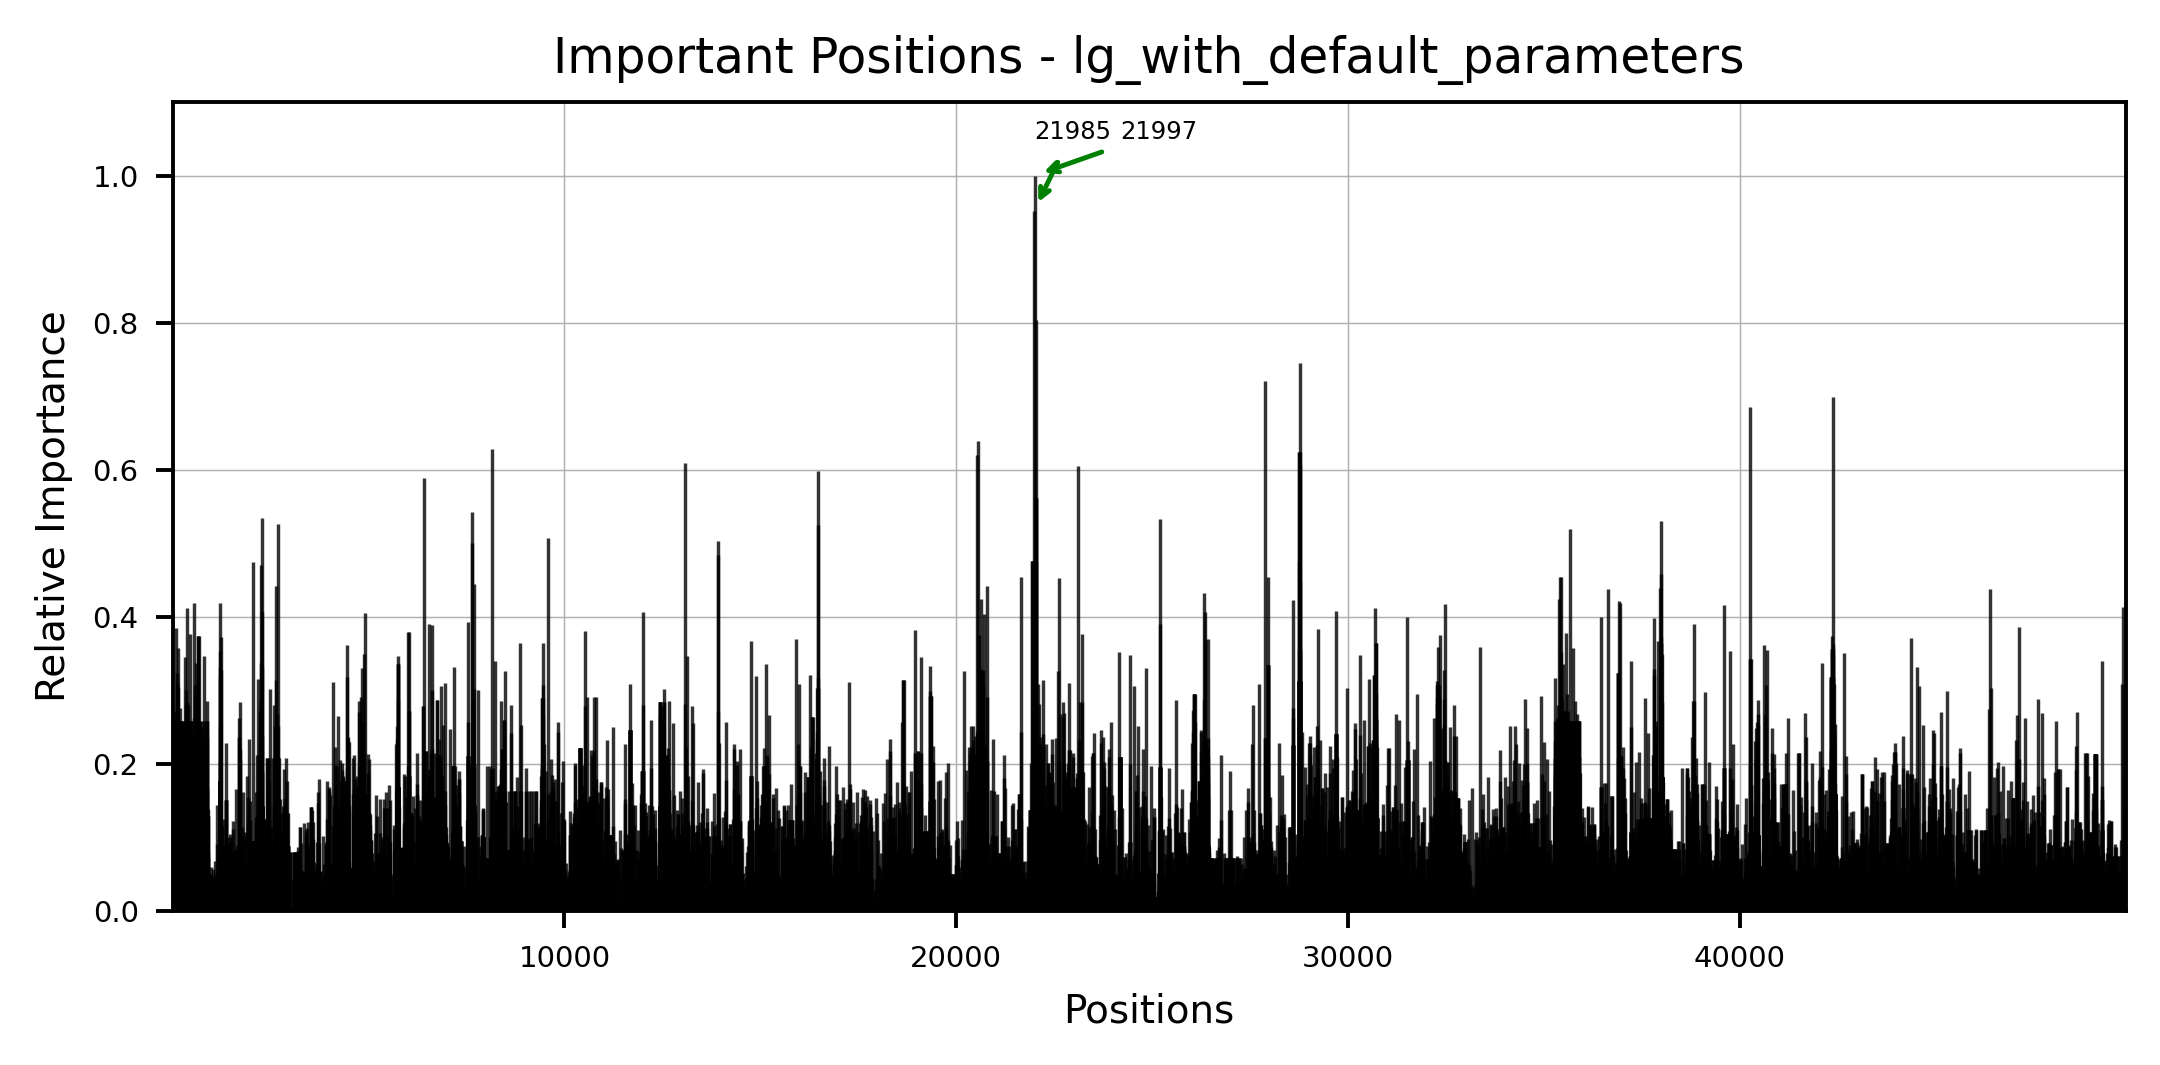

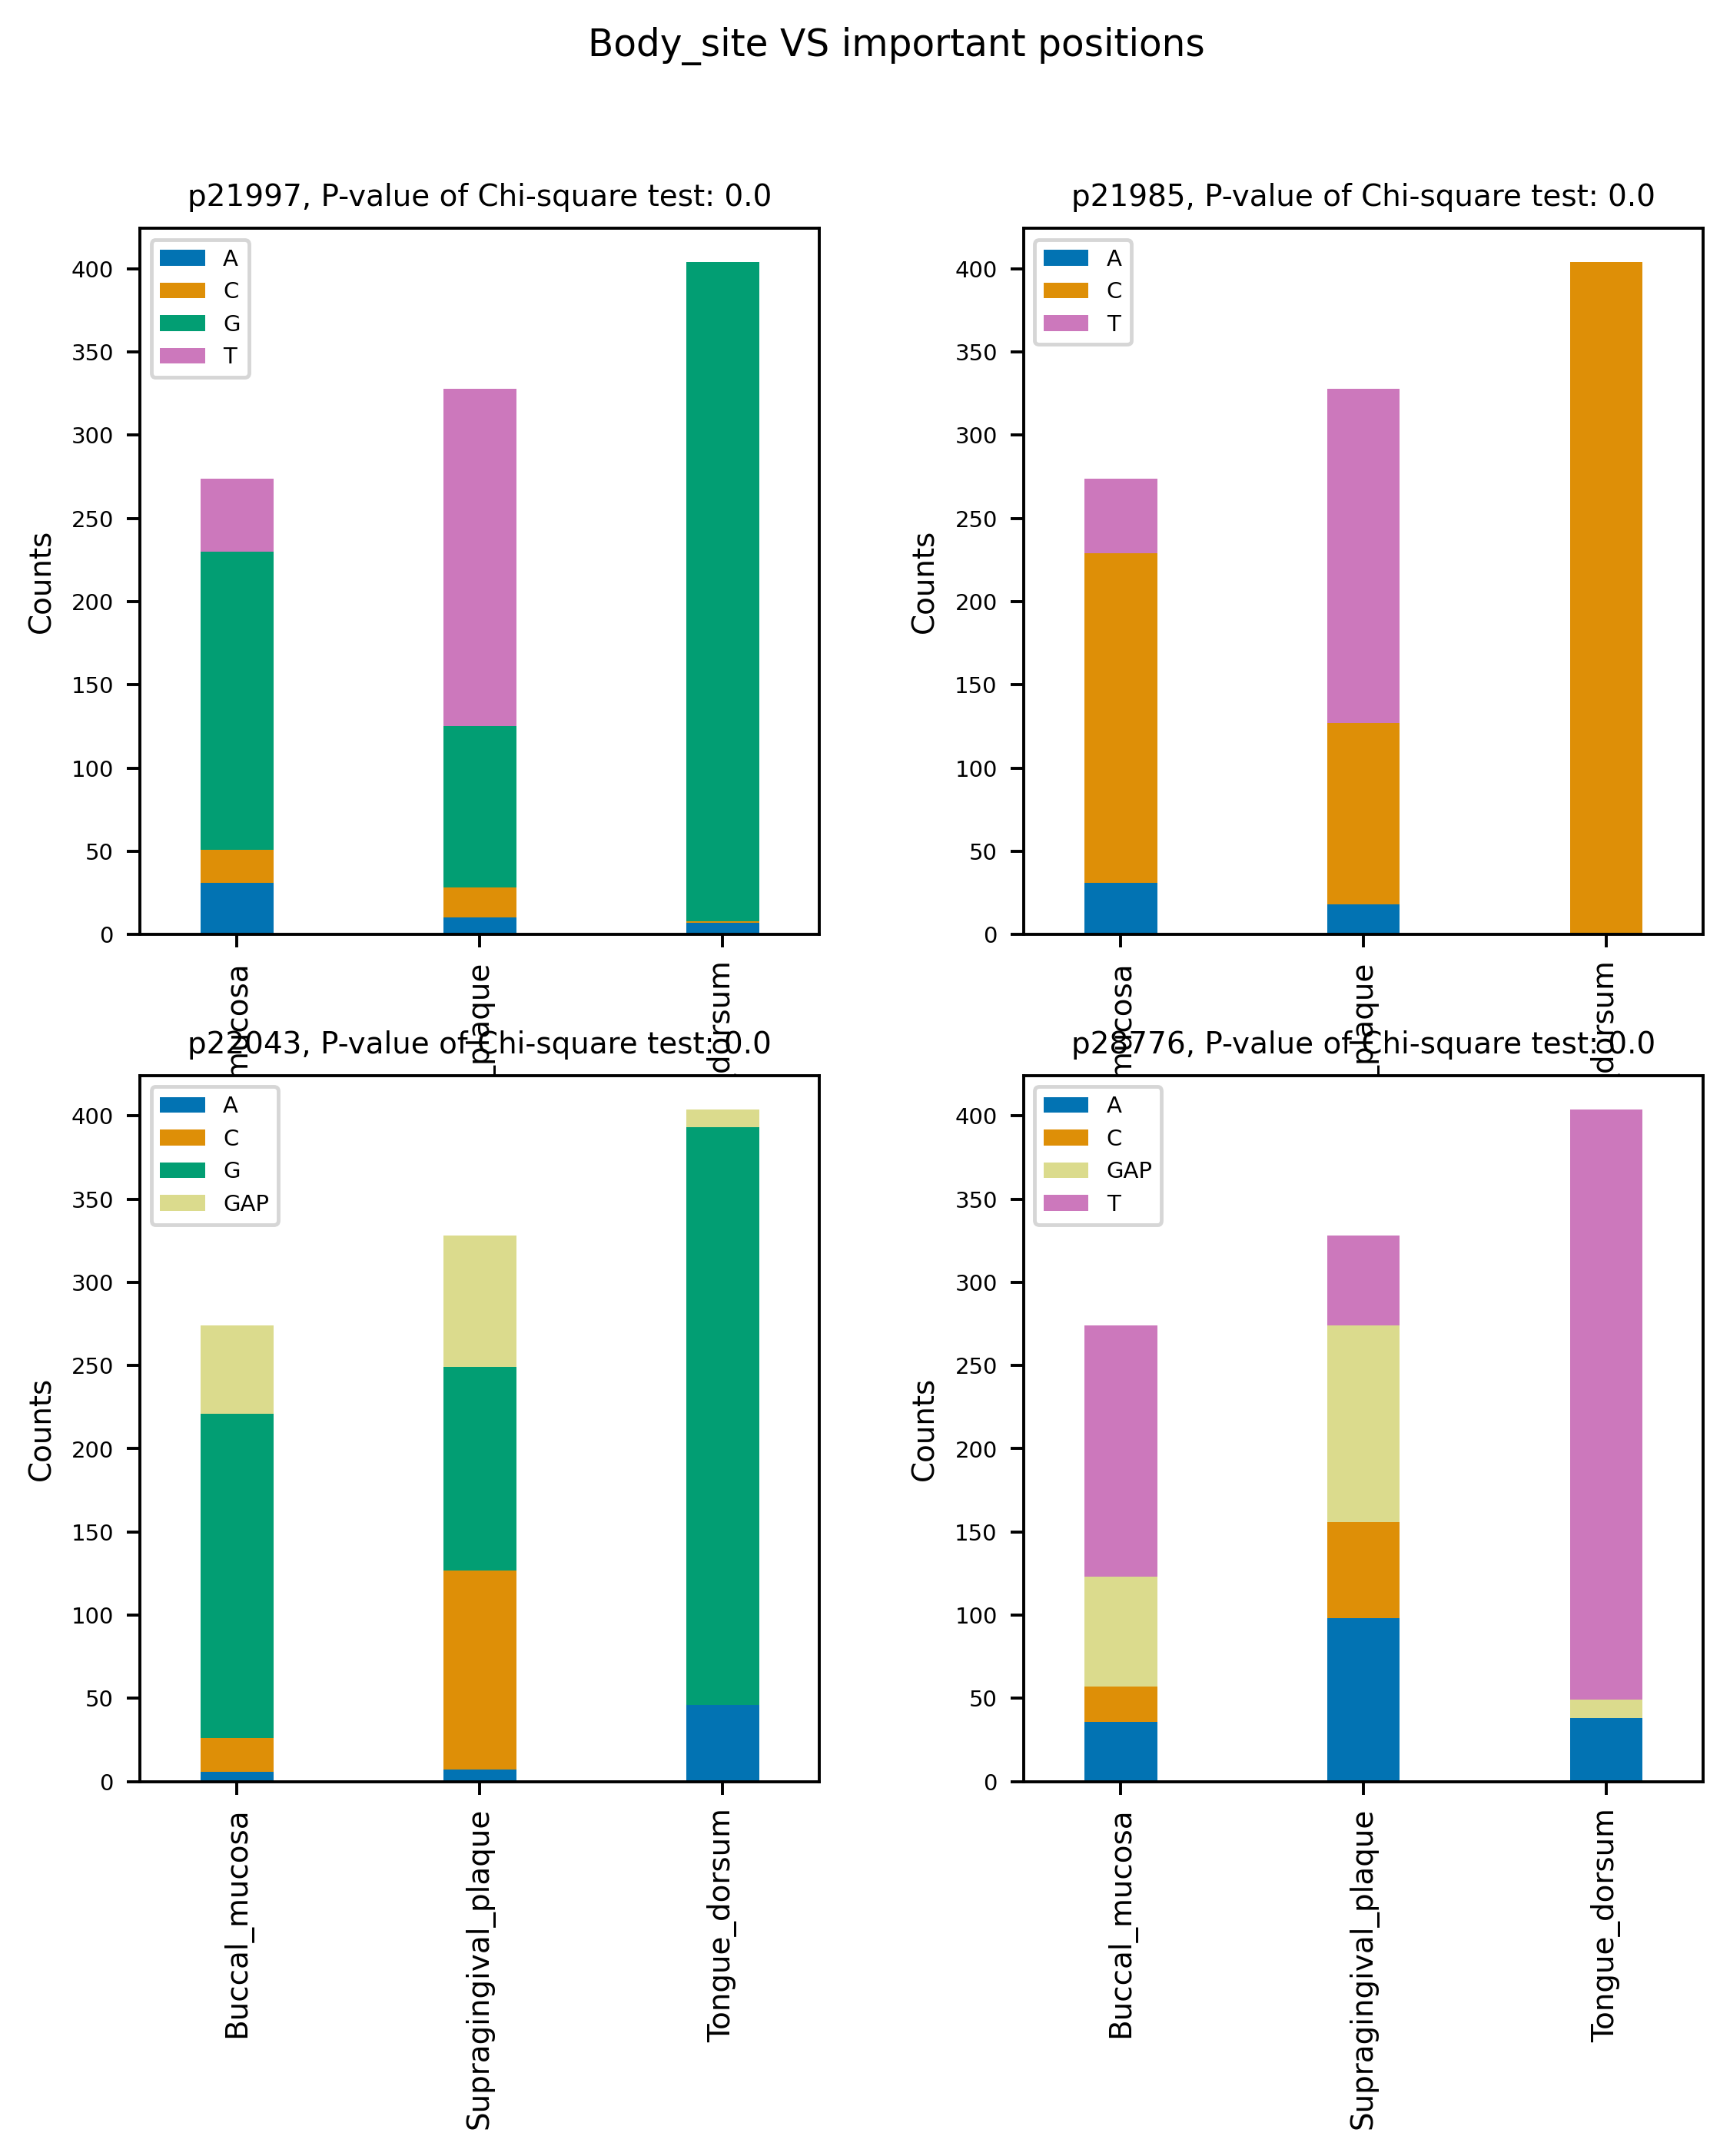

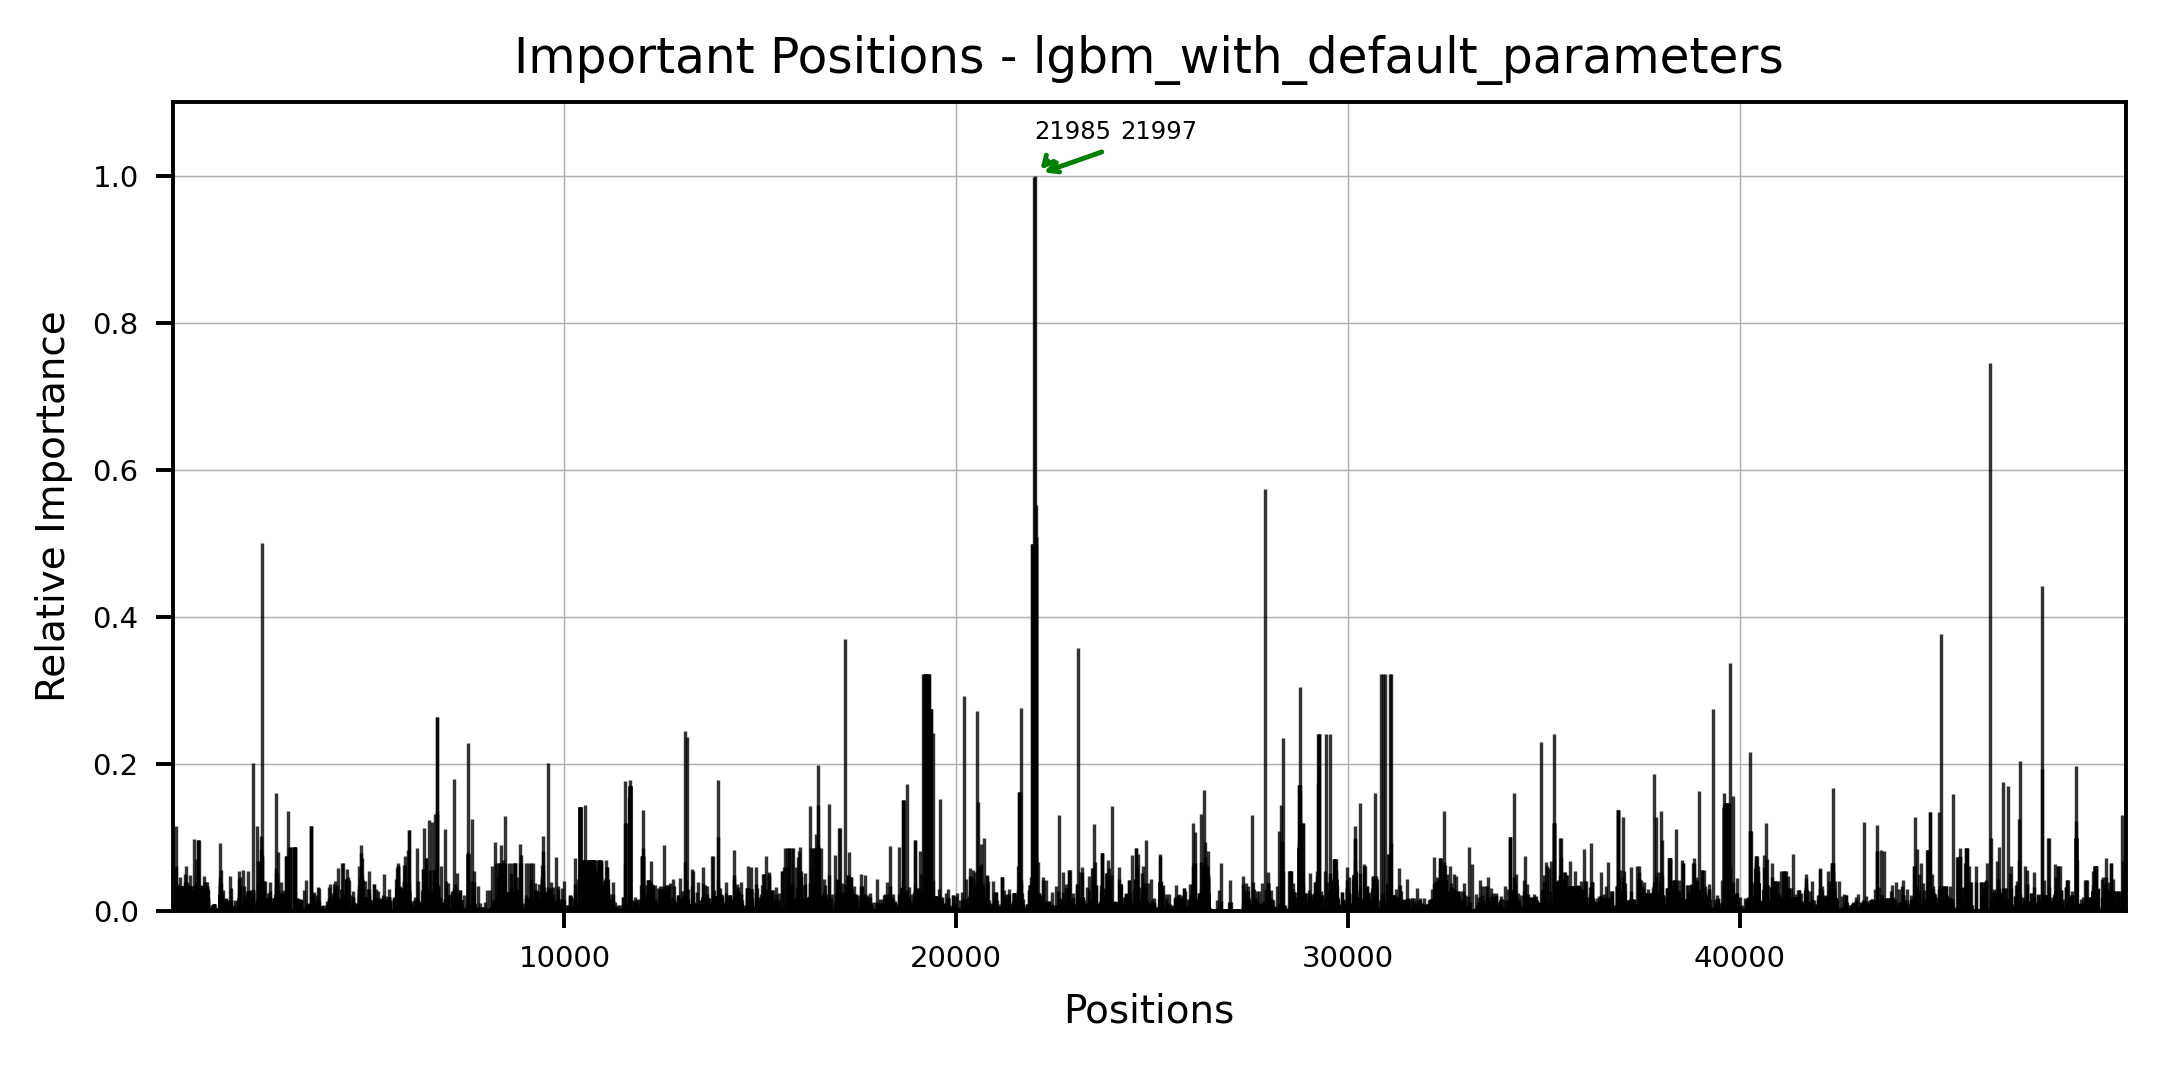

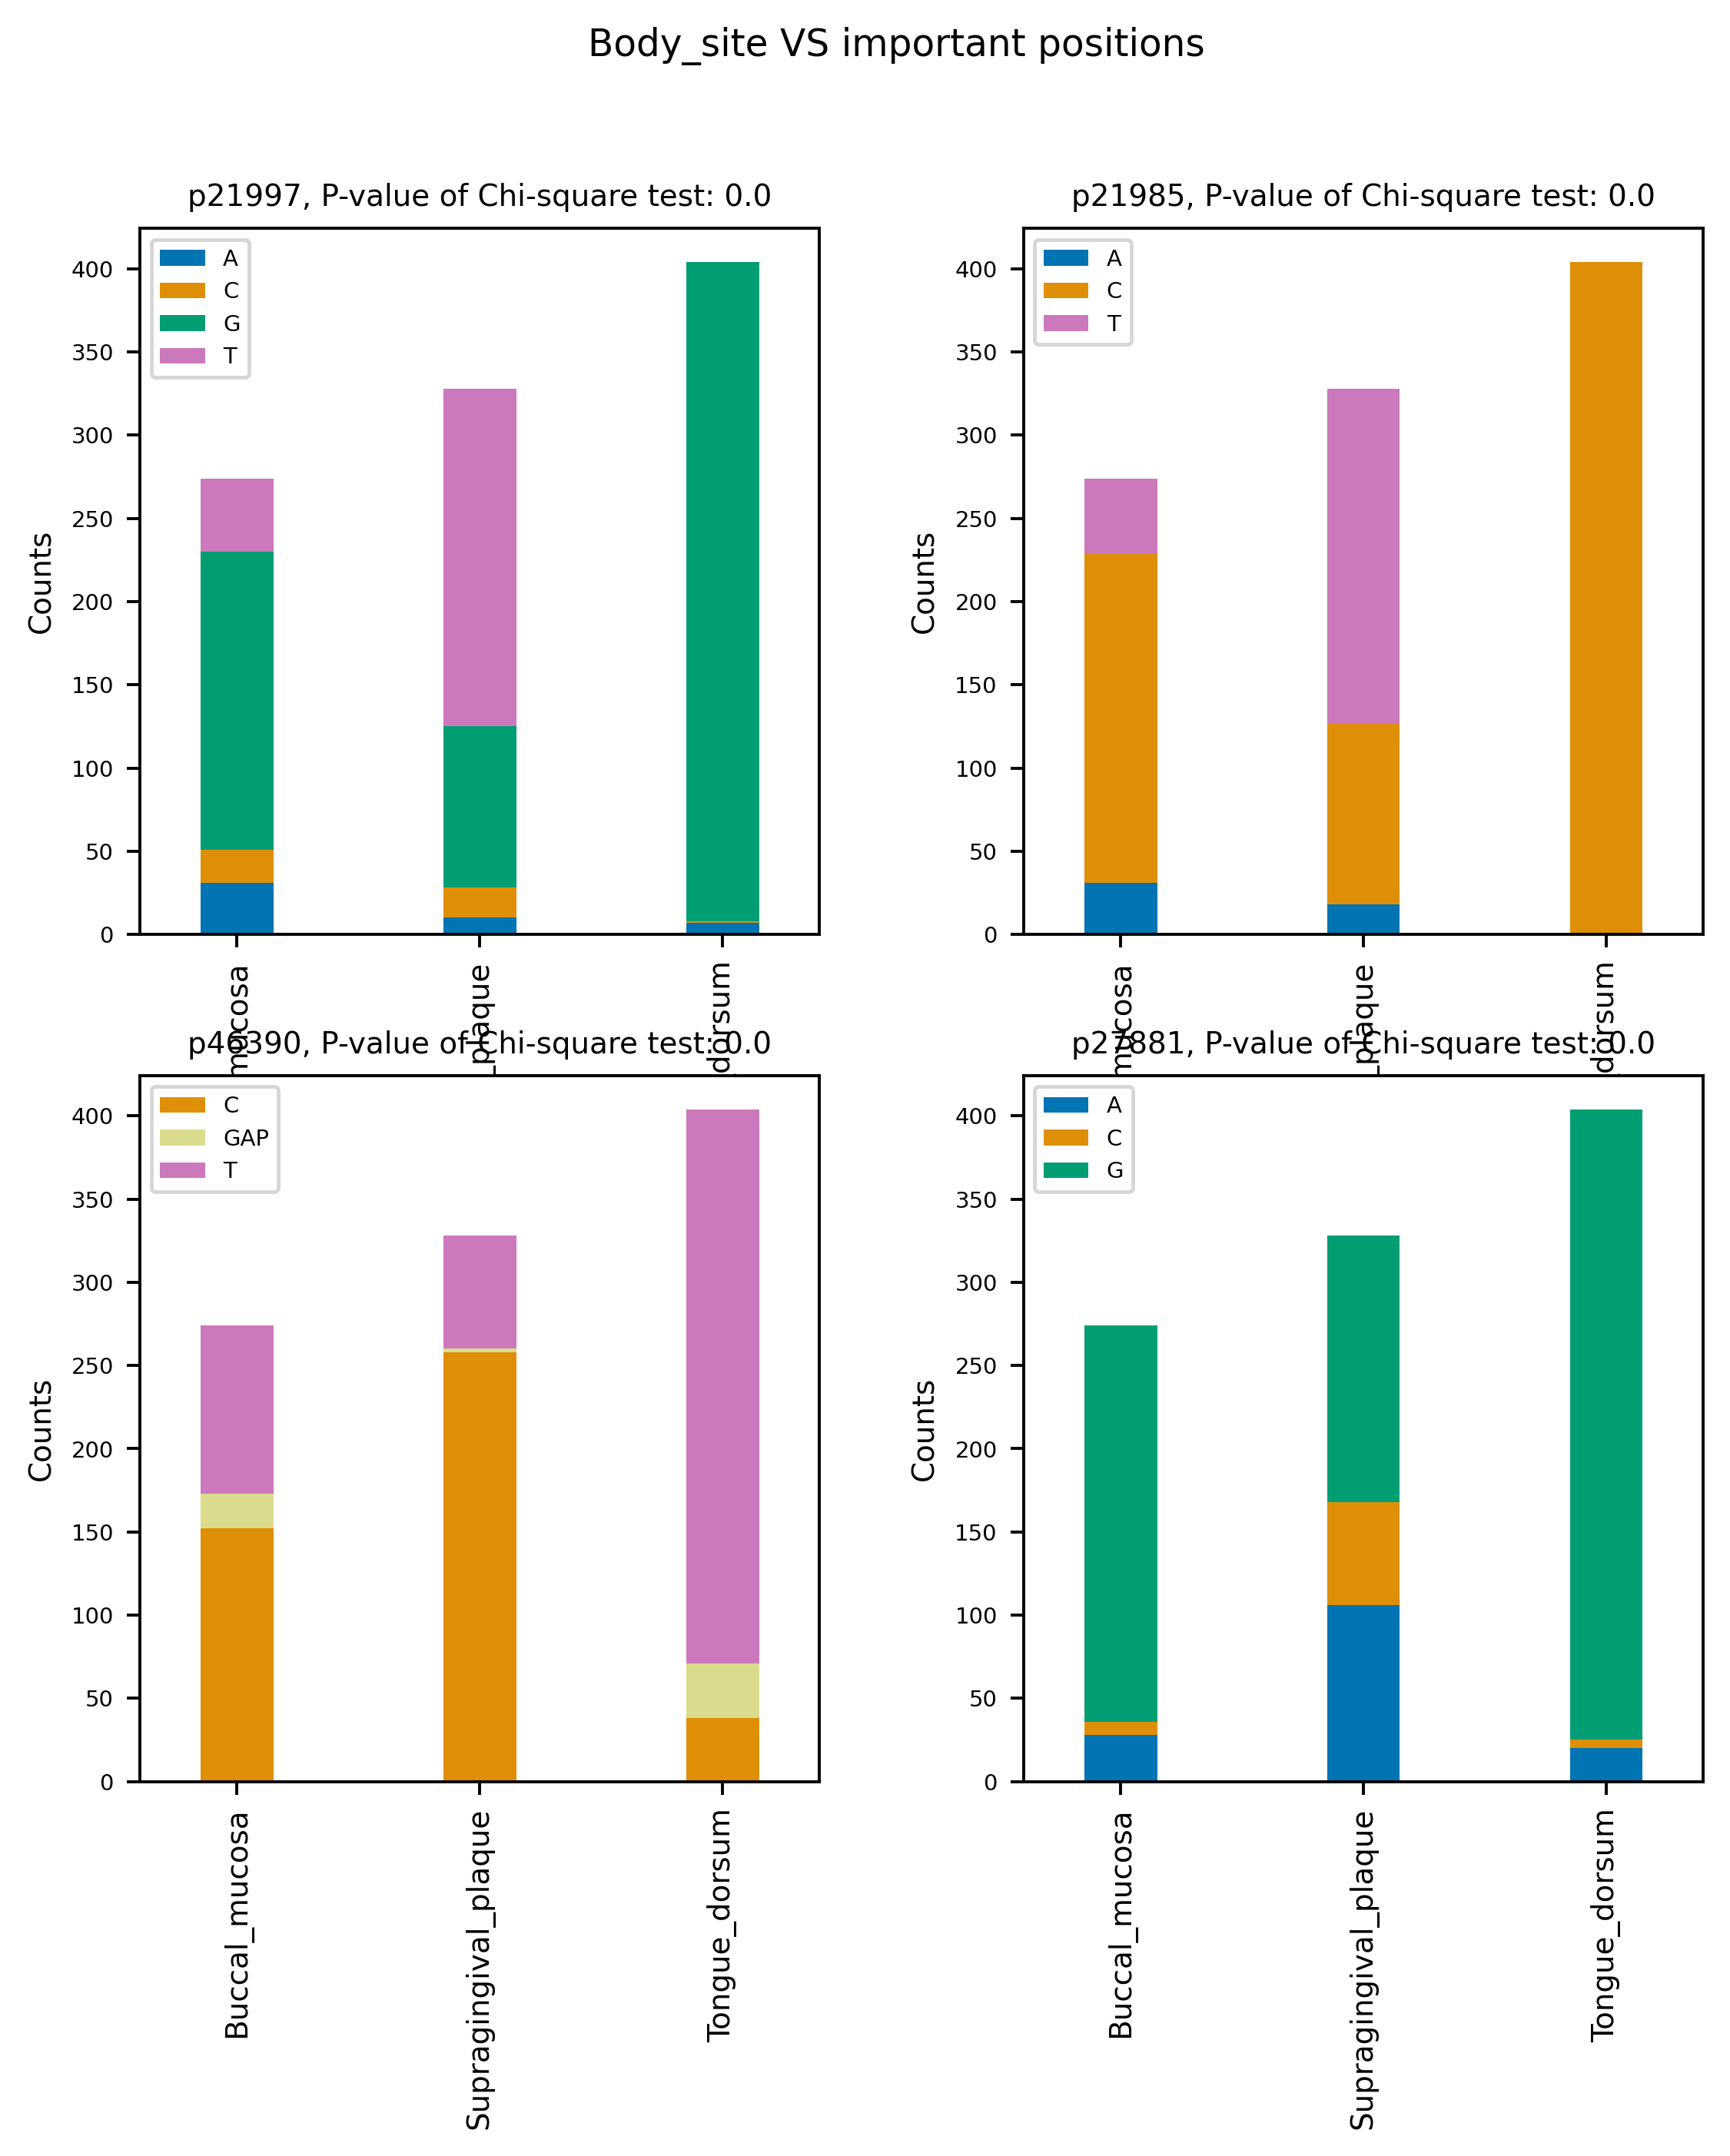

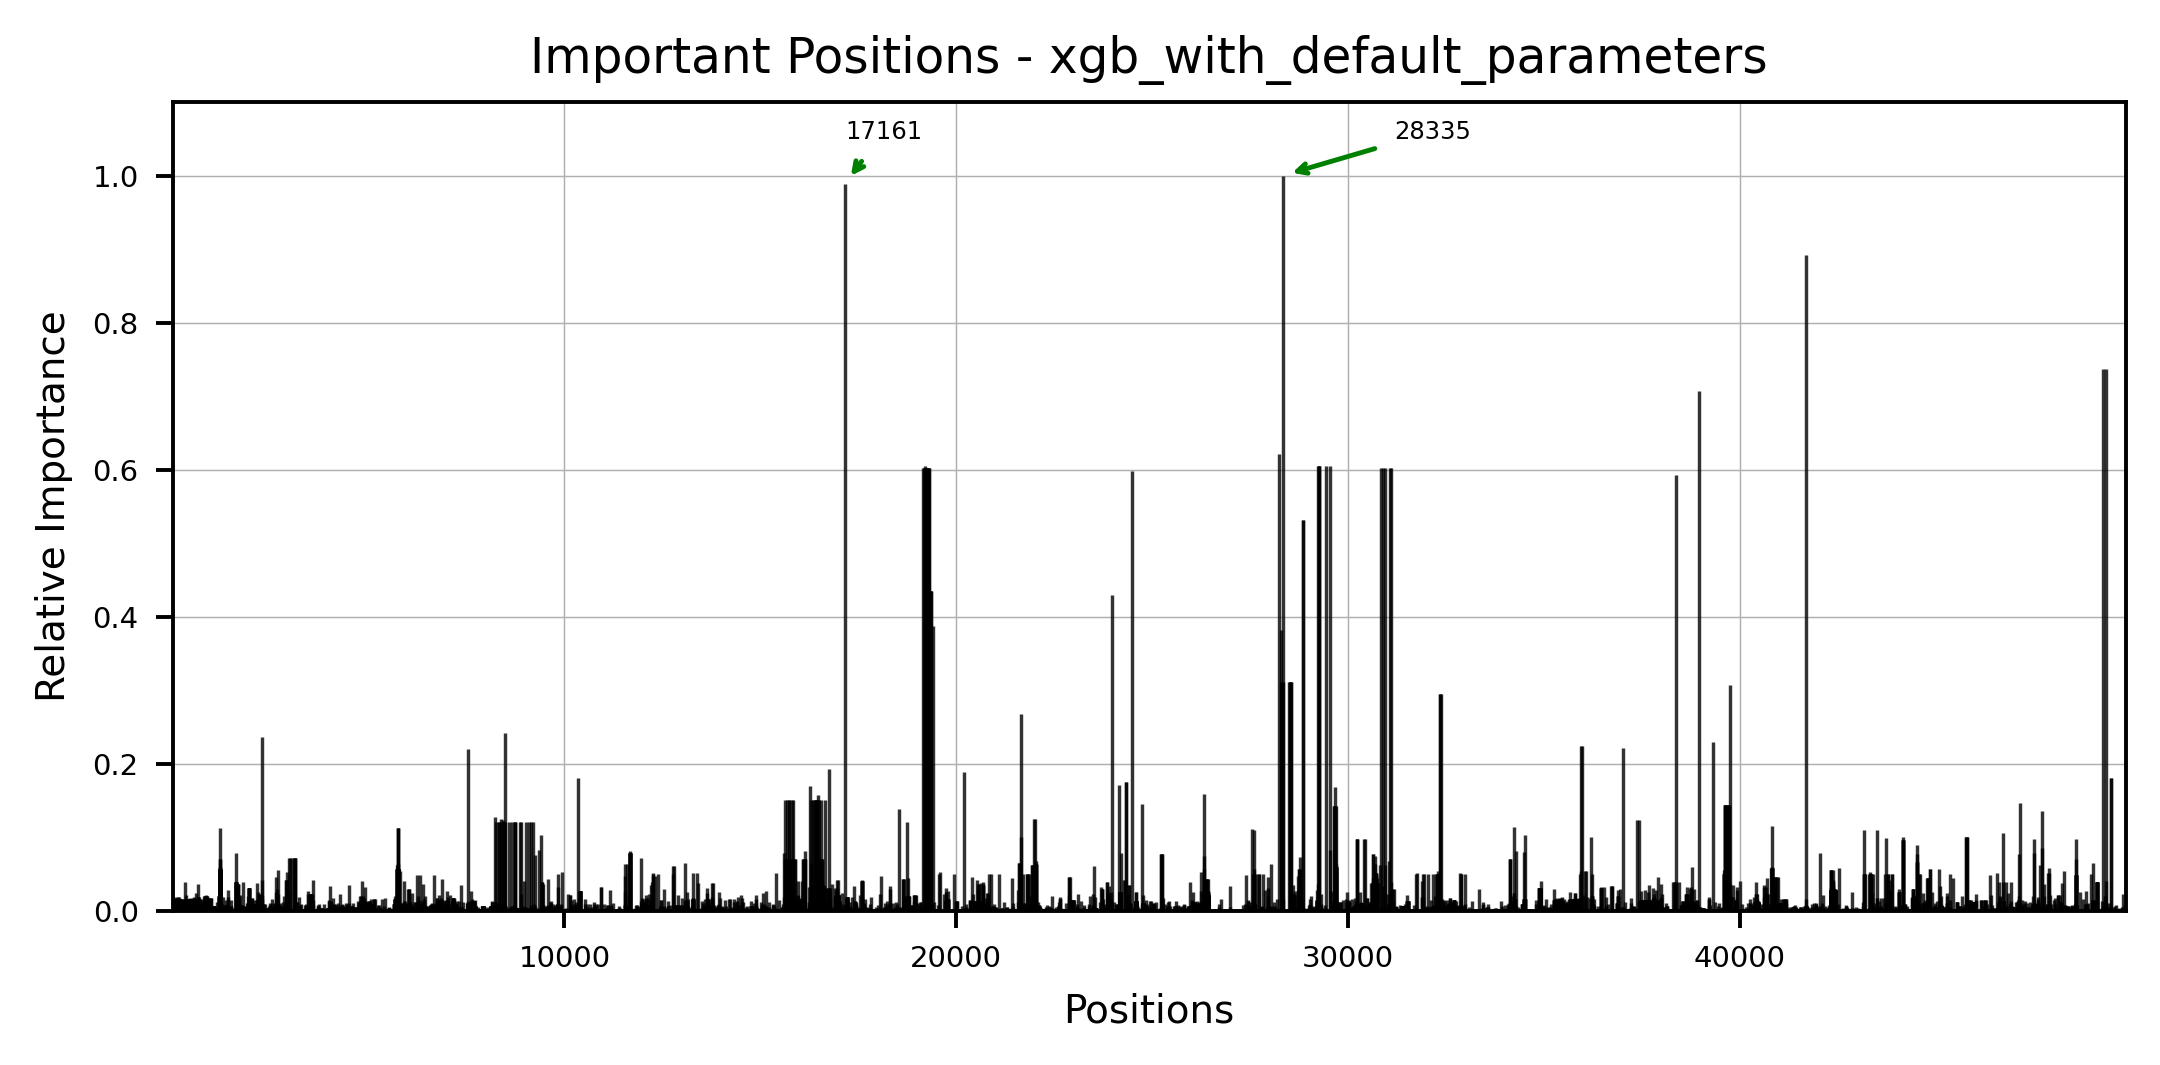

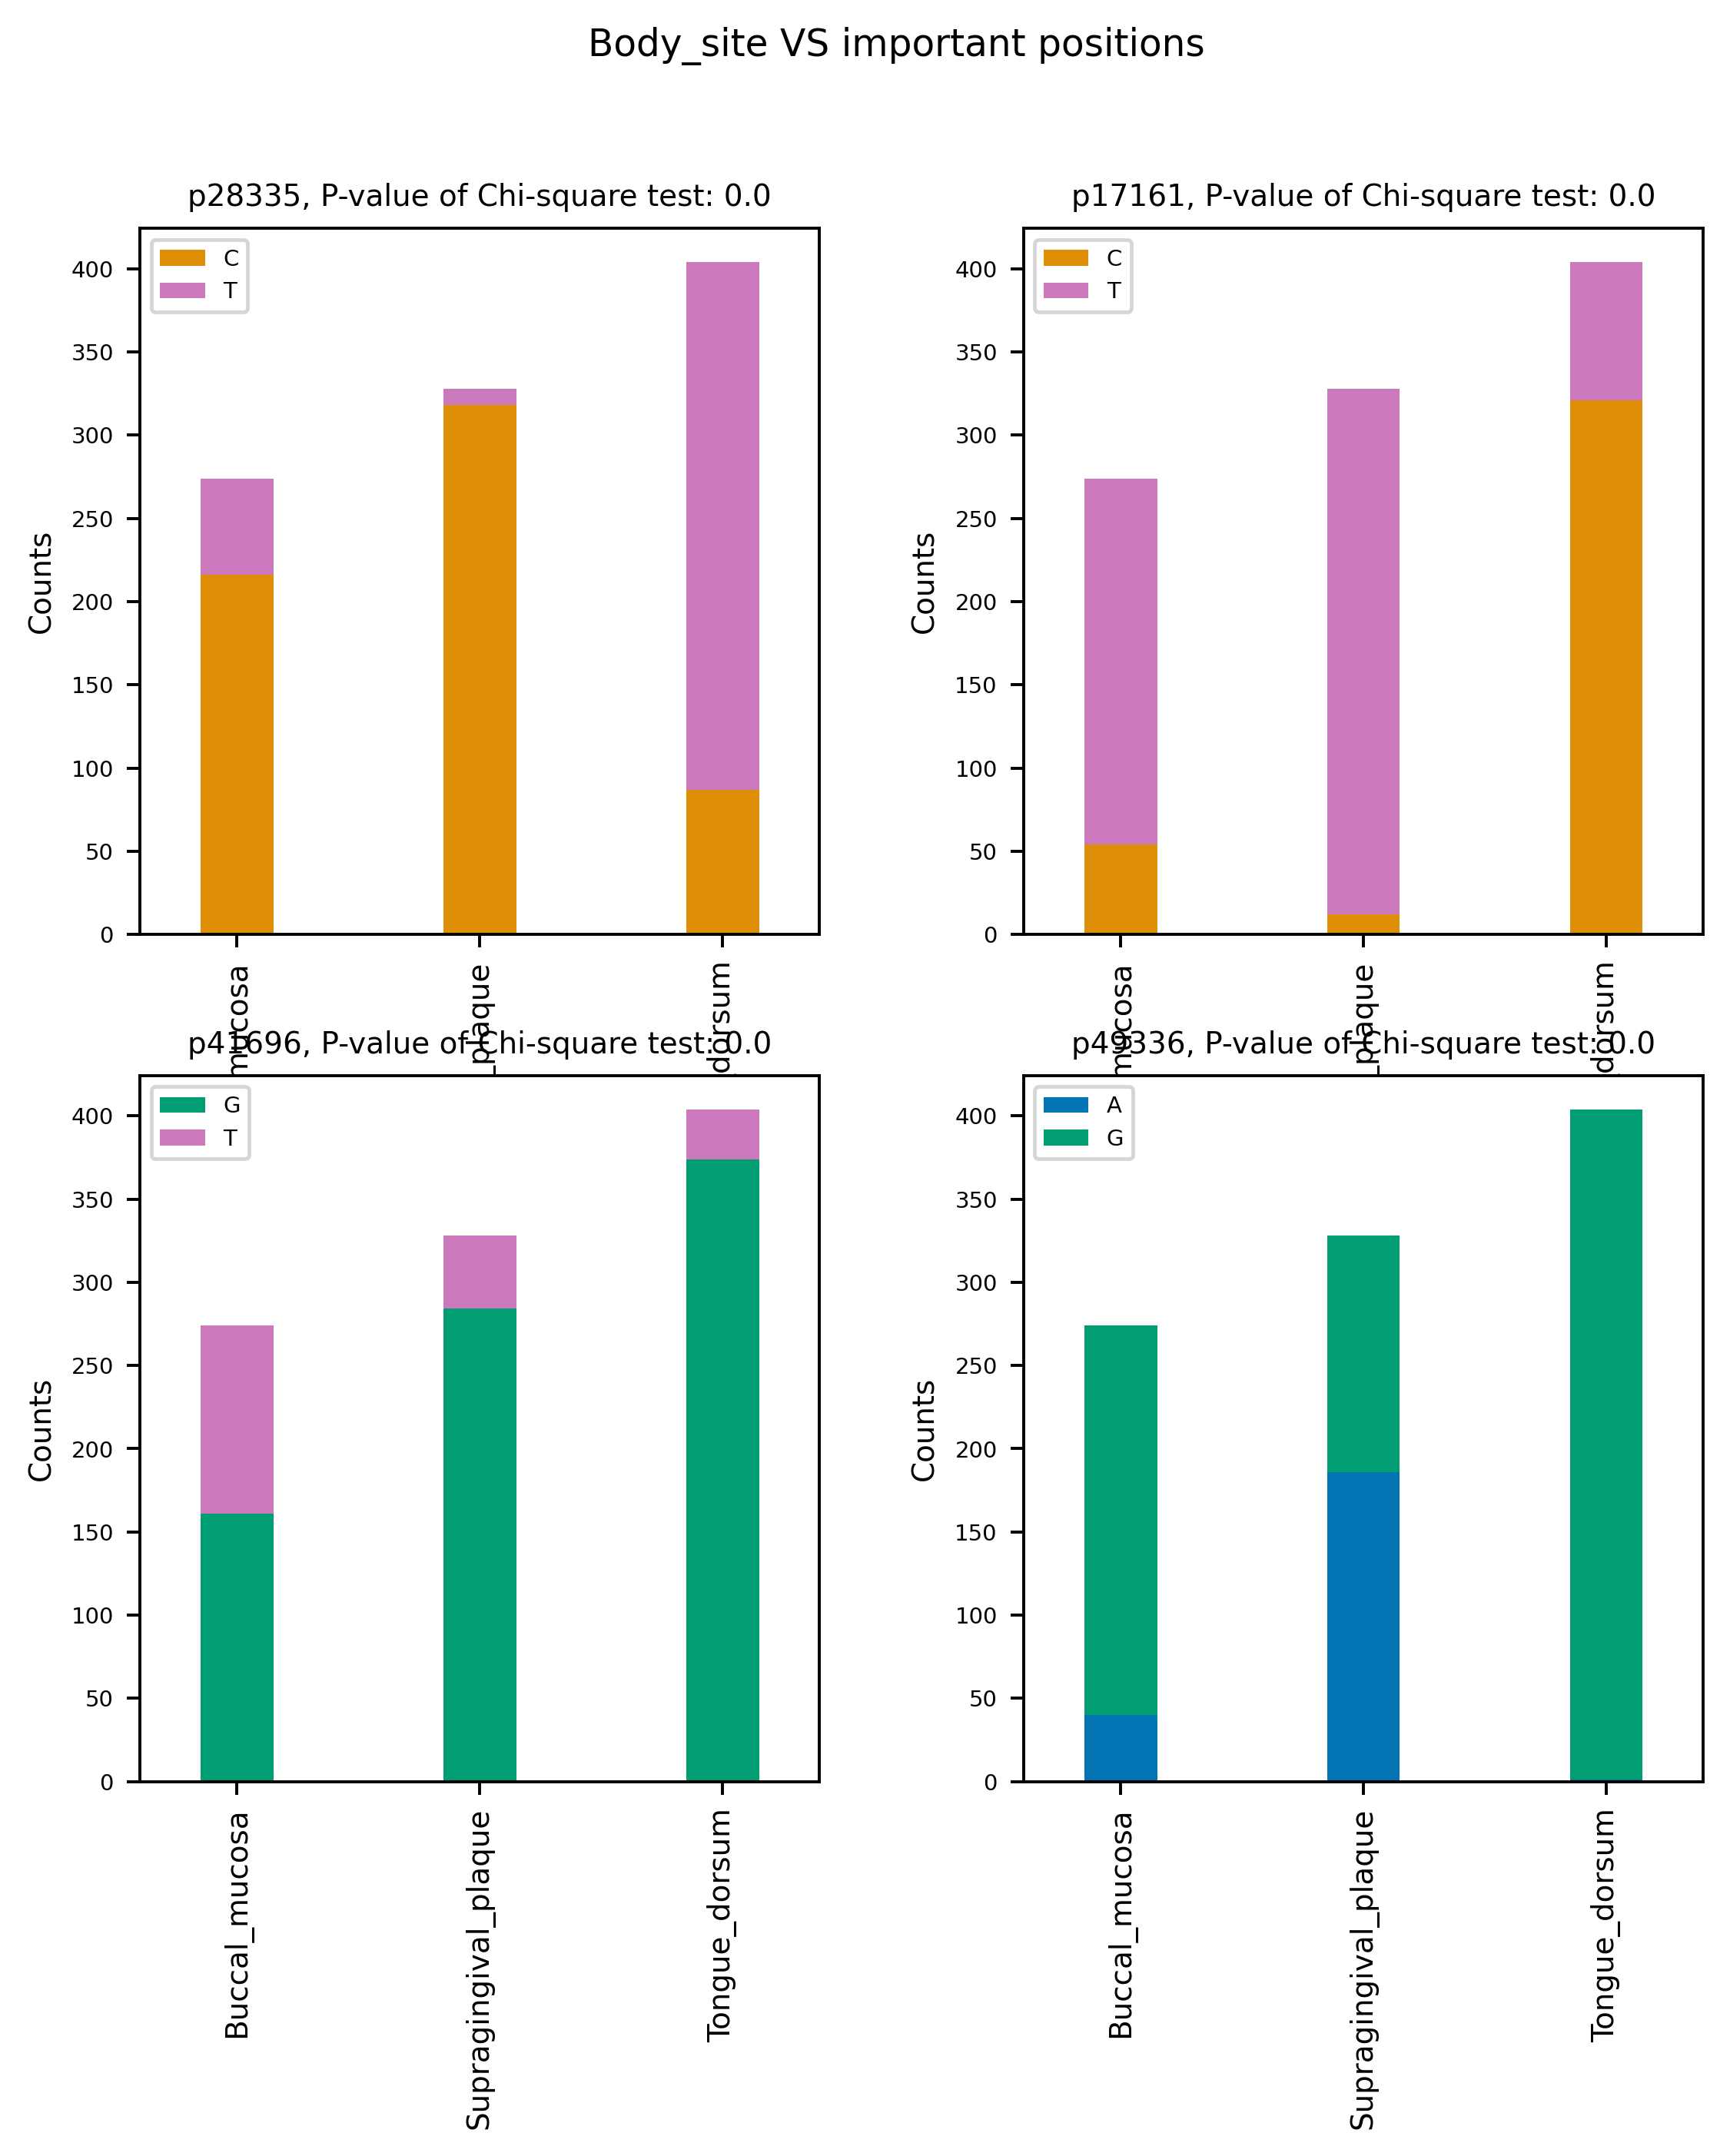

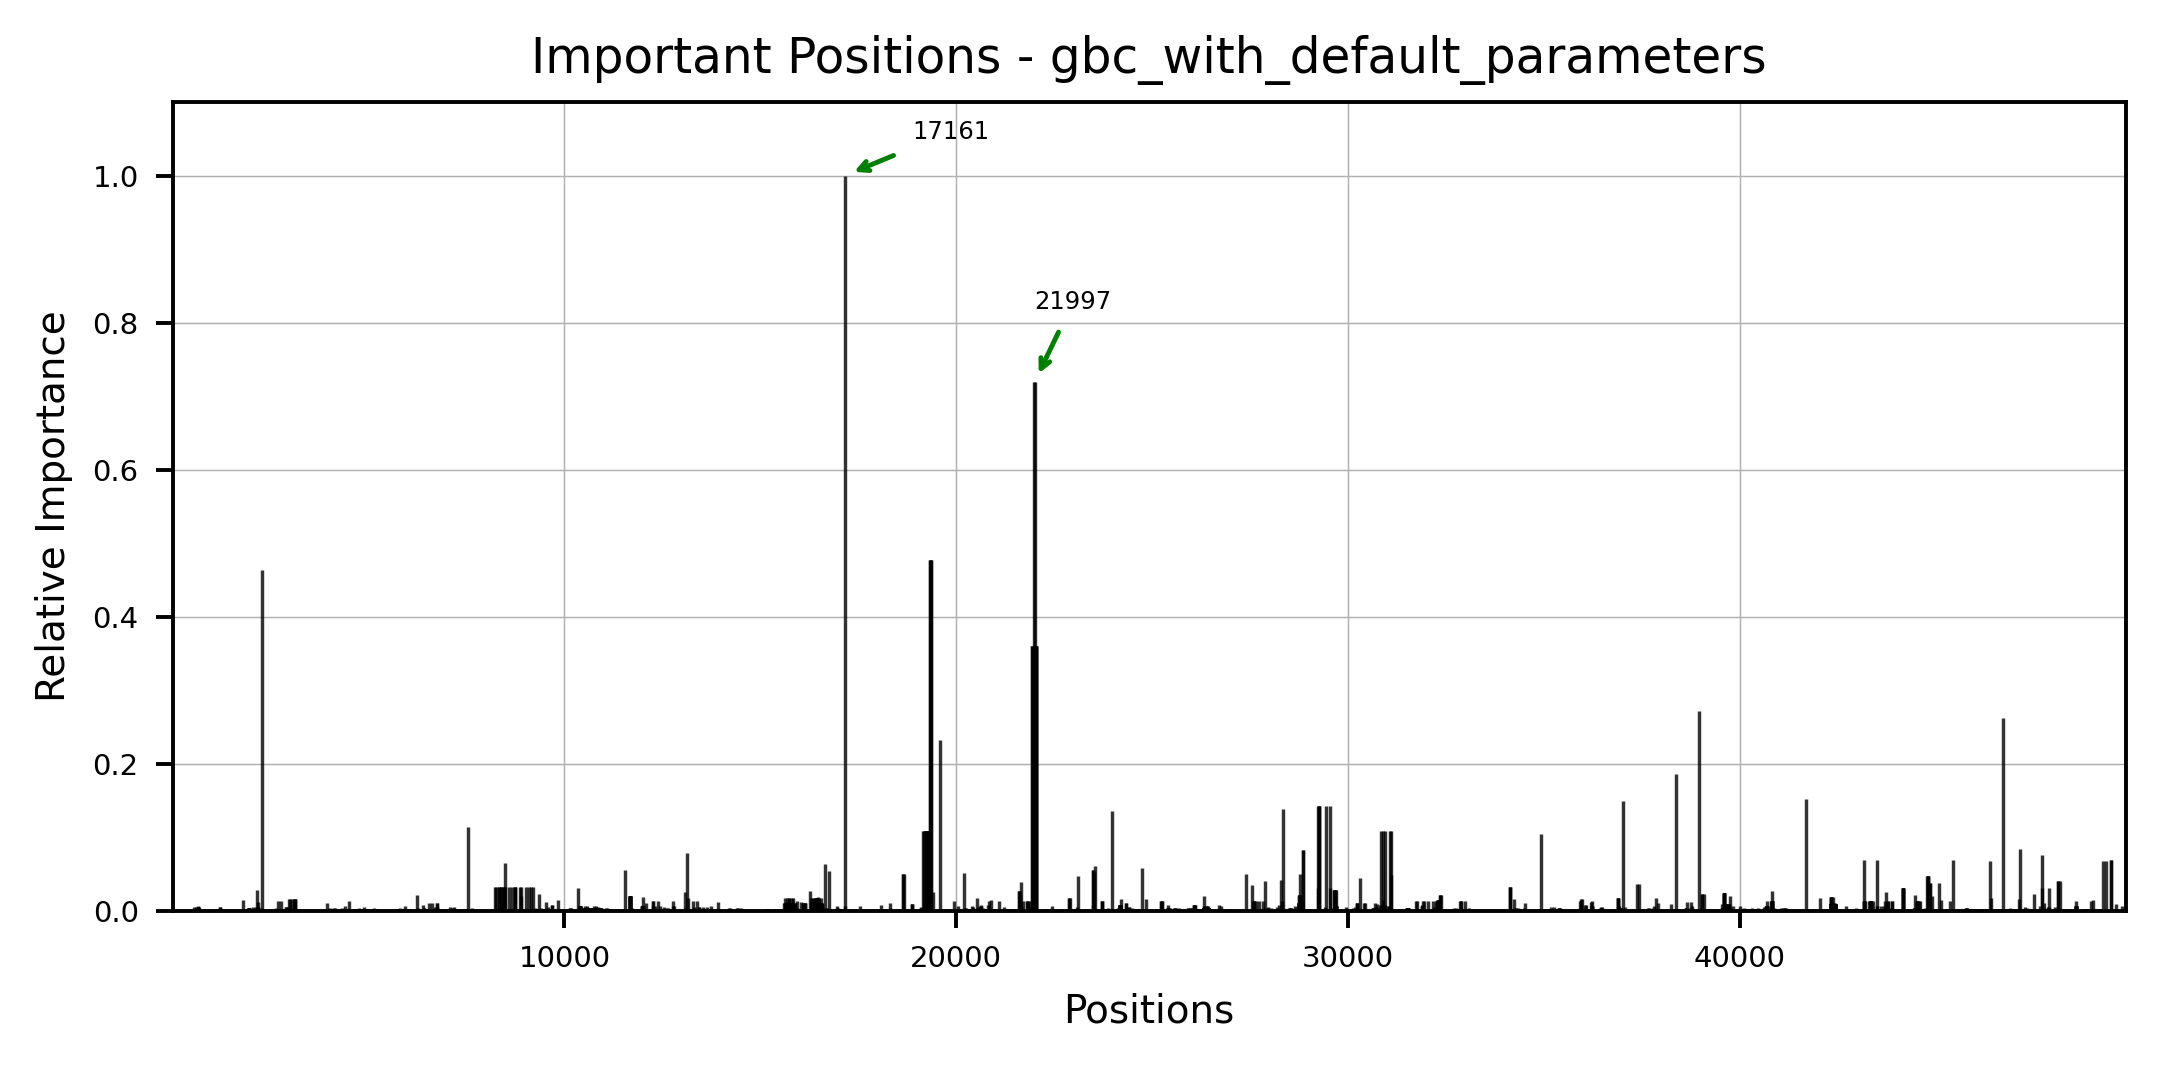

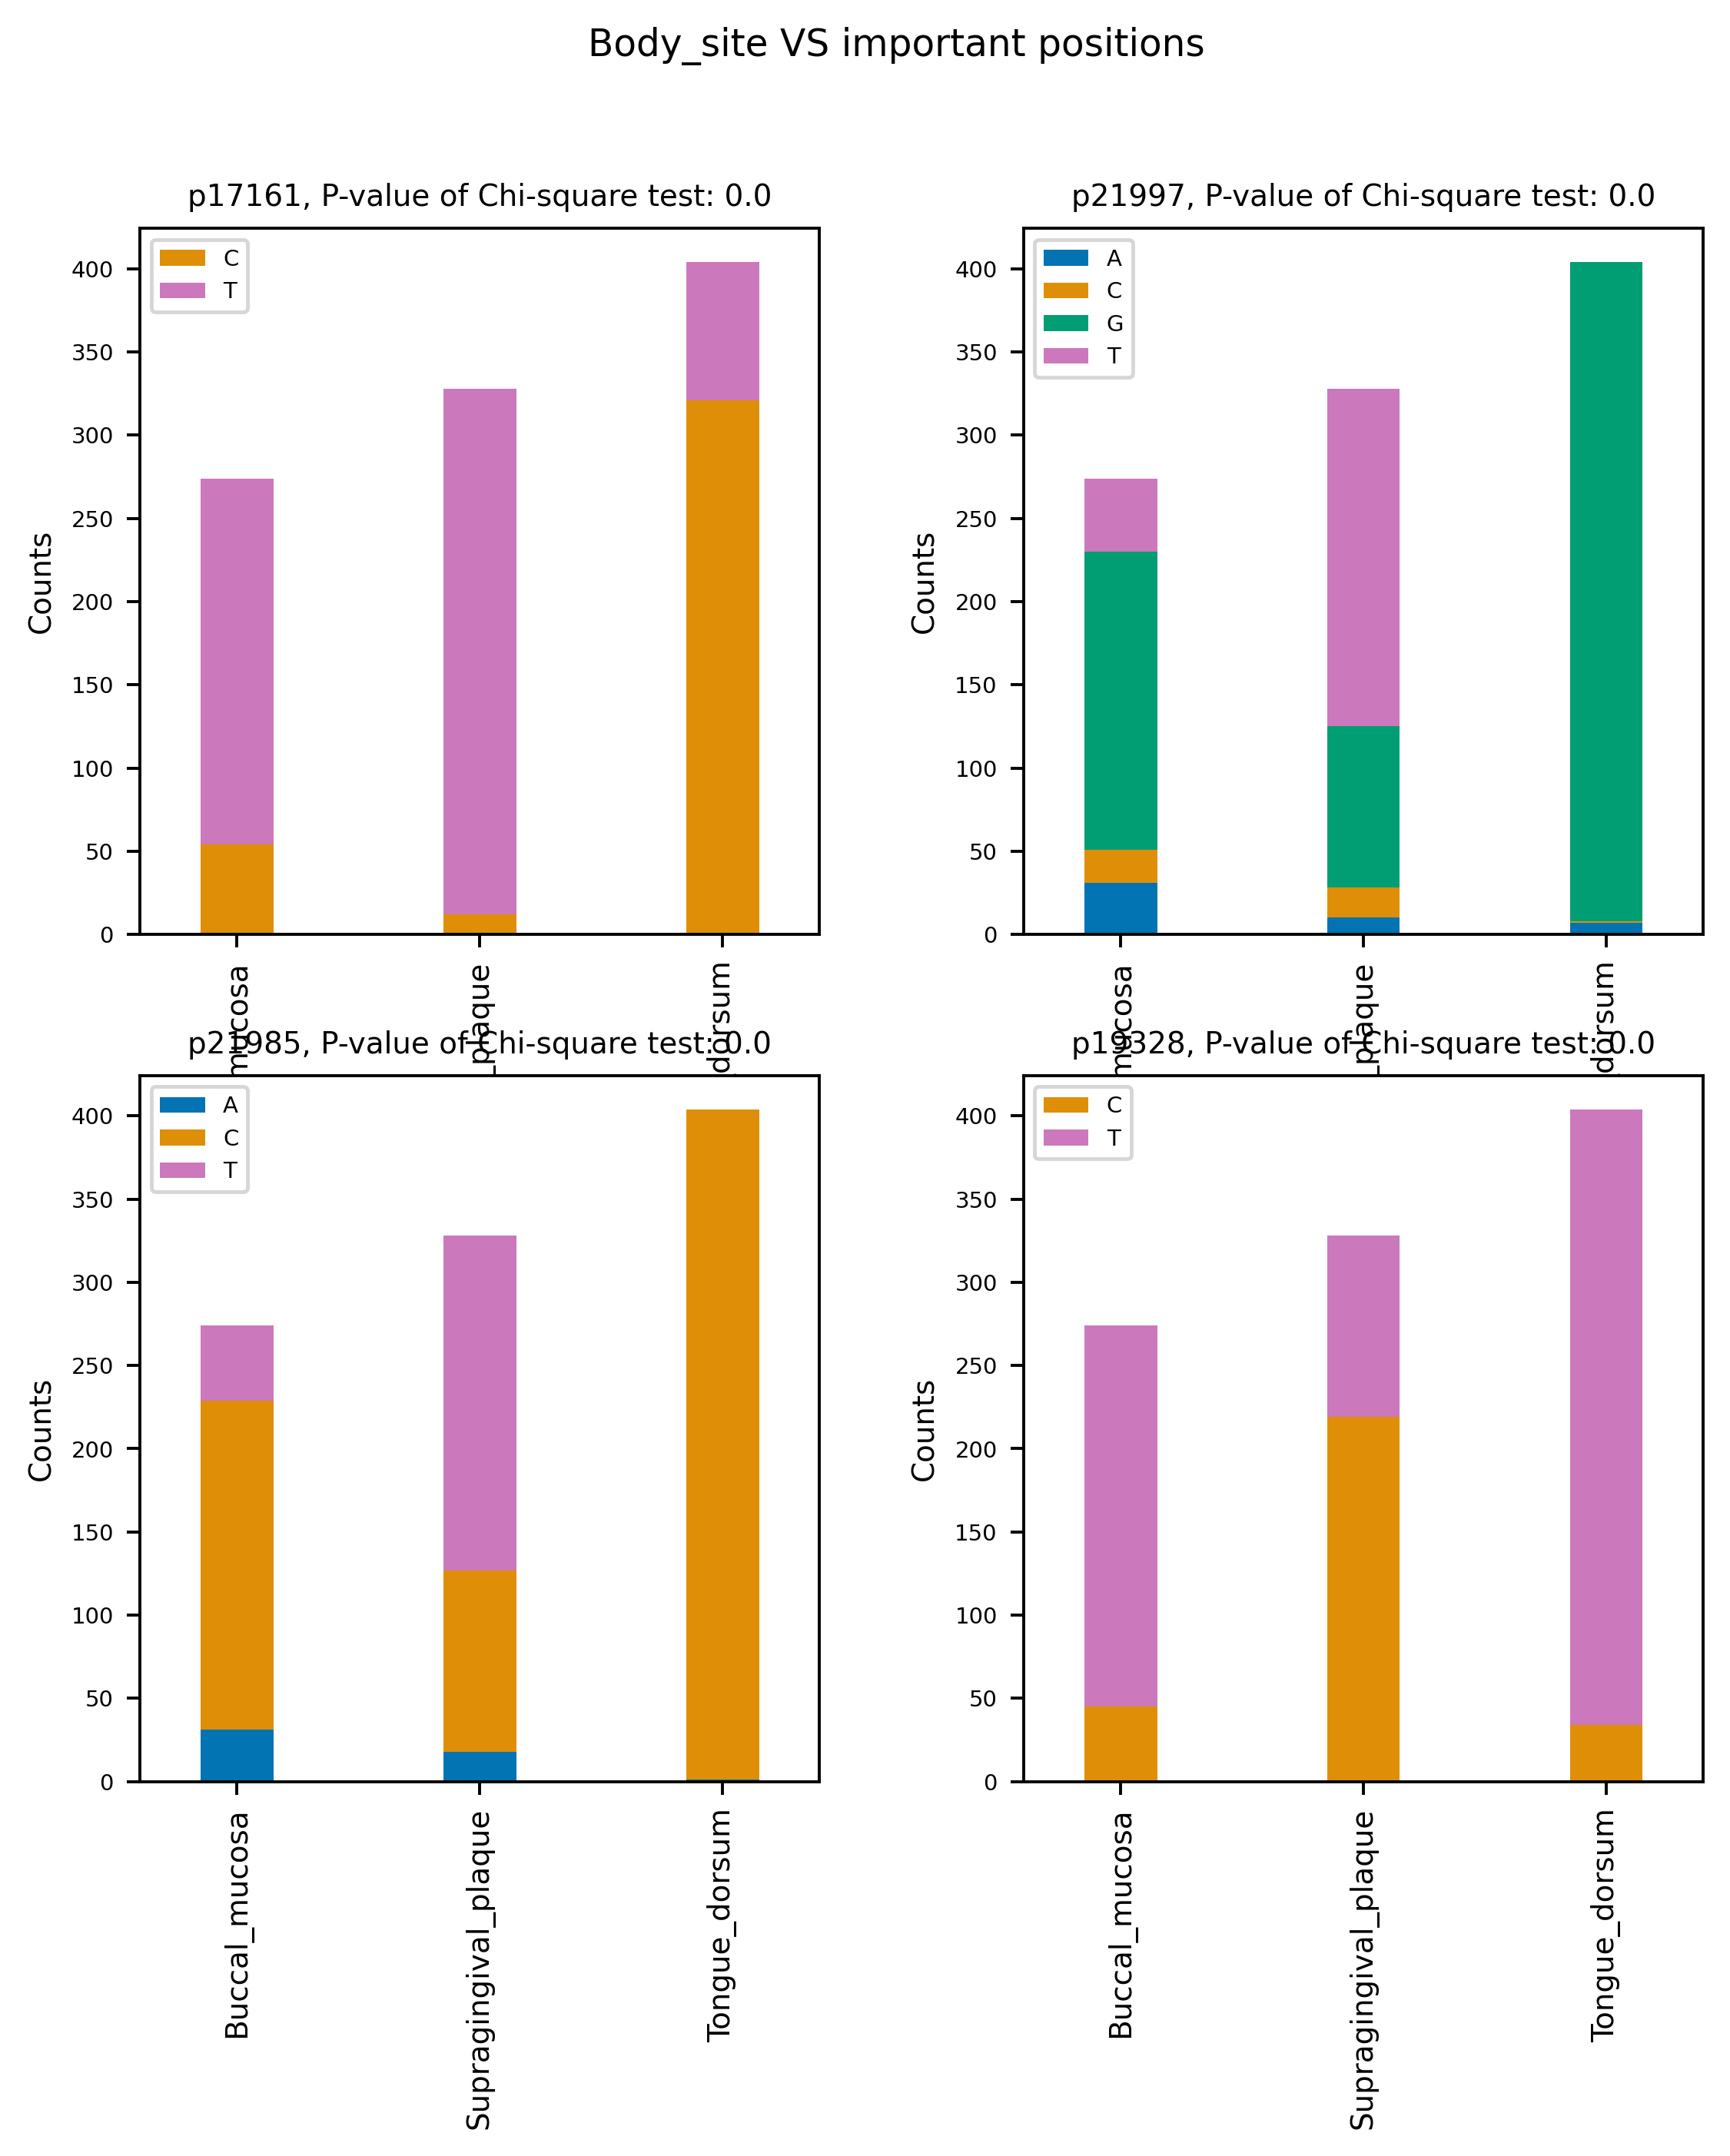

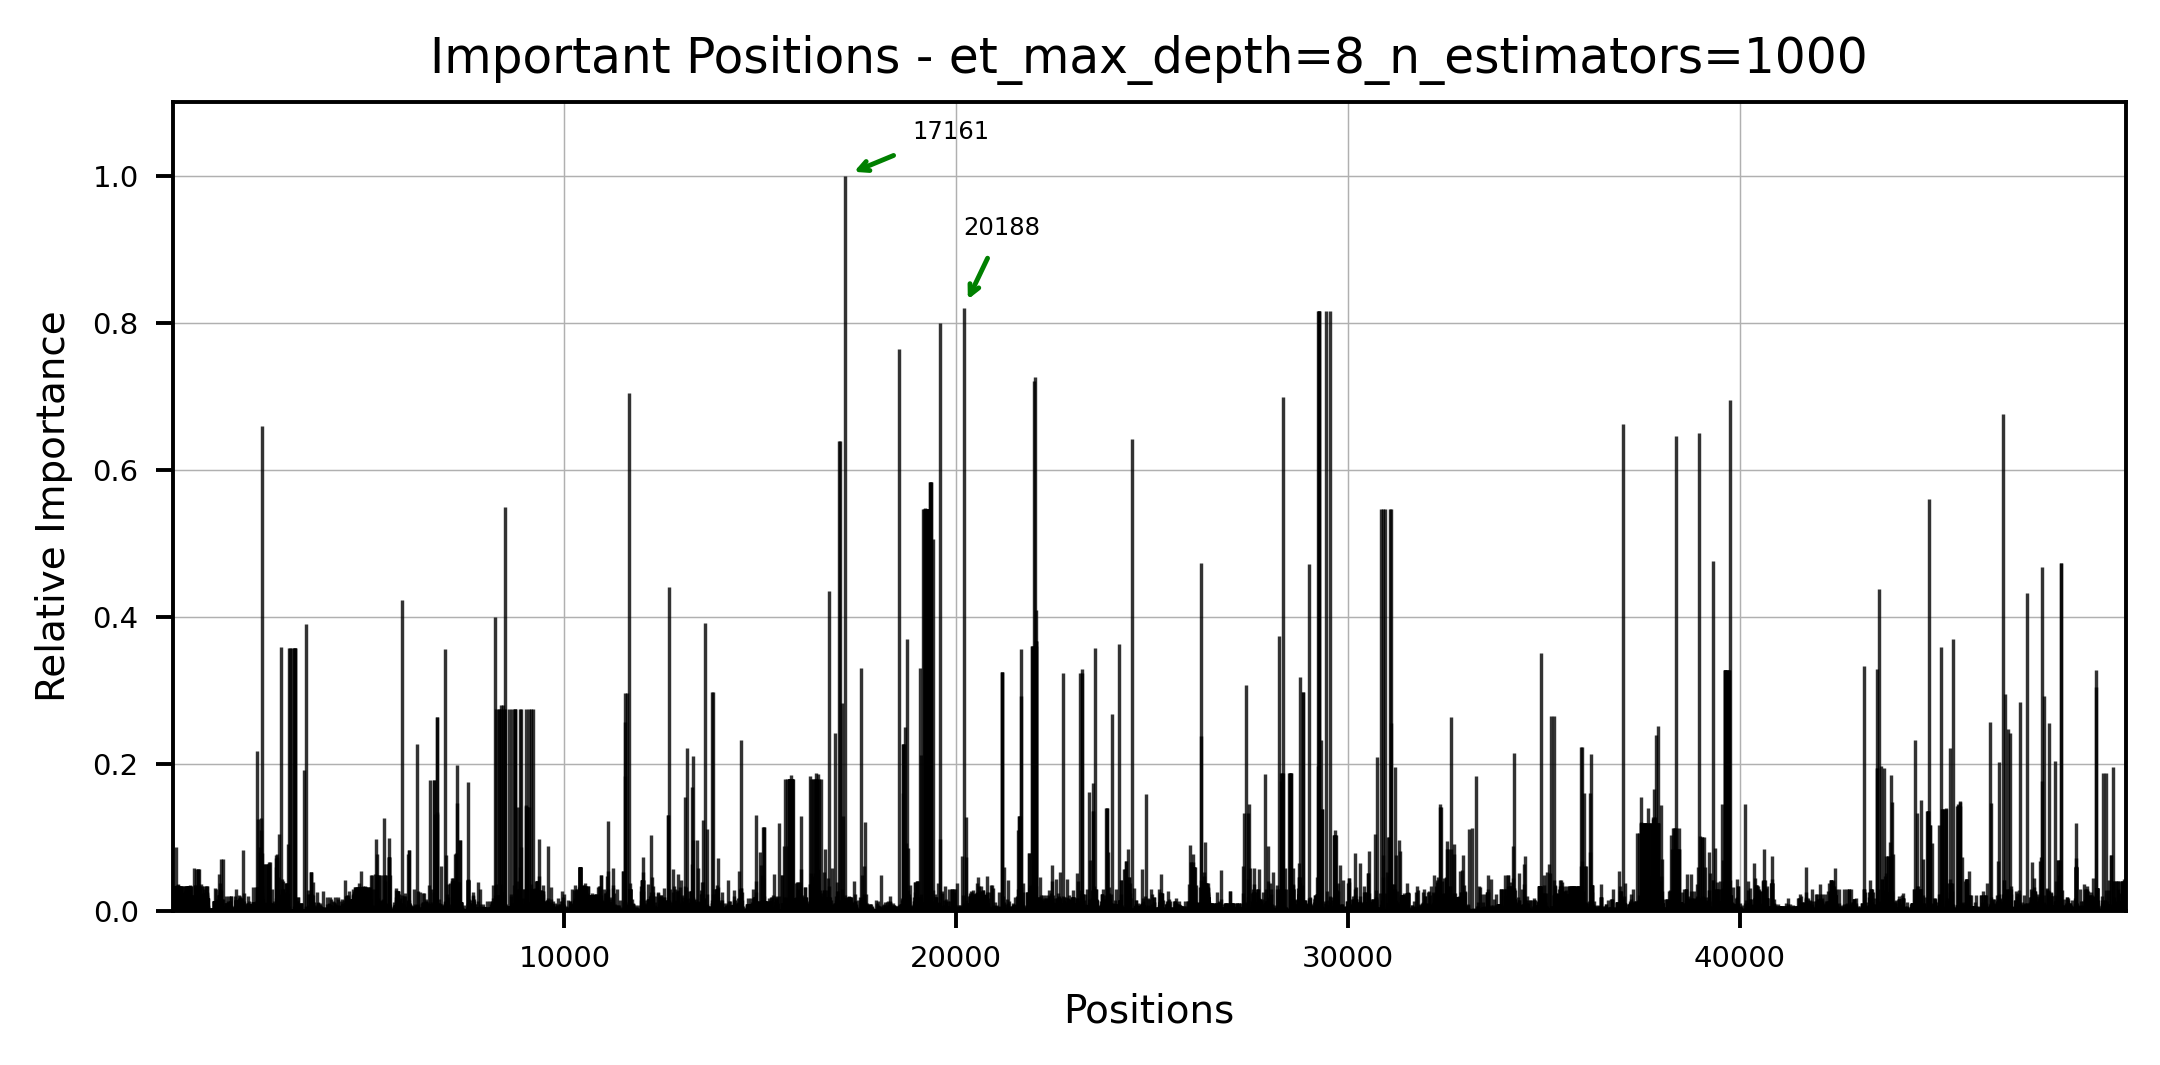

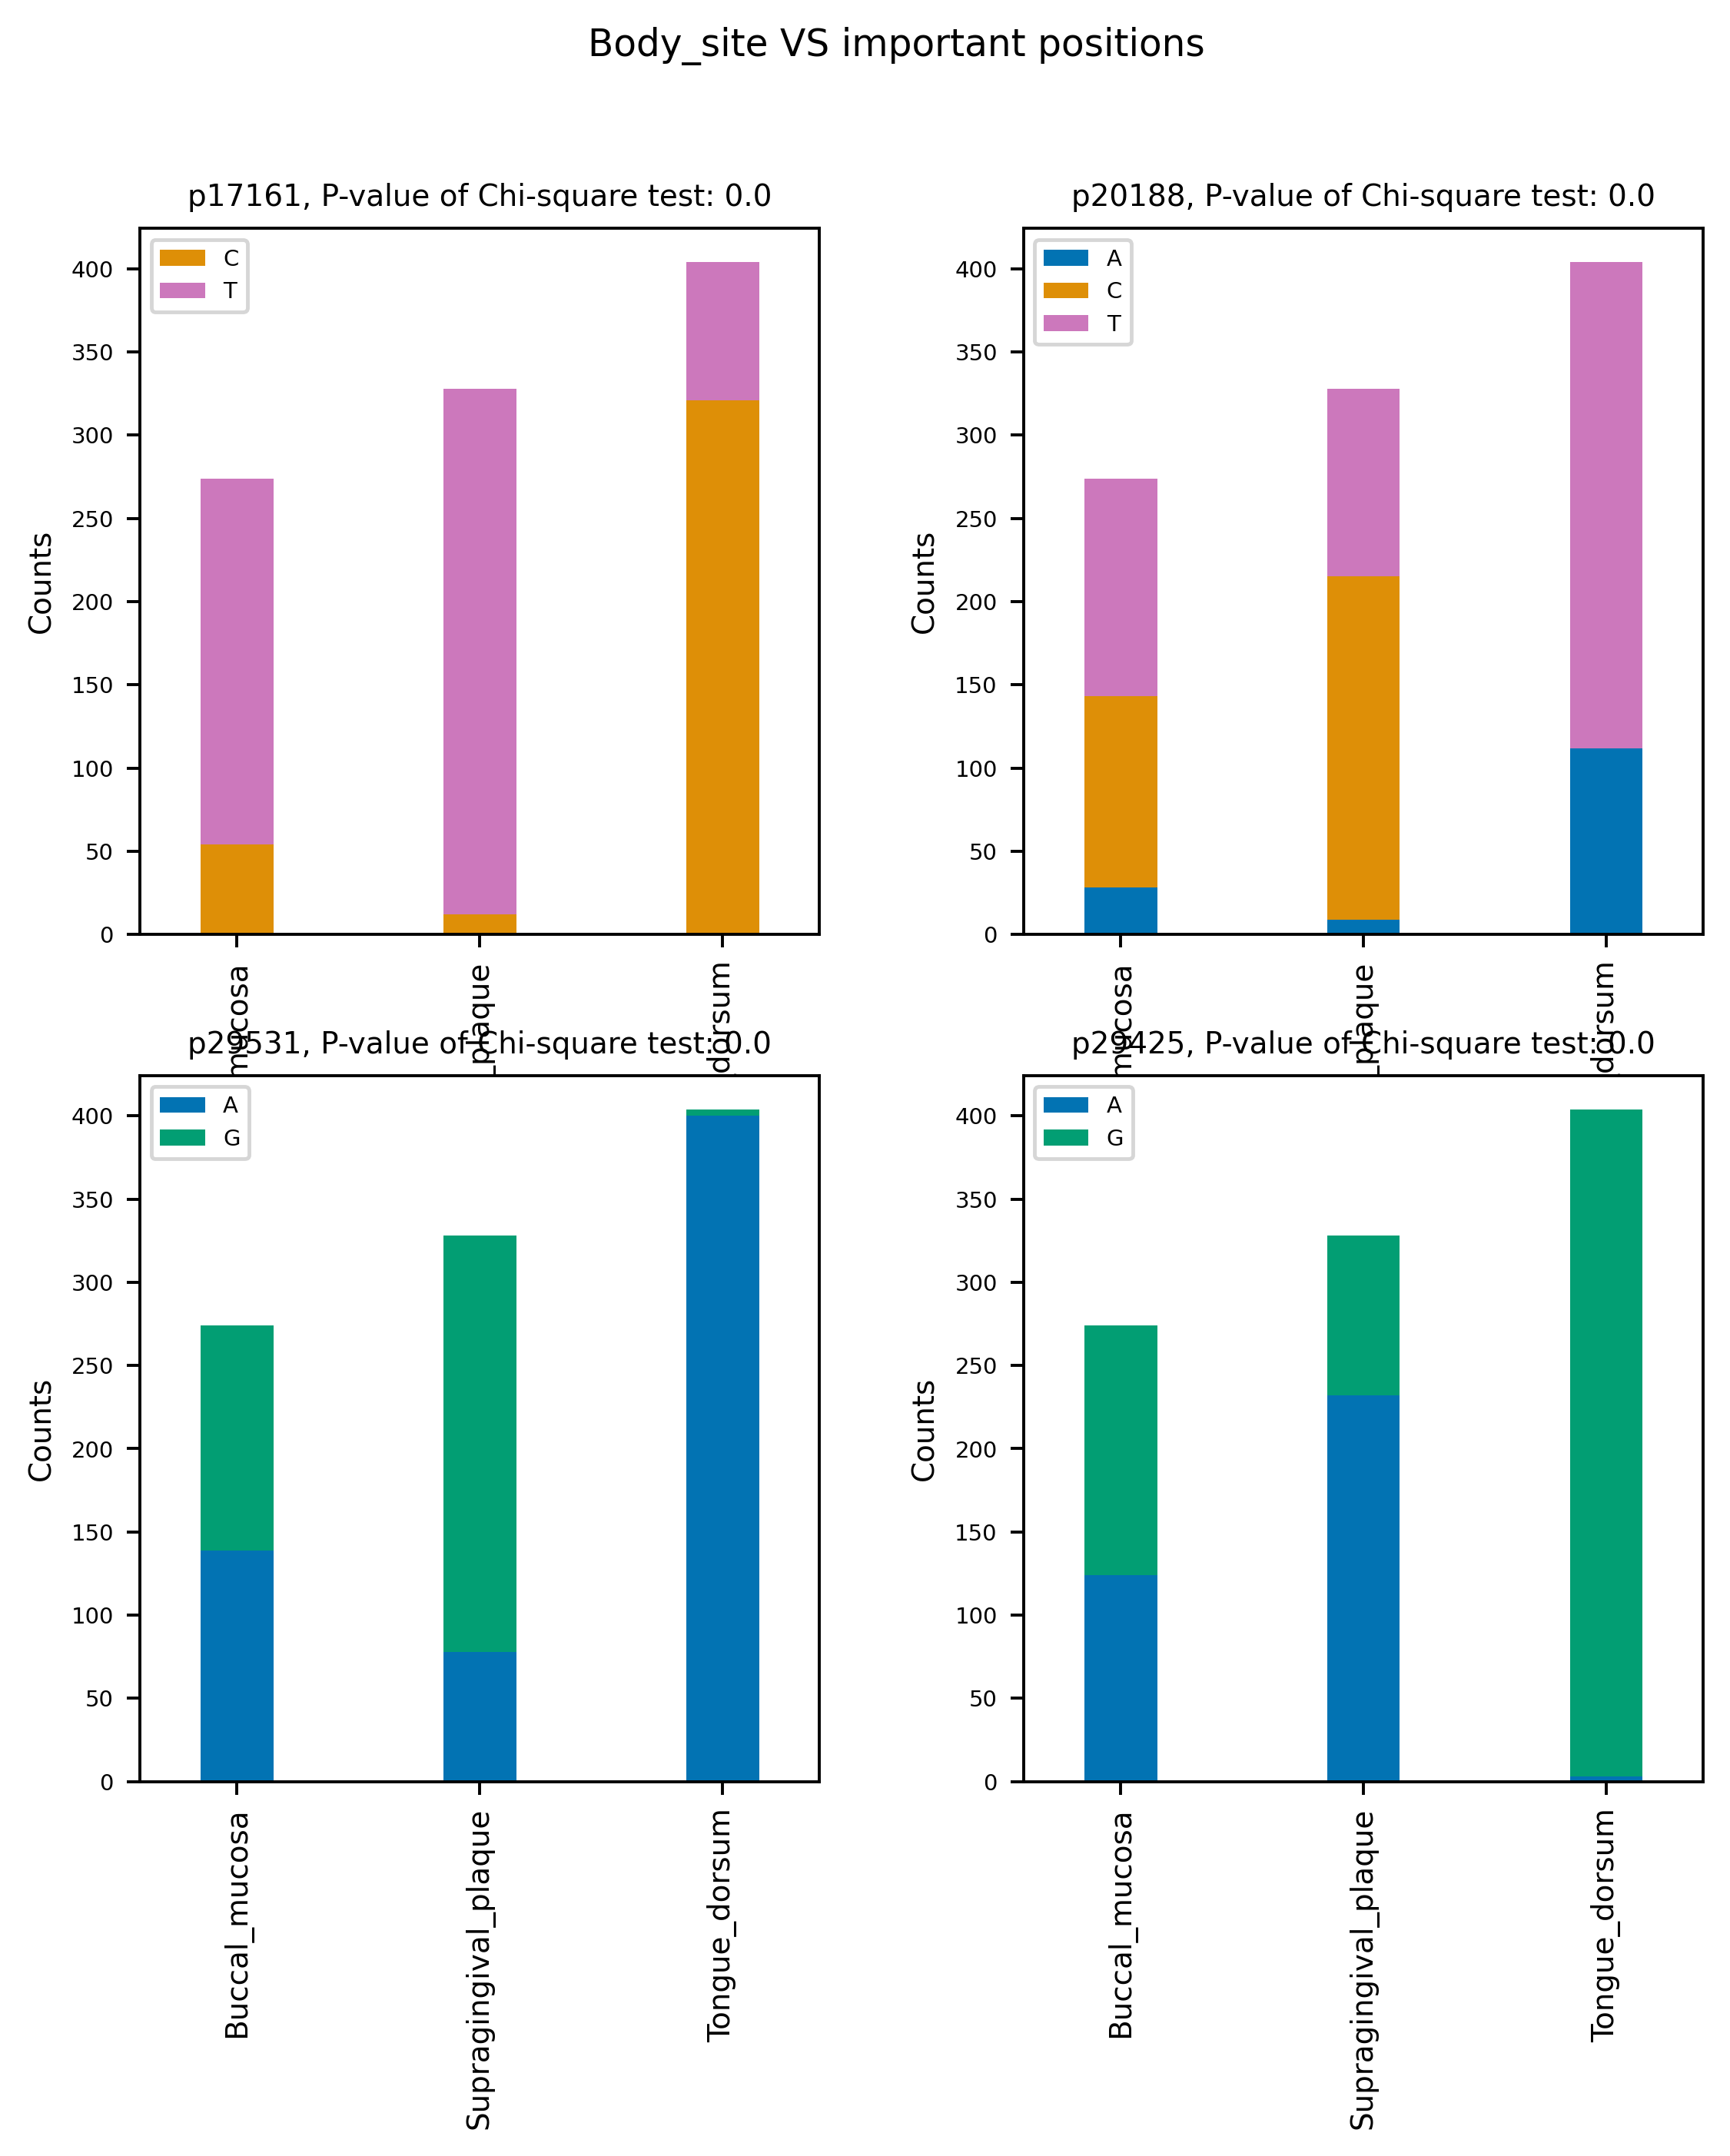

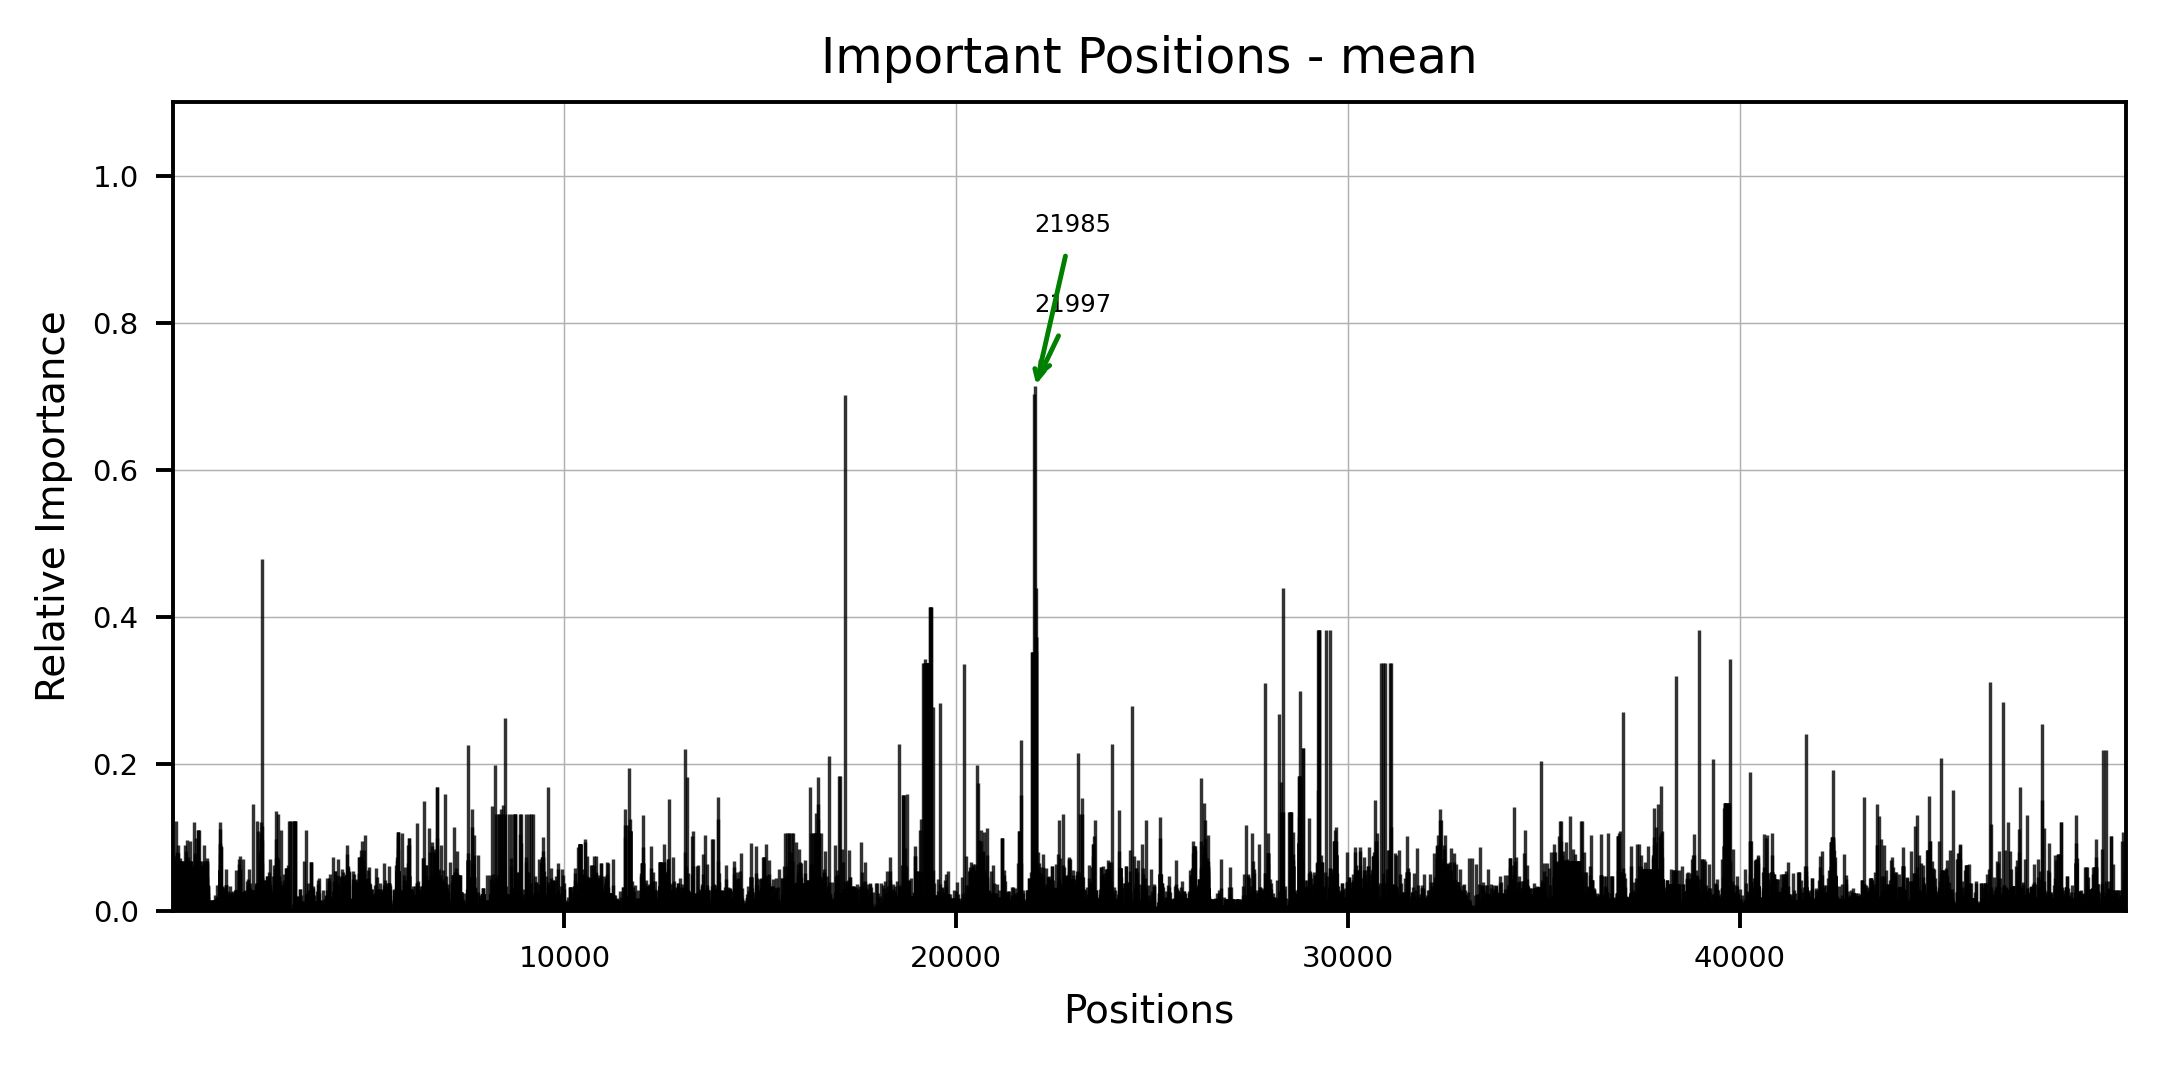

In [26]:
for key in trained_models.keys():
    if key == 'mean':
        # plot the mean importance
        viz.dp_plot(importance=trained_models[key], imp_col='mean', model_name=key, annotate=2, report_dir=report_dir)
    else:
        # importance plot (barplot)
        viz.dp_plot(importance= trained_models[key]['importance'], imp_col='standard_value', 
                model_name=key, annotate=2,report_dir=report_dir)
        # top 4 position from each model
        viz.plot_imp_model(importance=trained_models[key]['importance'],
                           X_train=df.loc[:, df.columns != mt],
                           y_train=df.loc[:, mt],
                           model_name=key, meta_var=mt, model_type=anaType,
                           report_dir=report_dir)

**Running the next cell will produce individual plots for all of the positions in you sequence.**

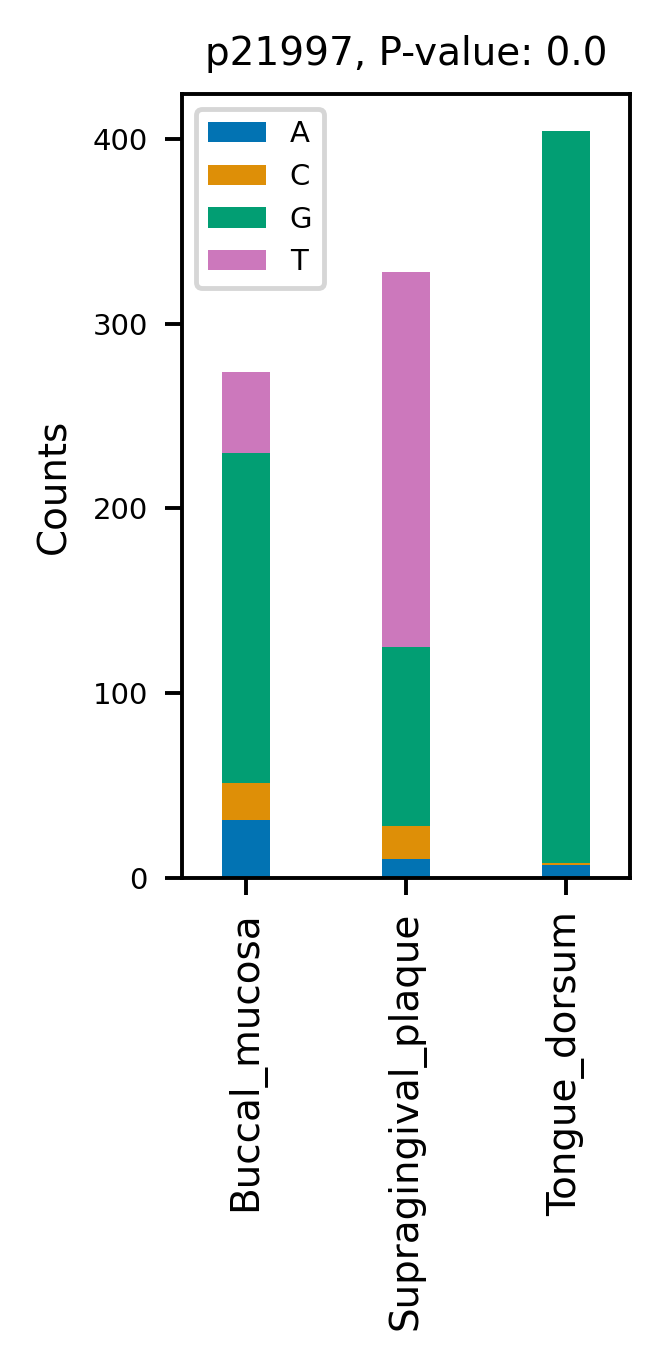

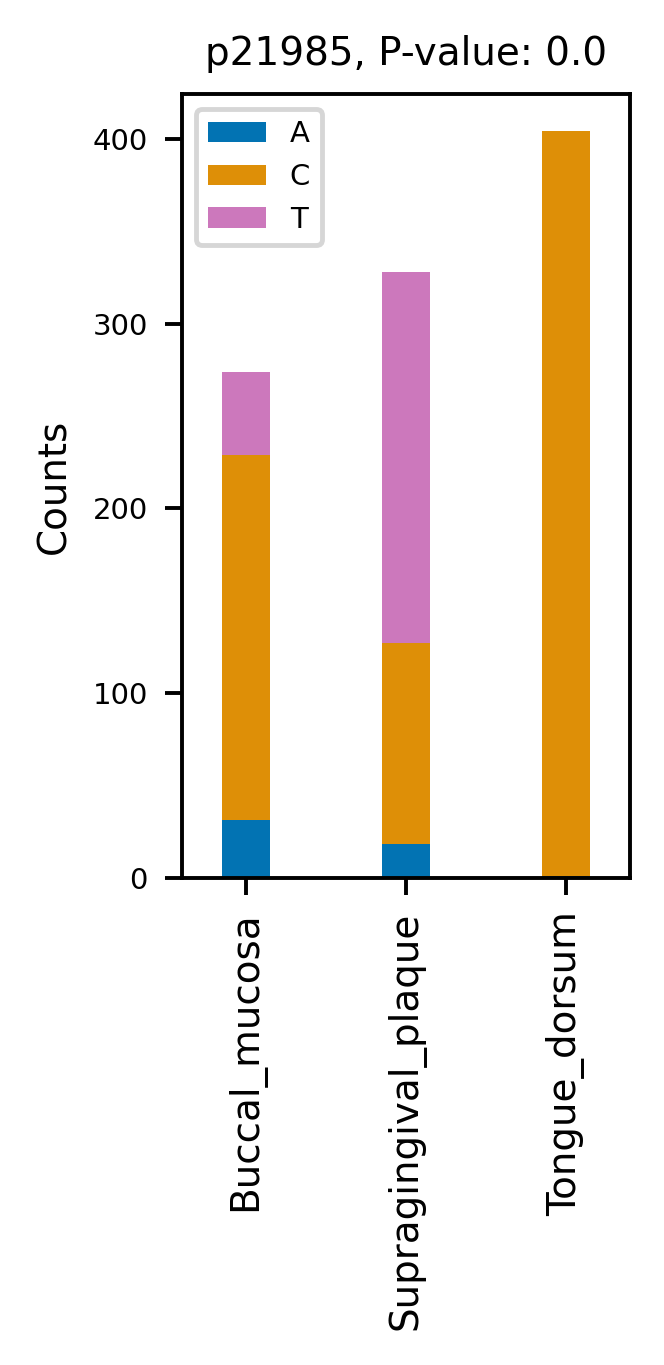

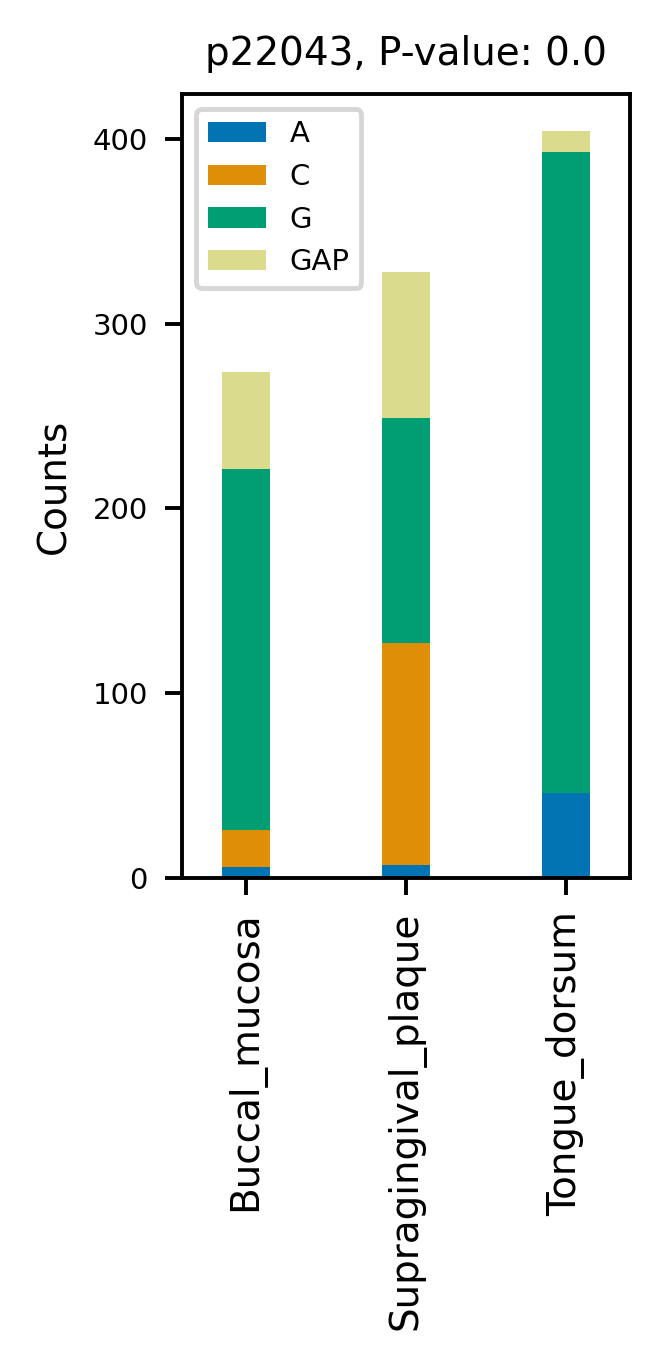

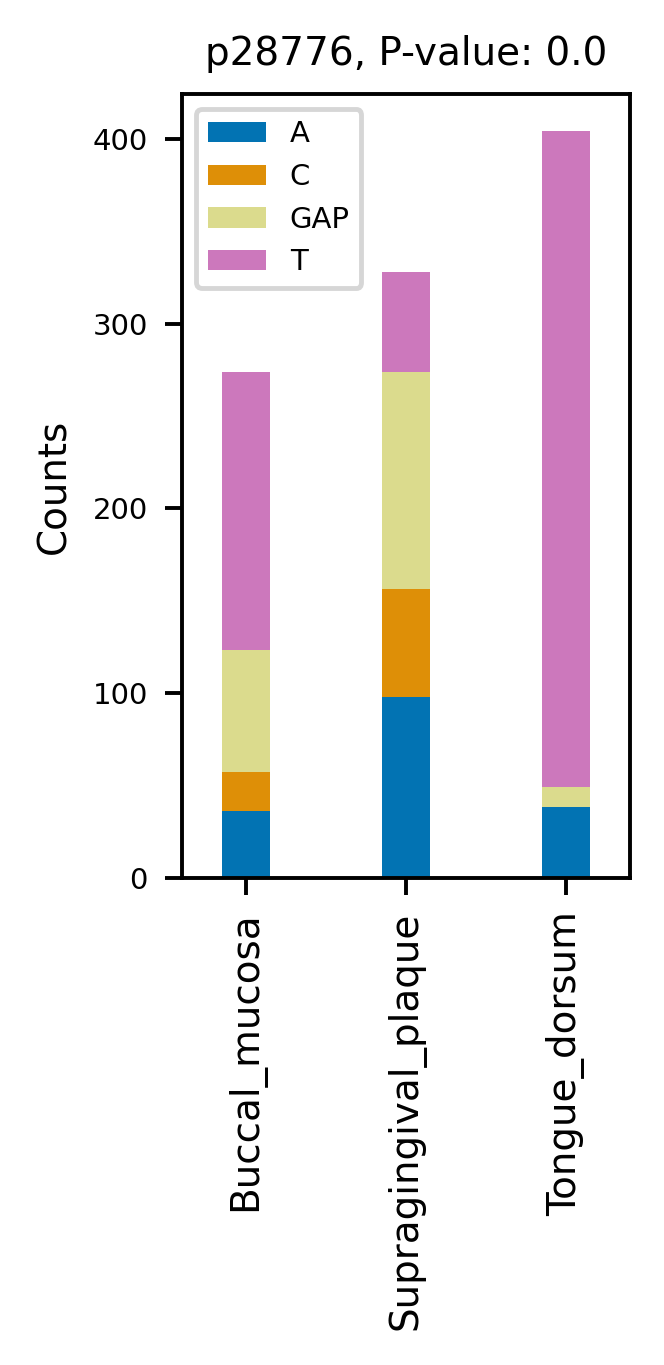

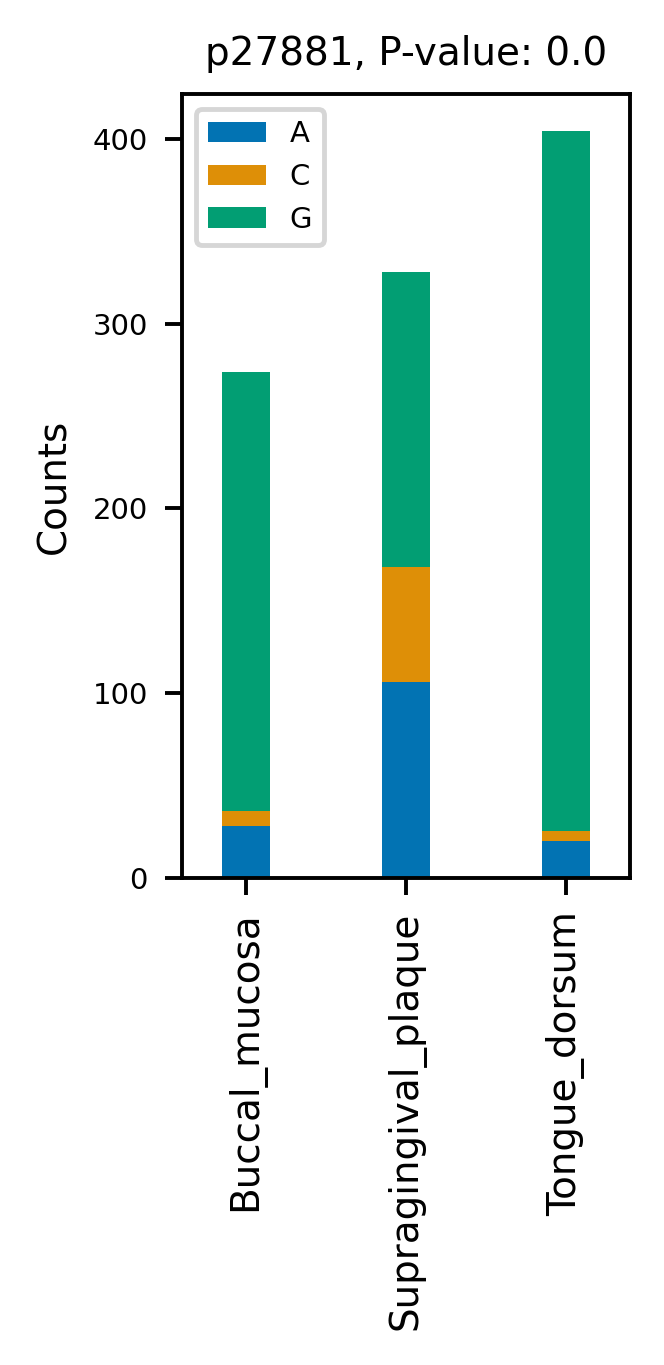

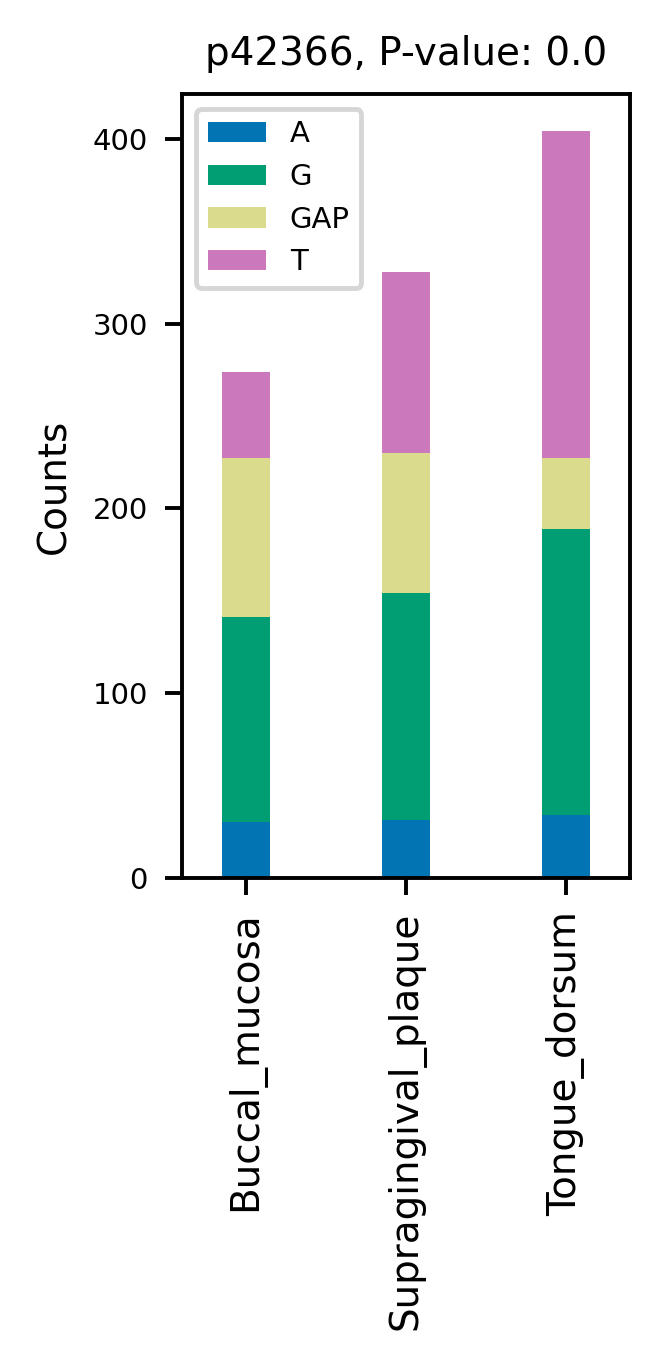

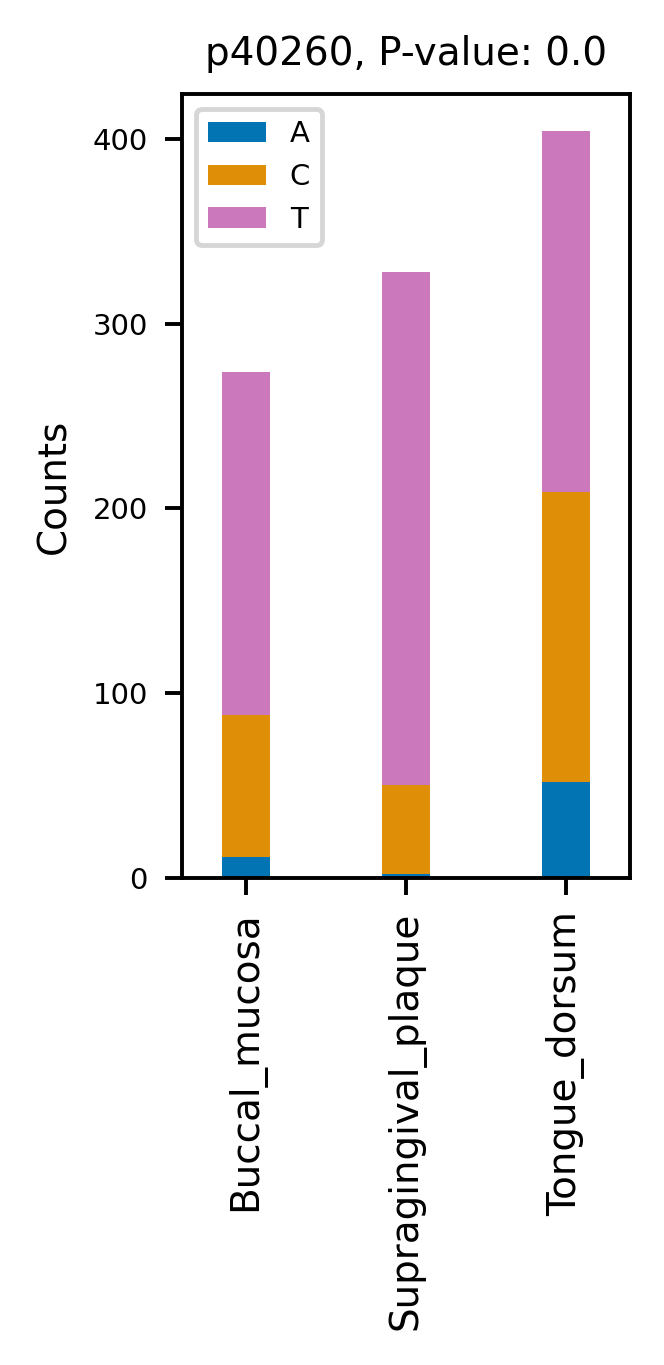

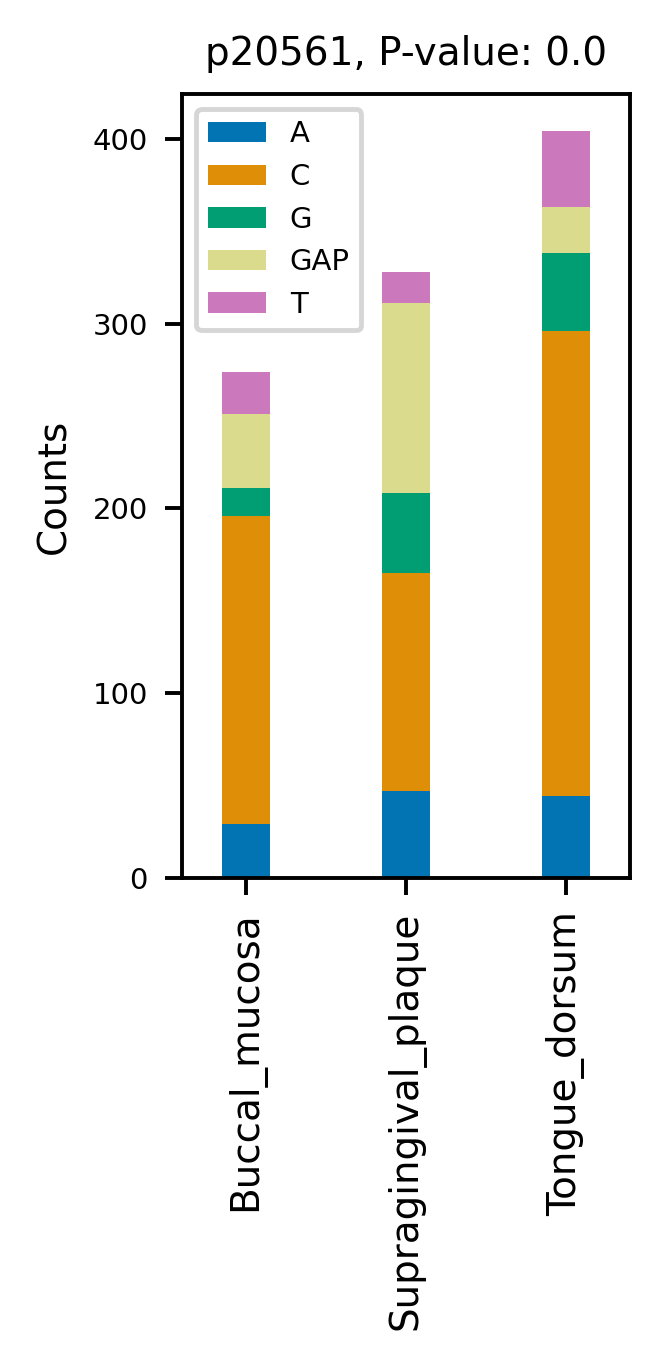

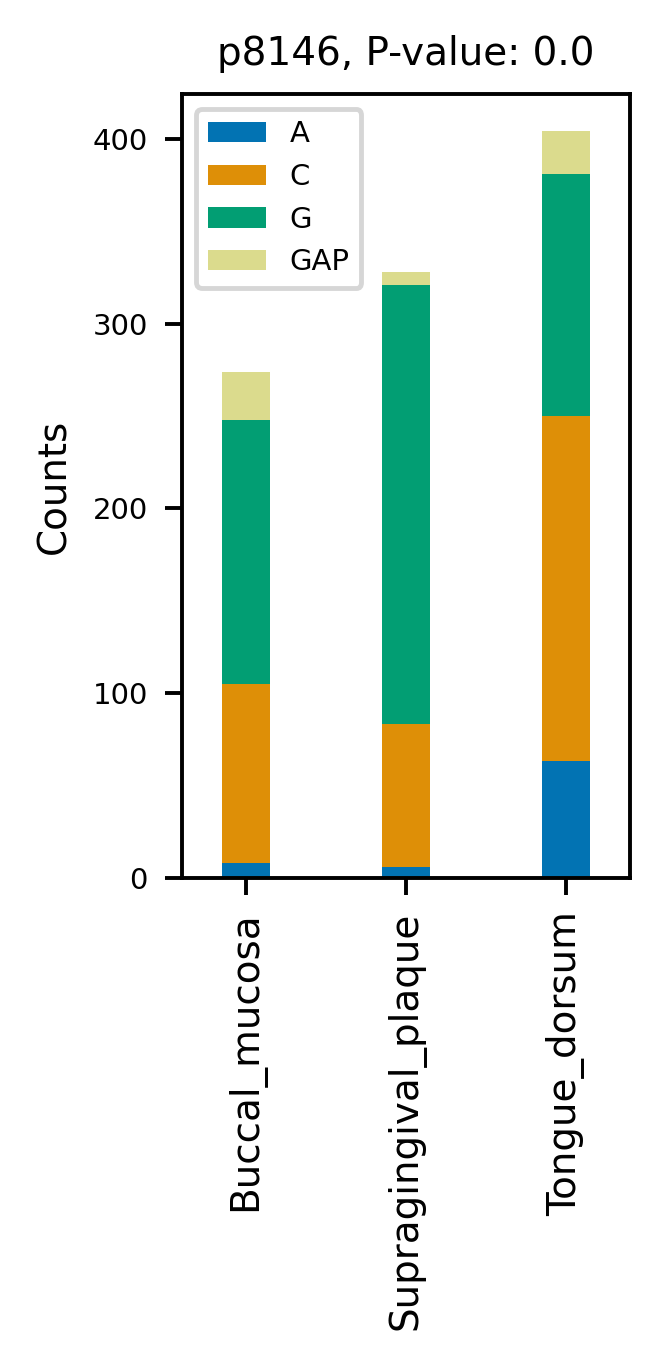

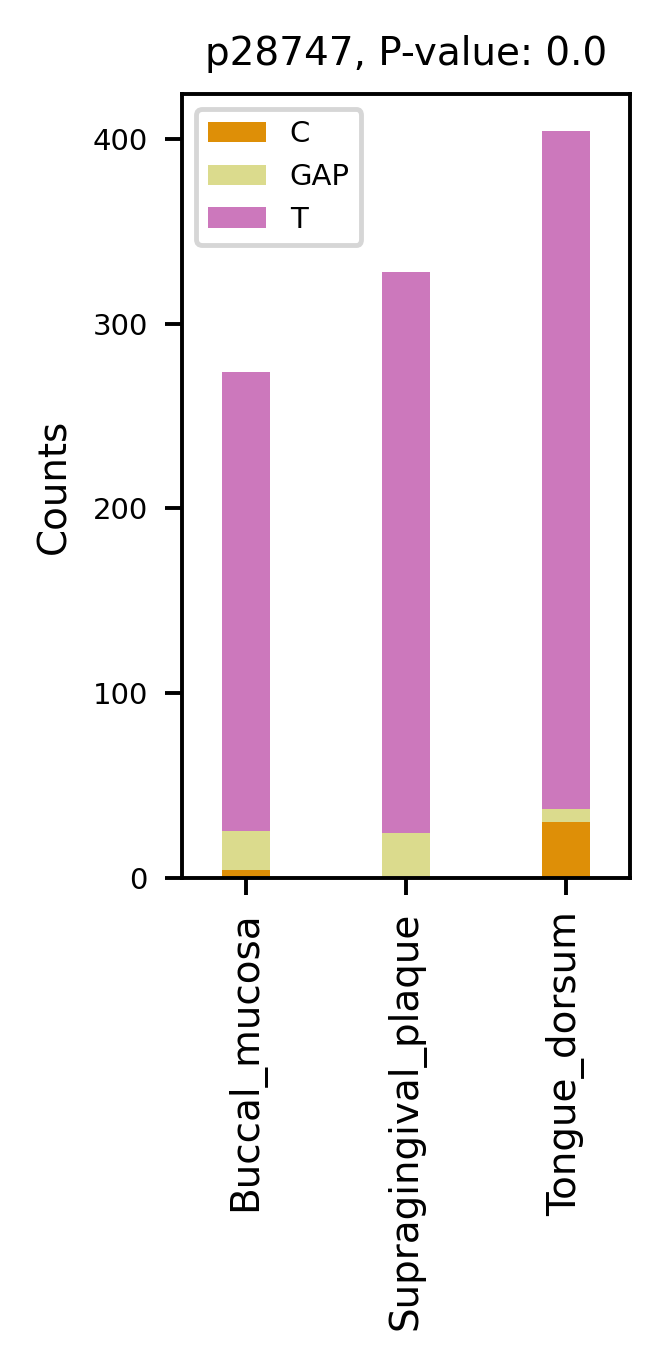

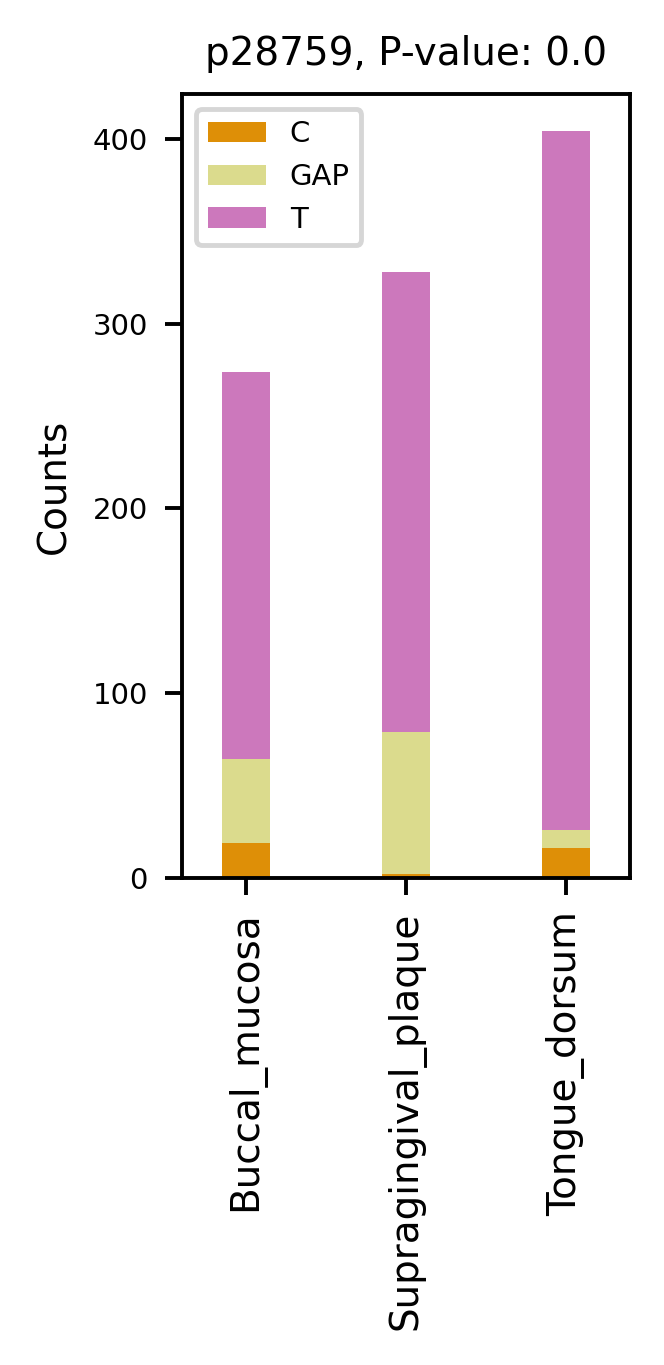

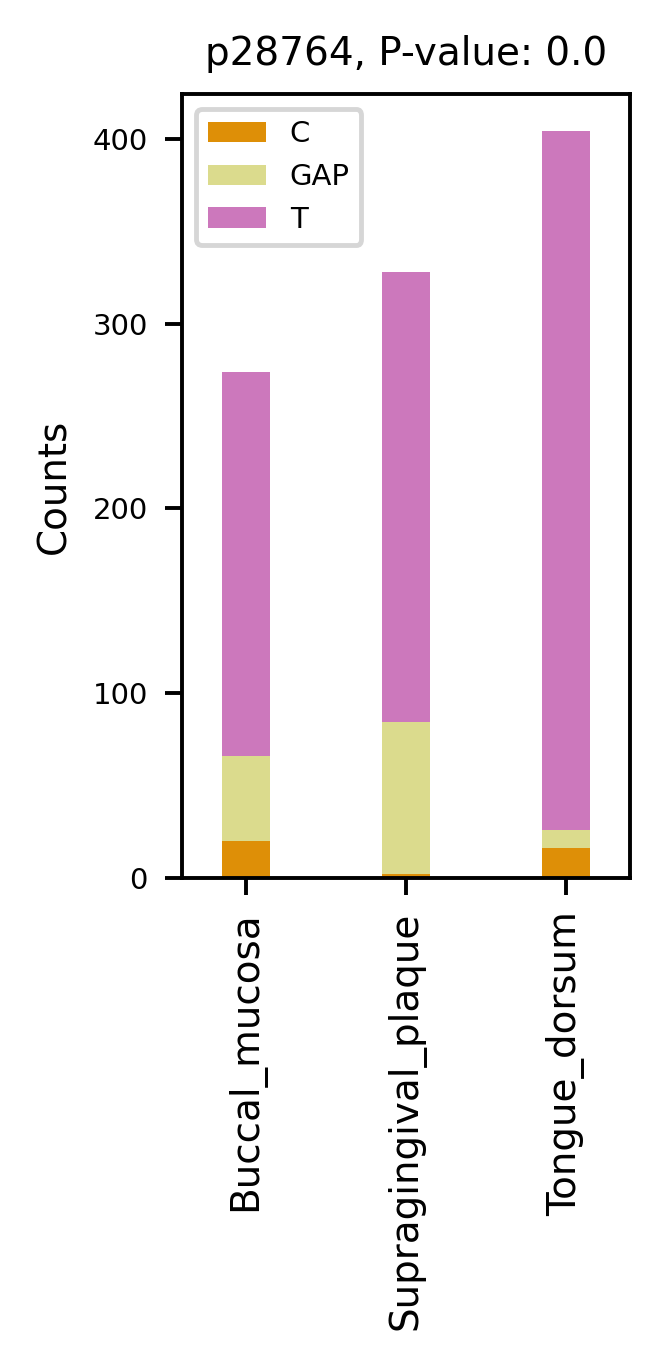

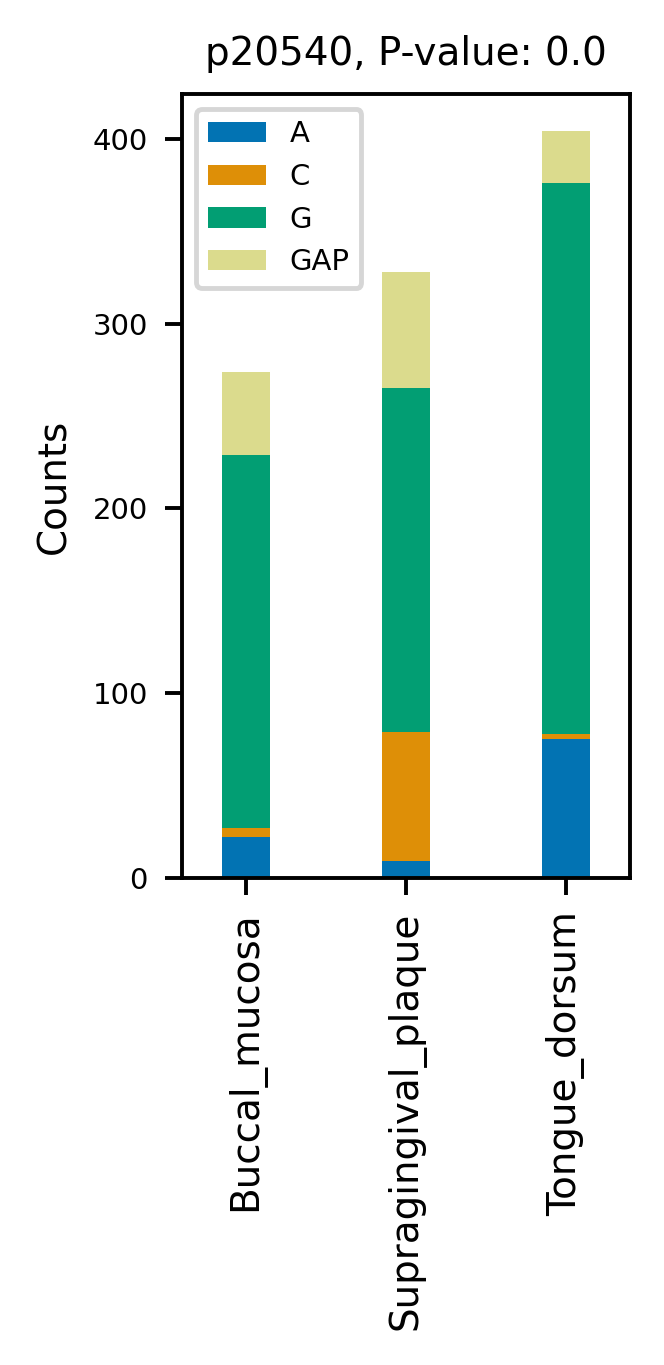

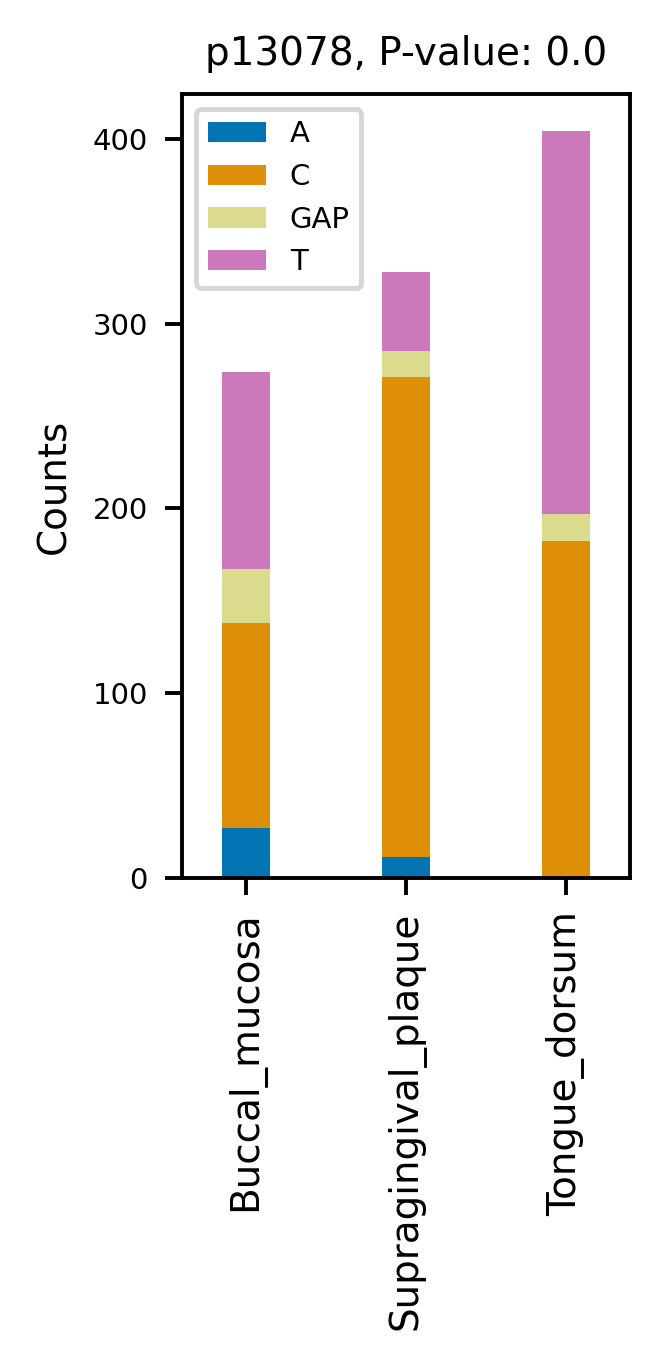

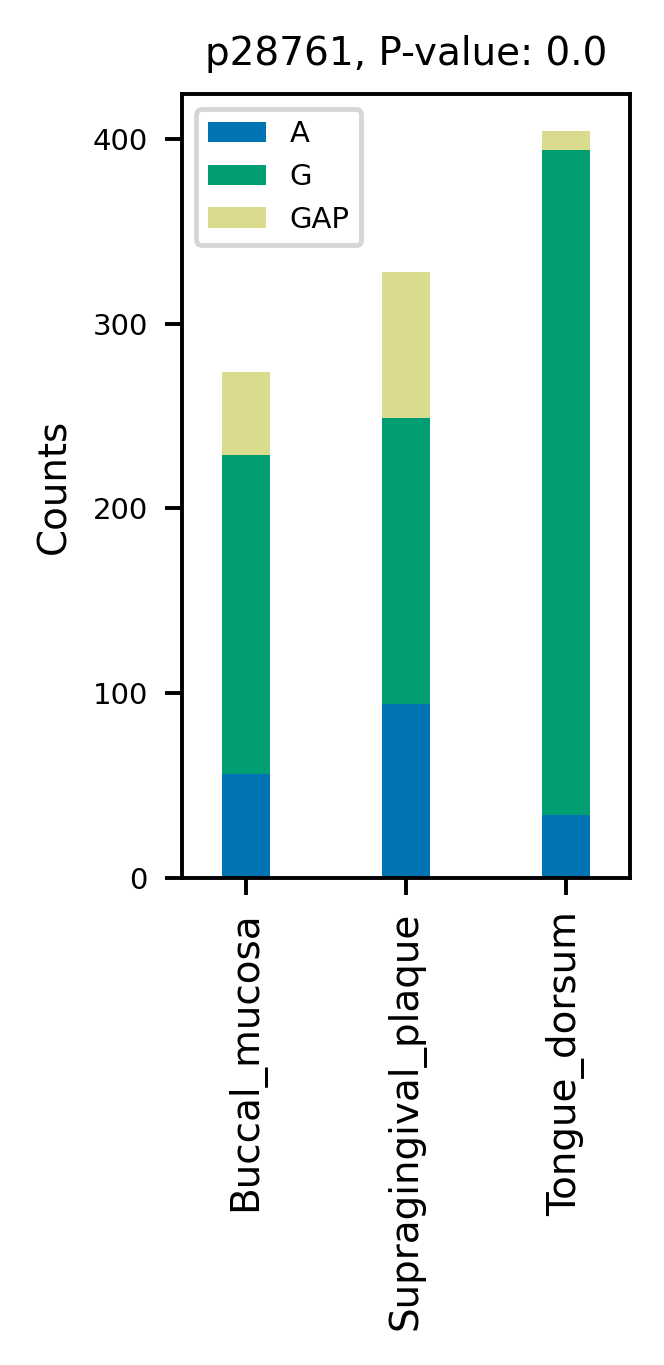

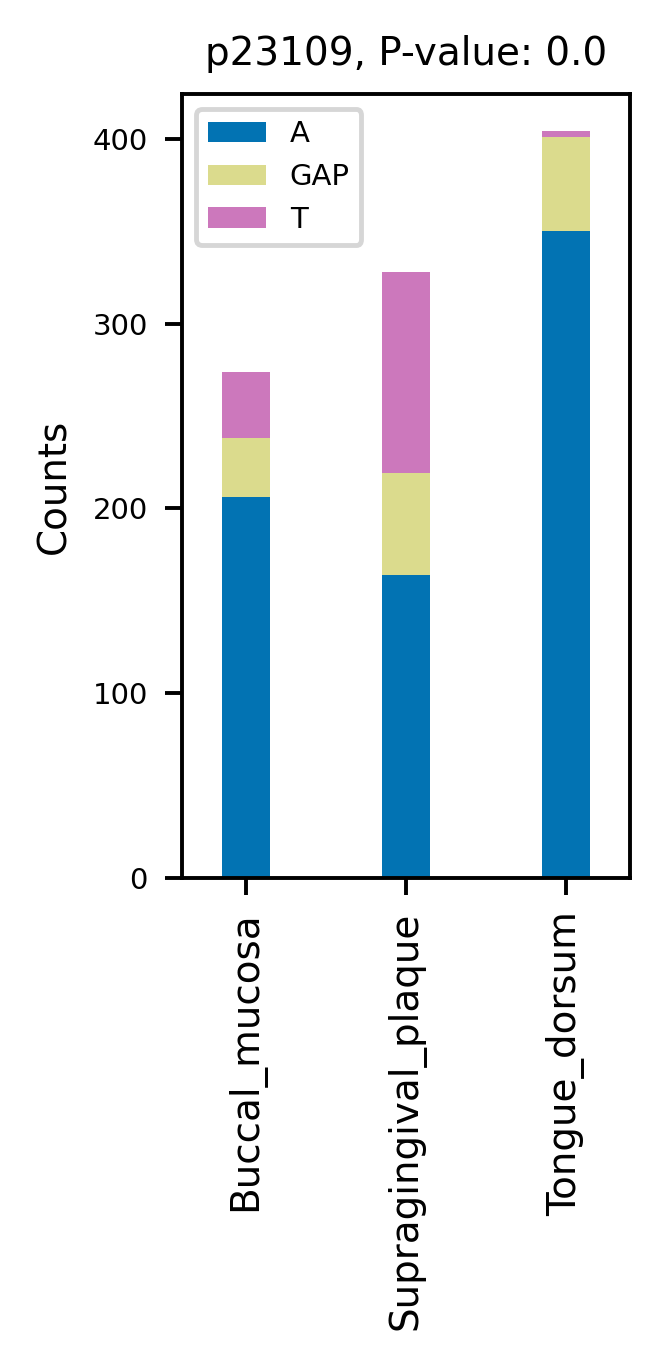

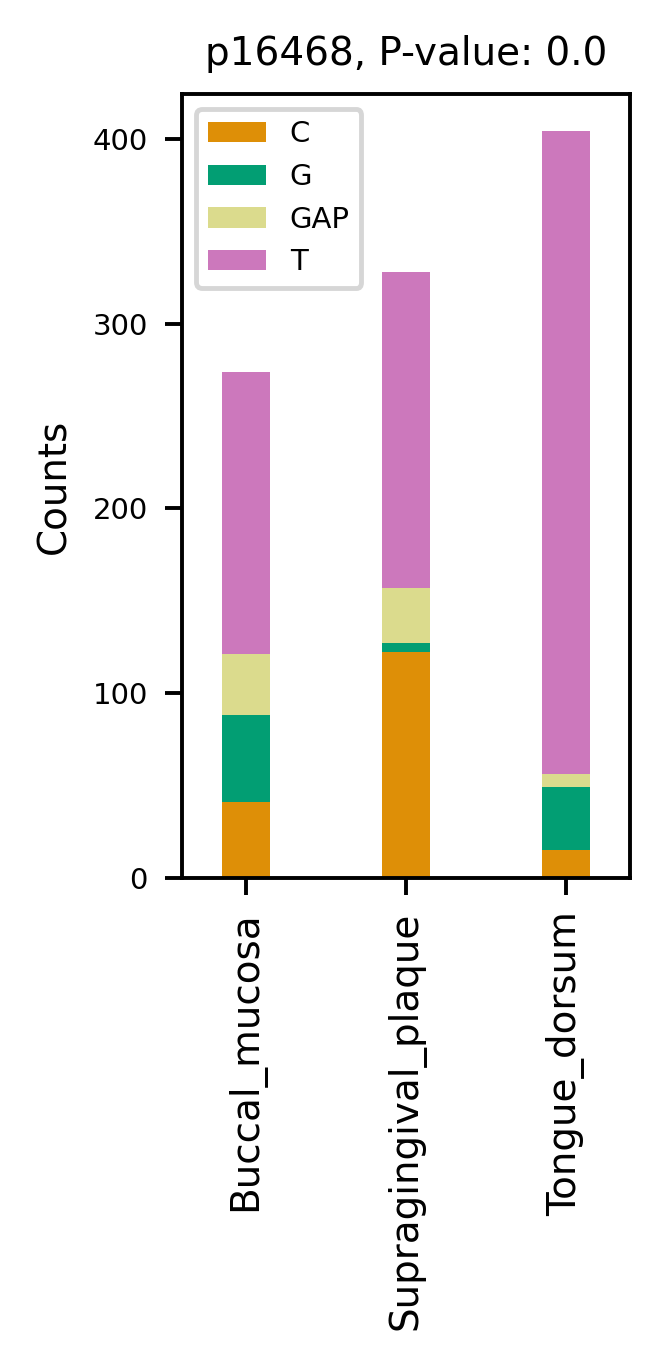

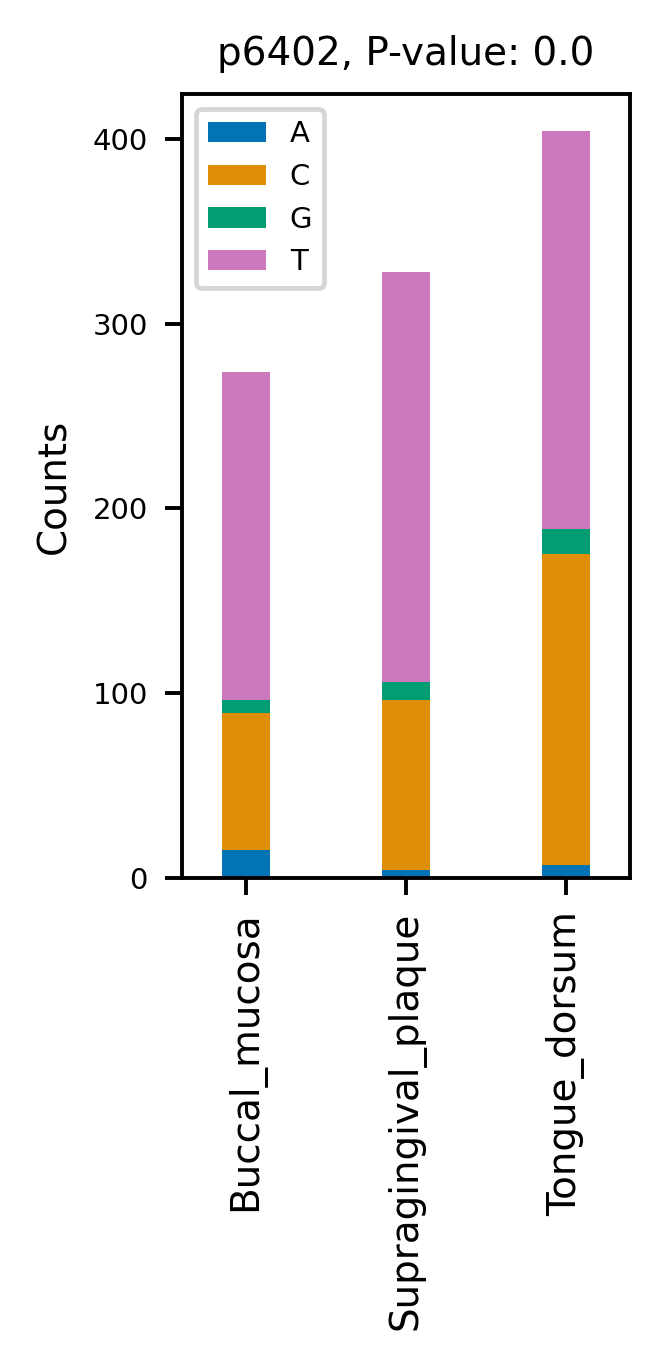

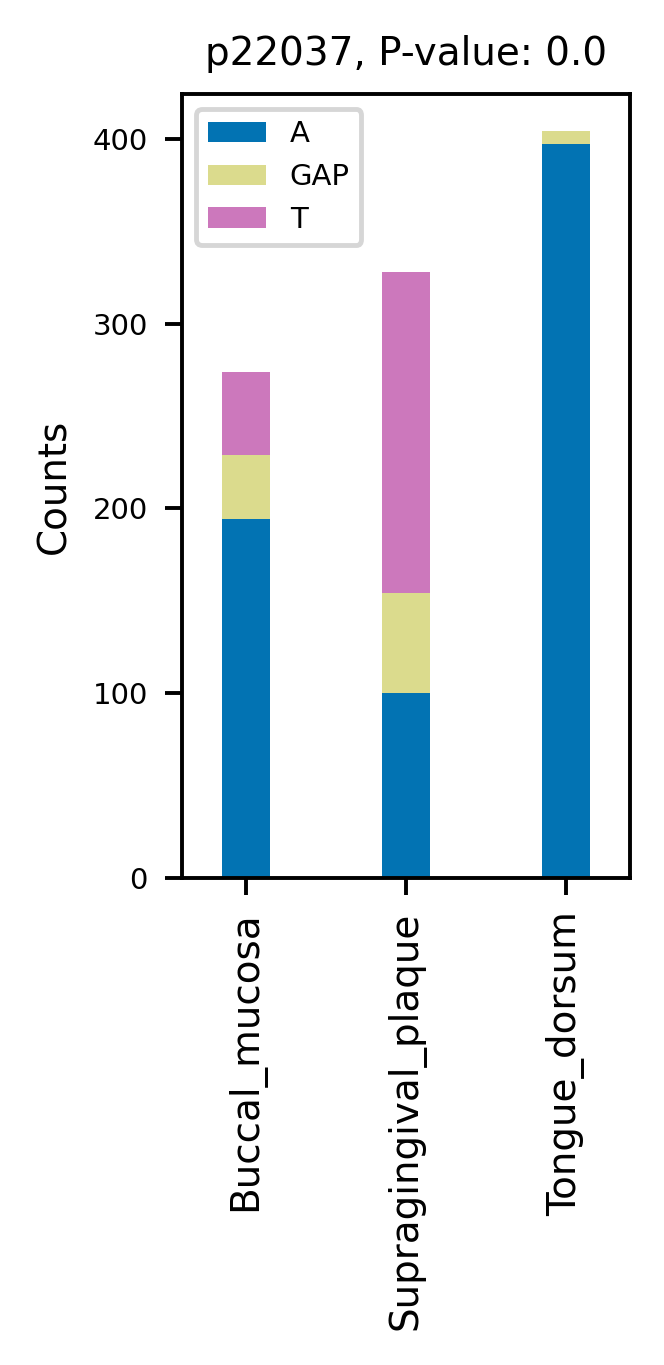

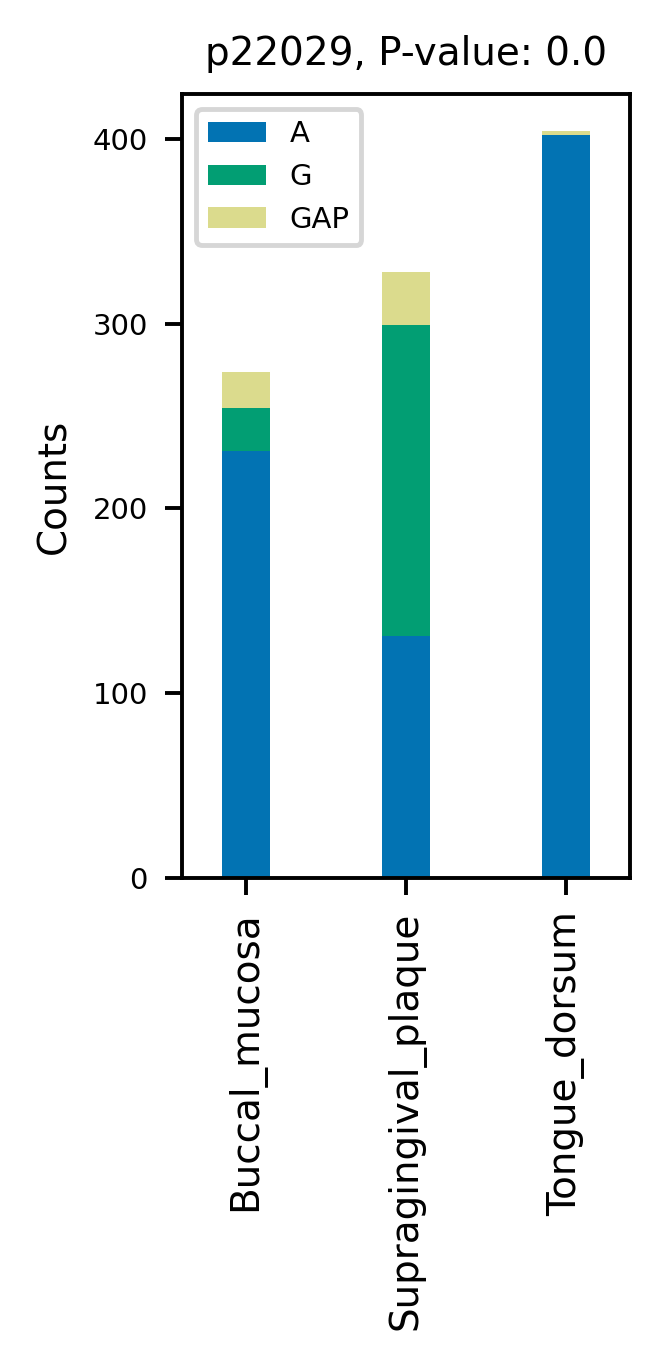

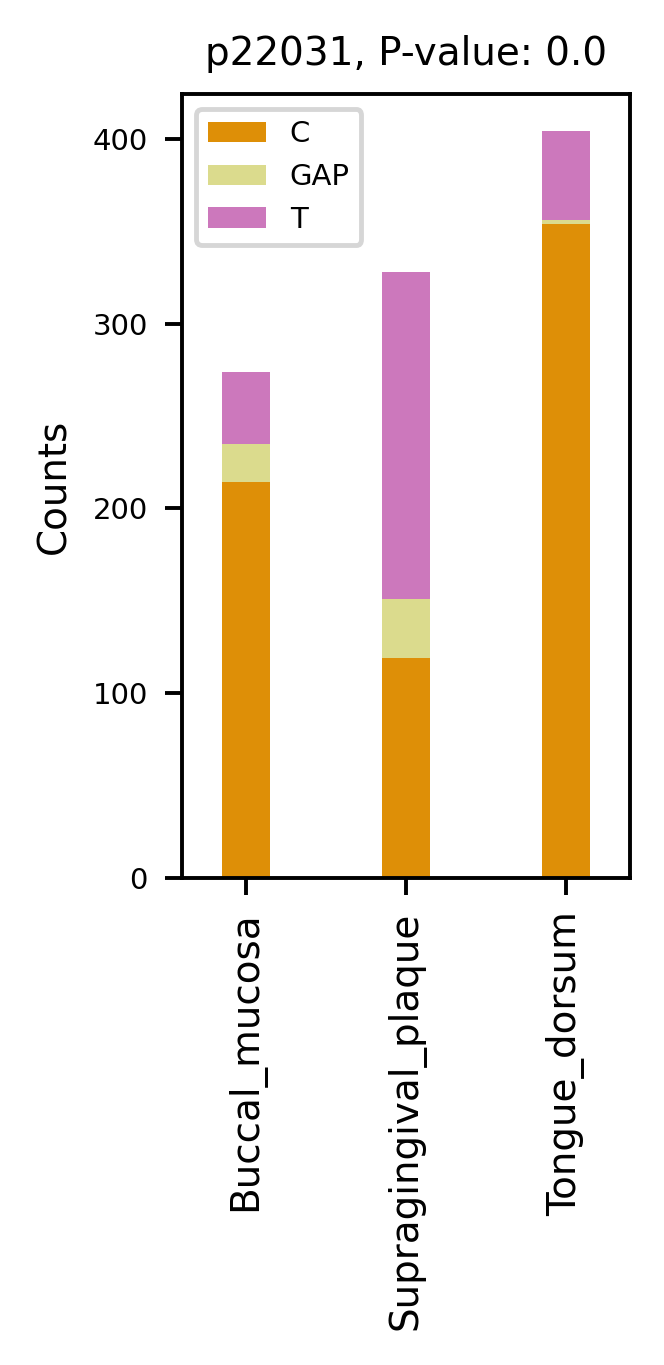

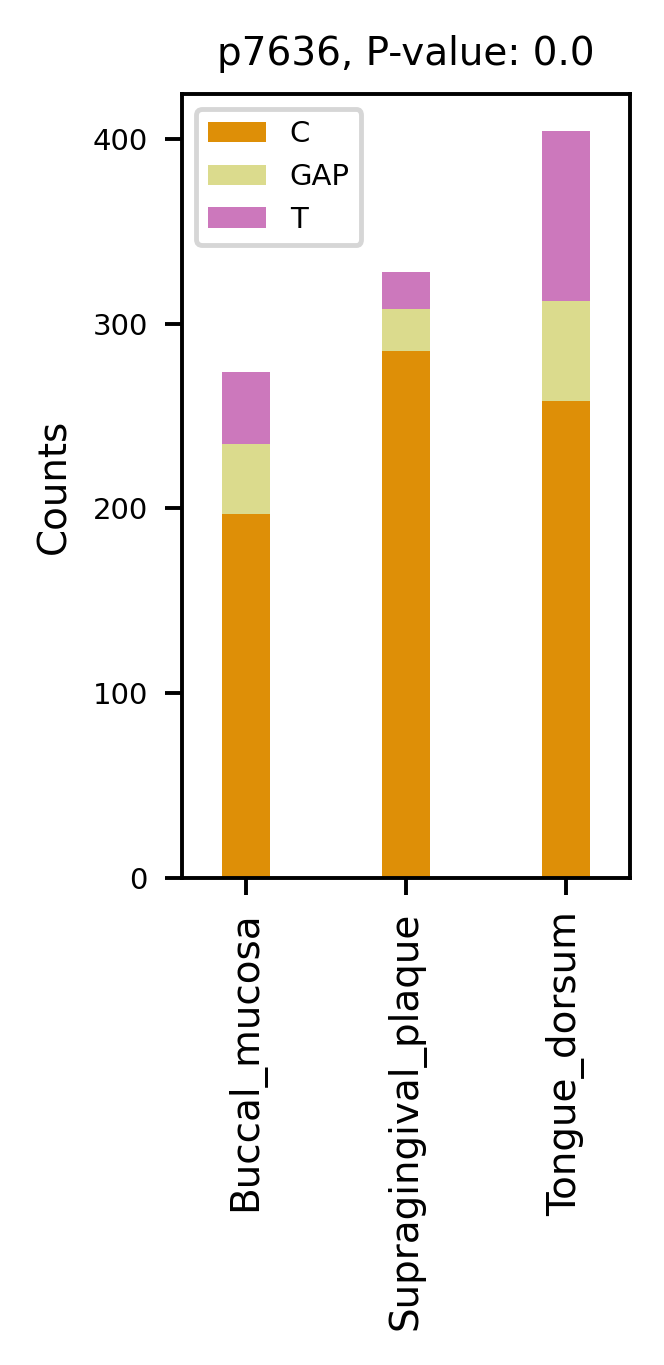

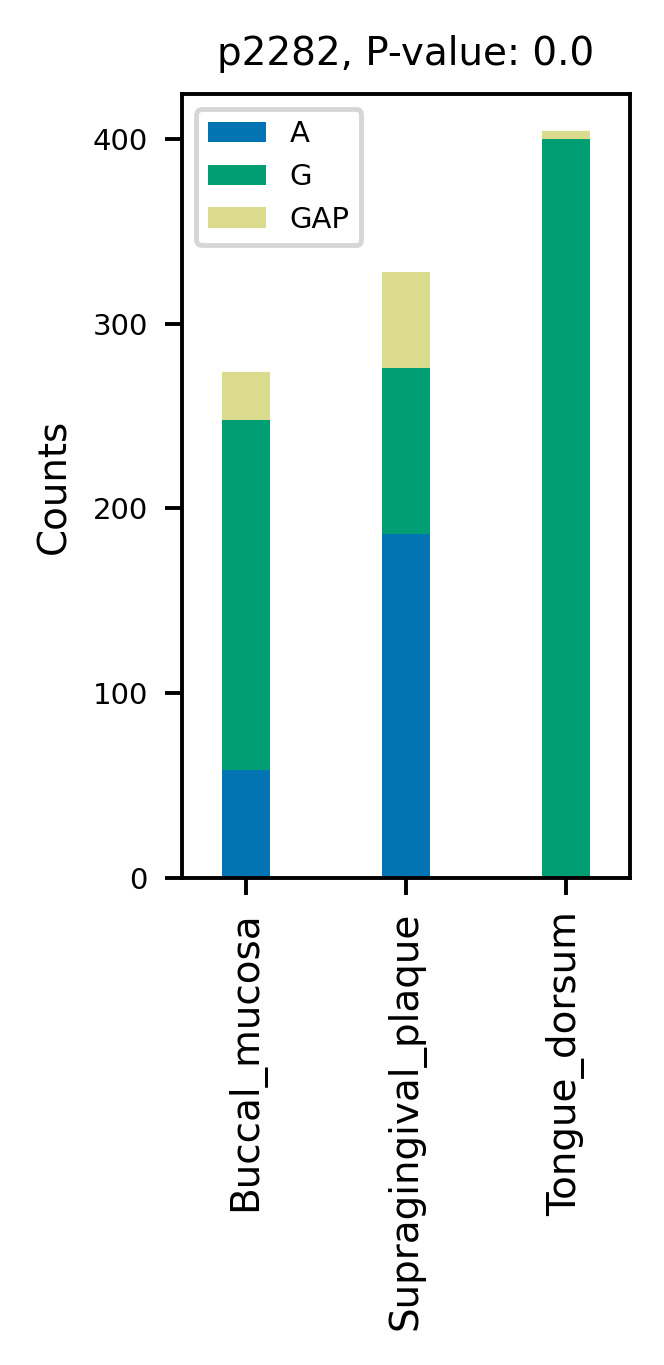

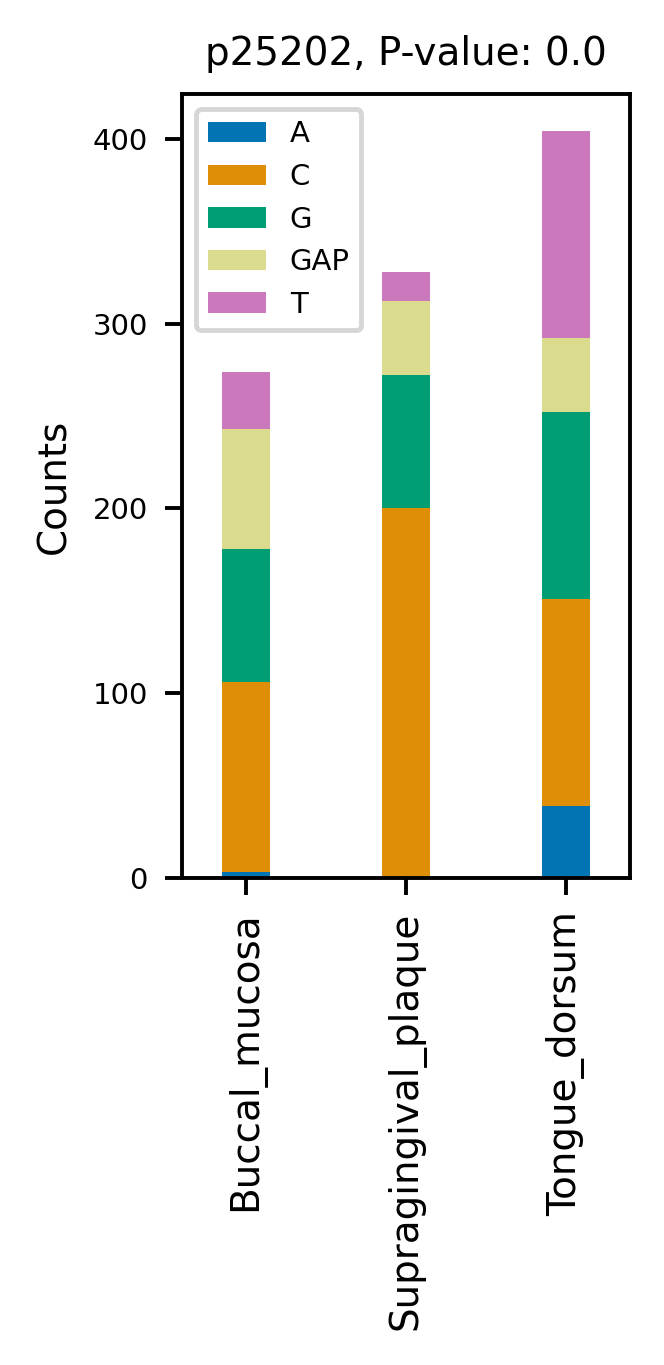

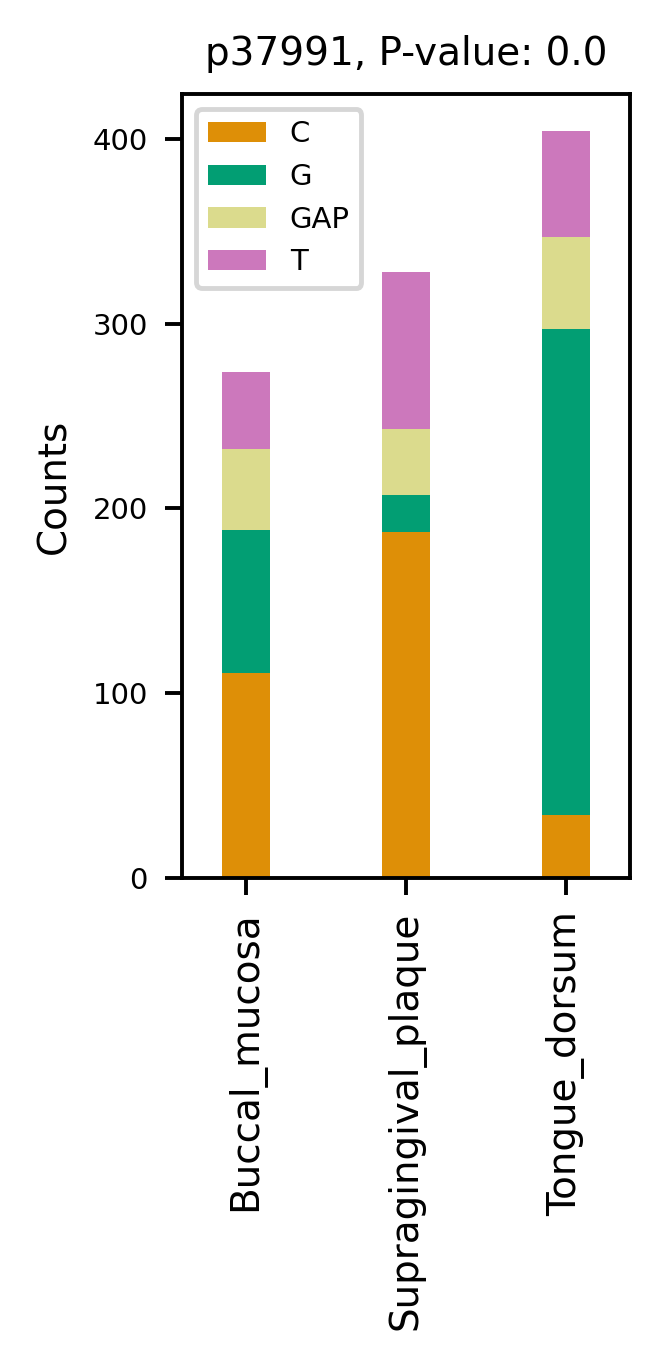

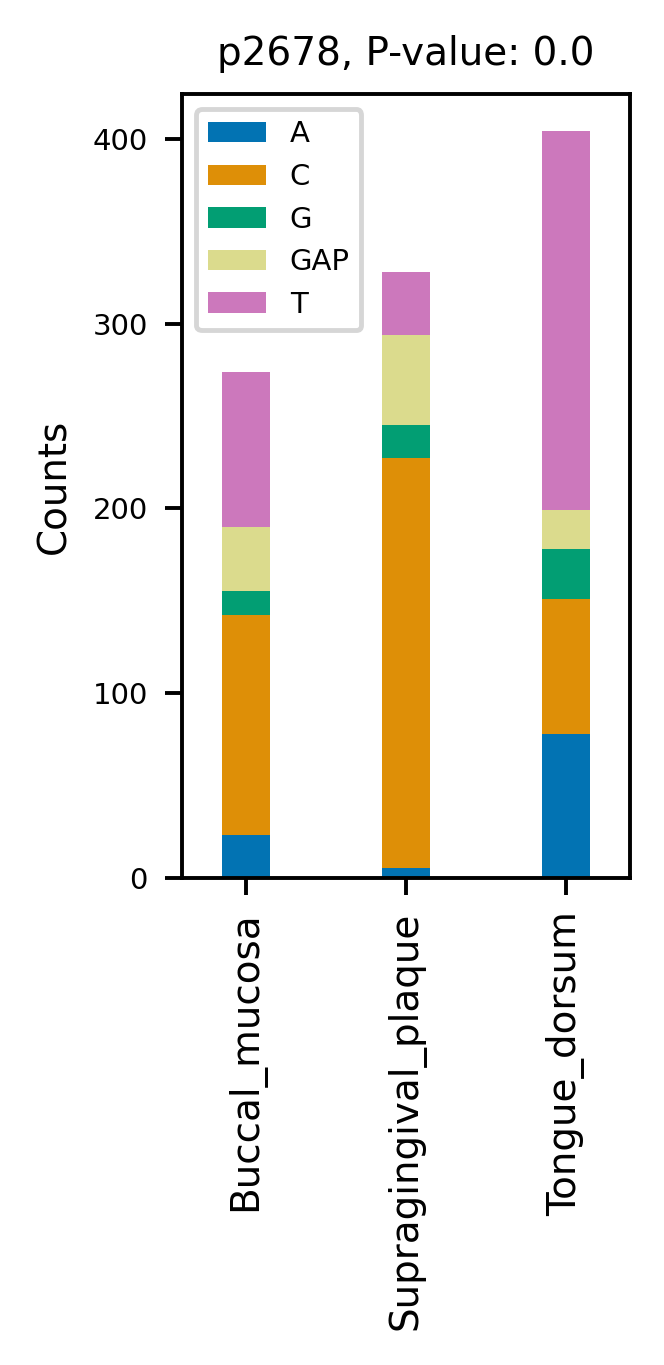

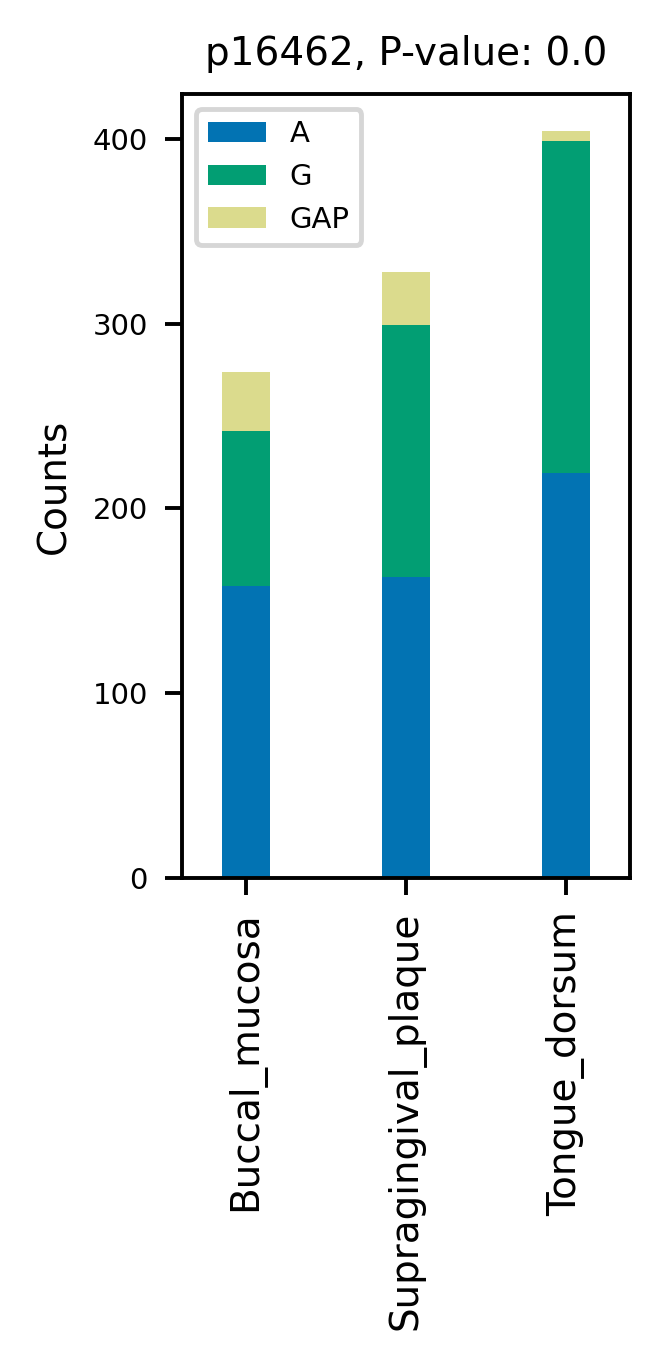

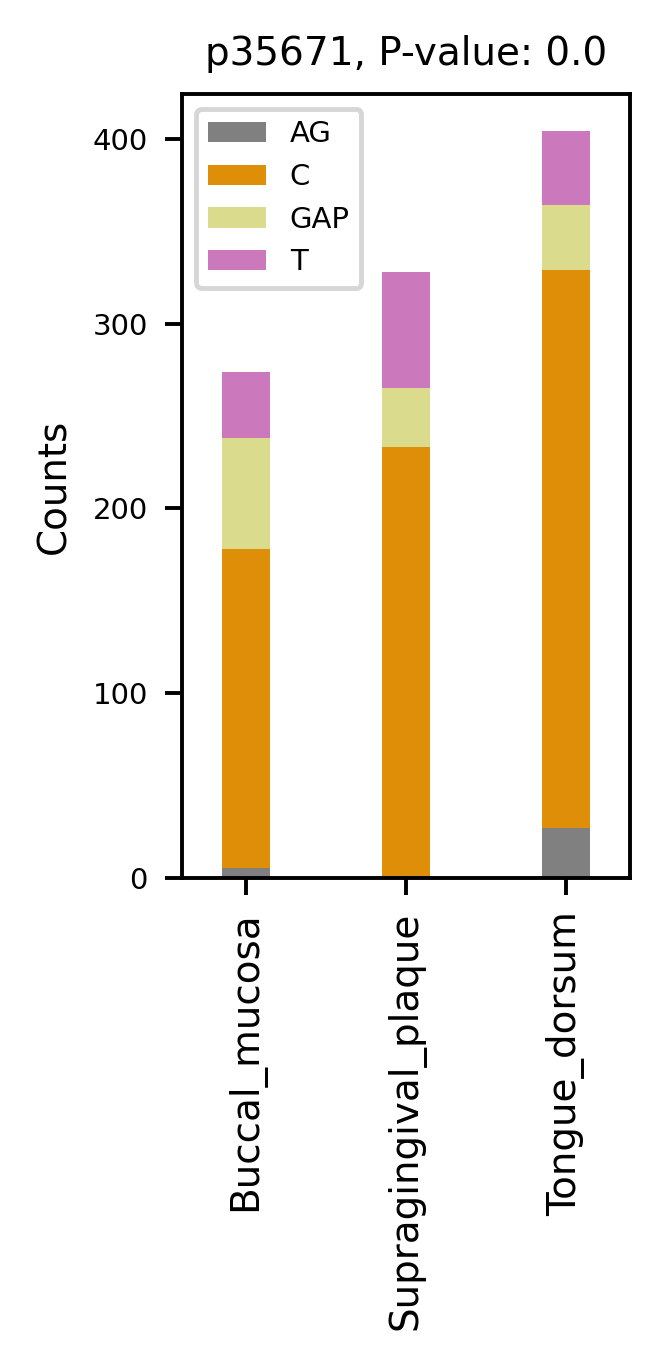

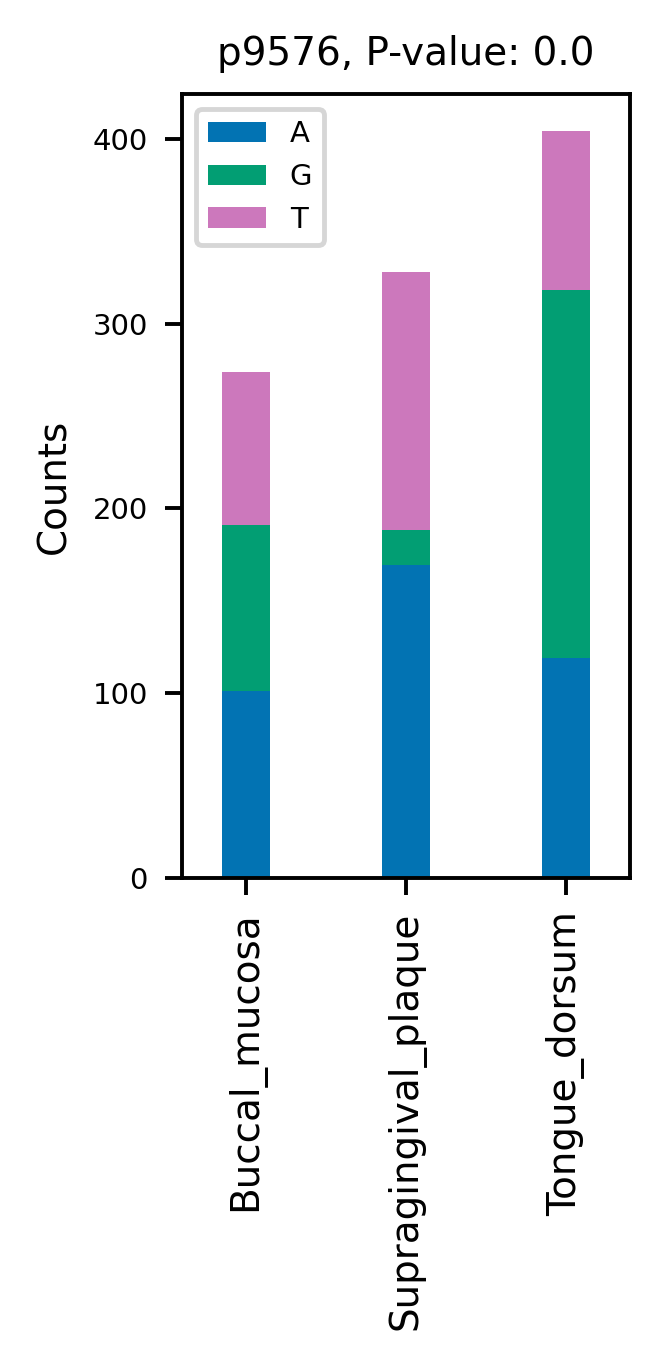

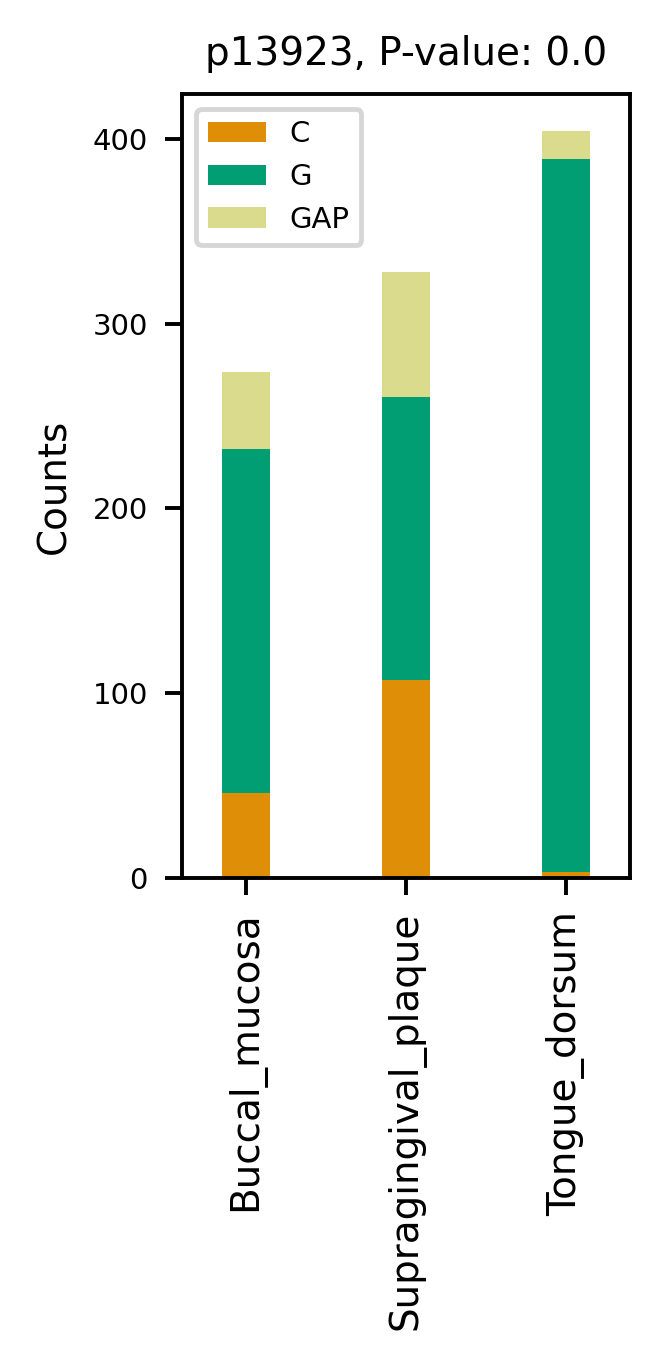

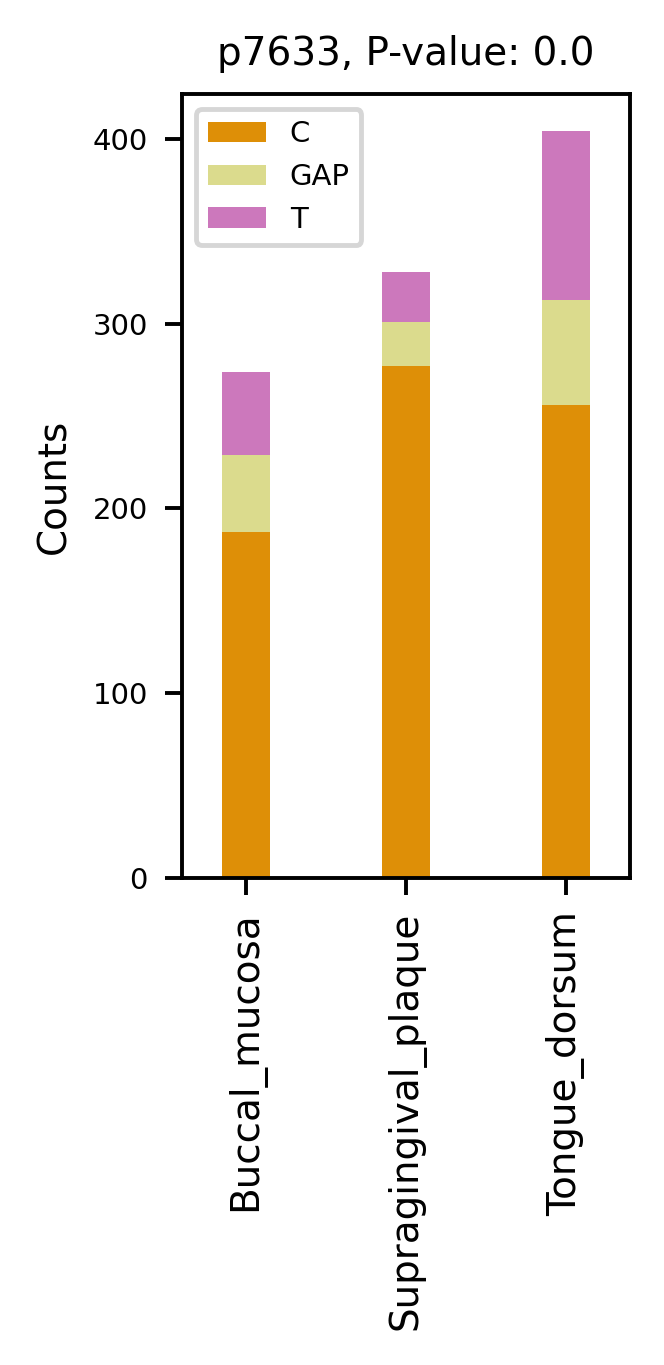

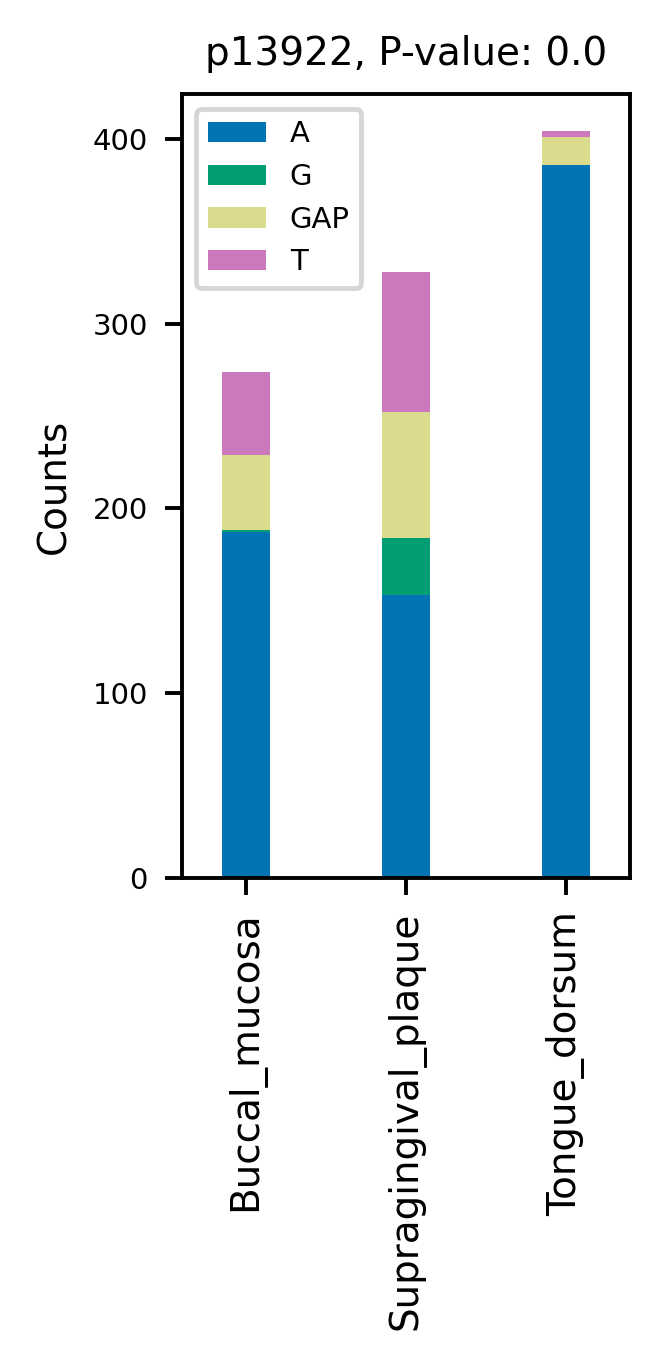

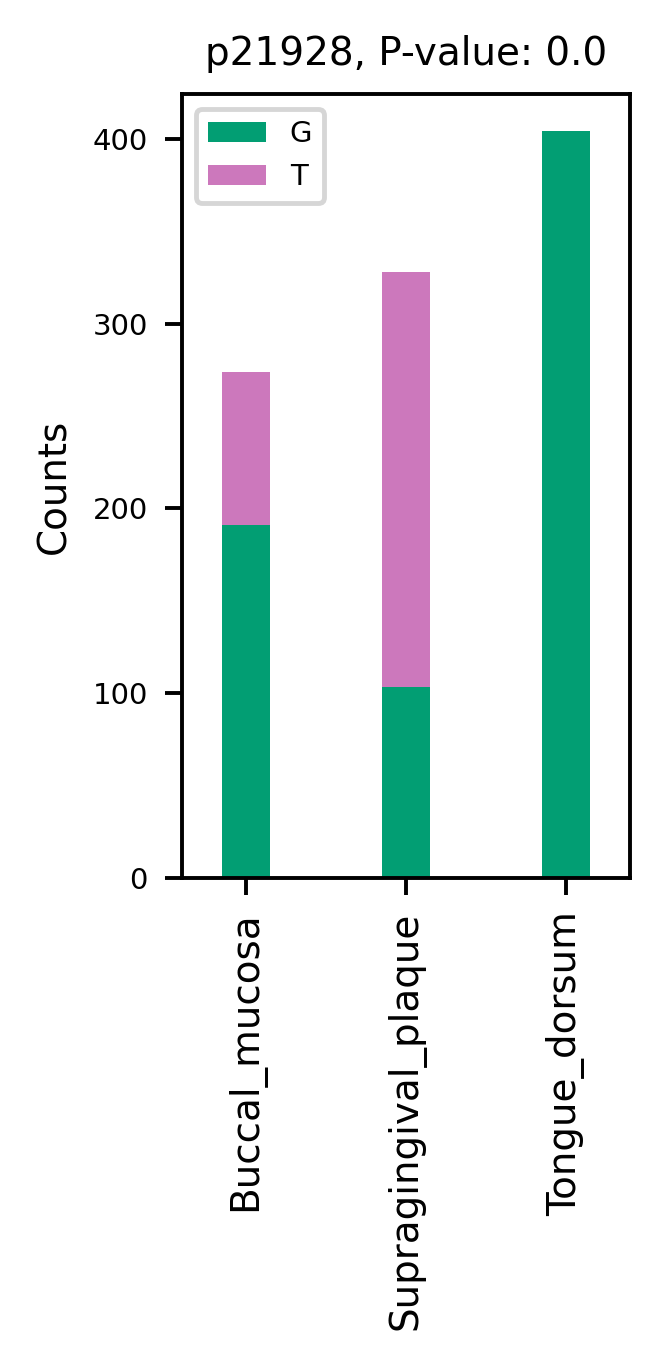

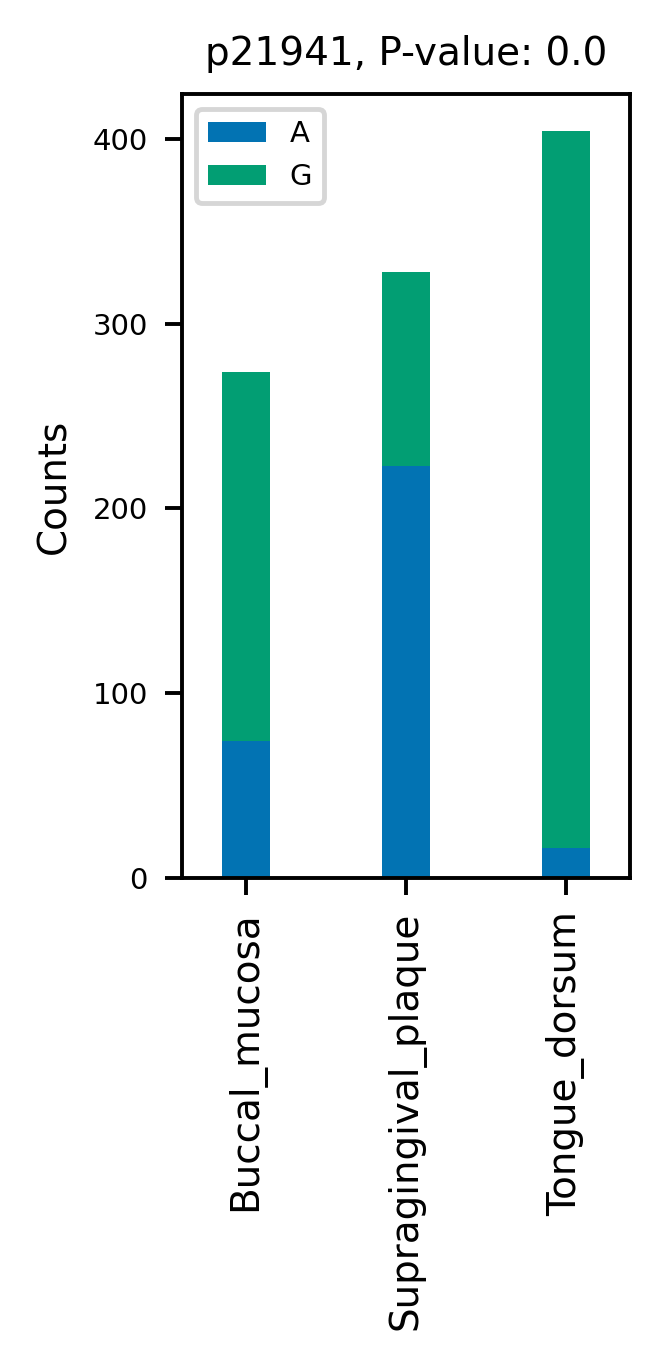

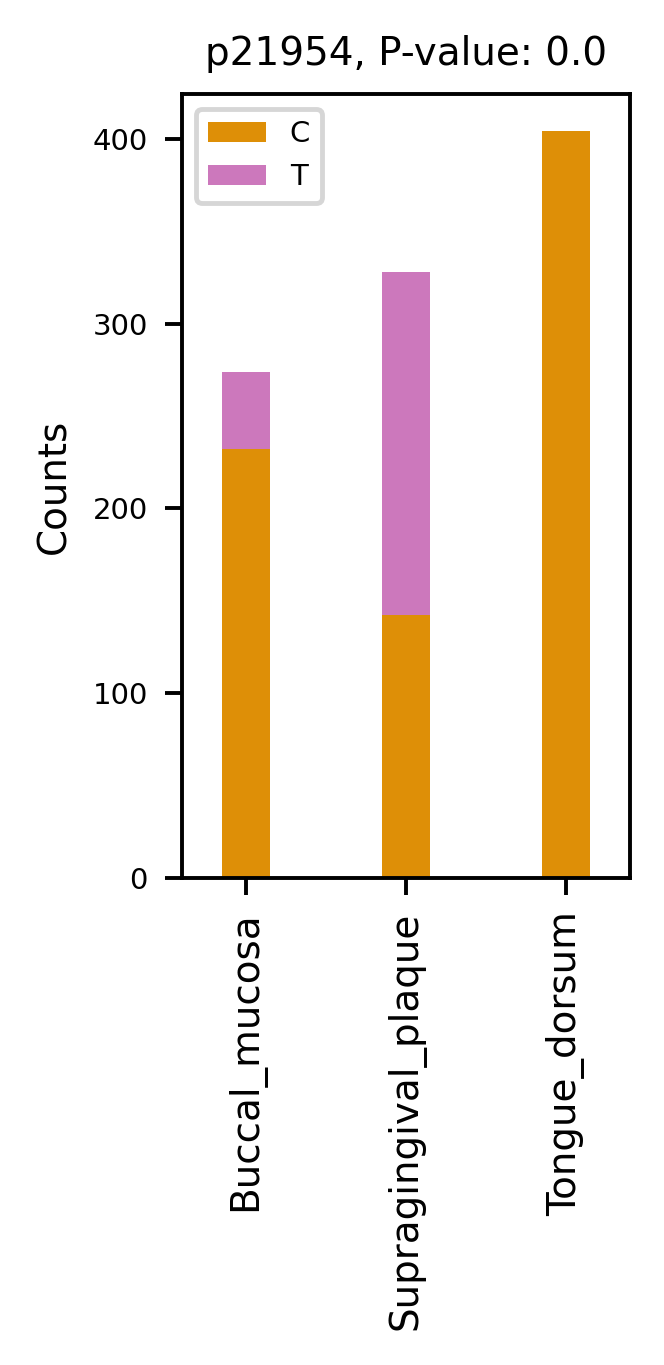

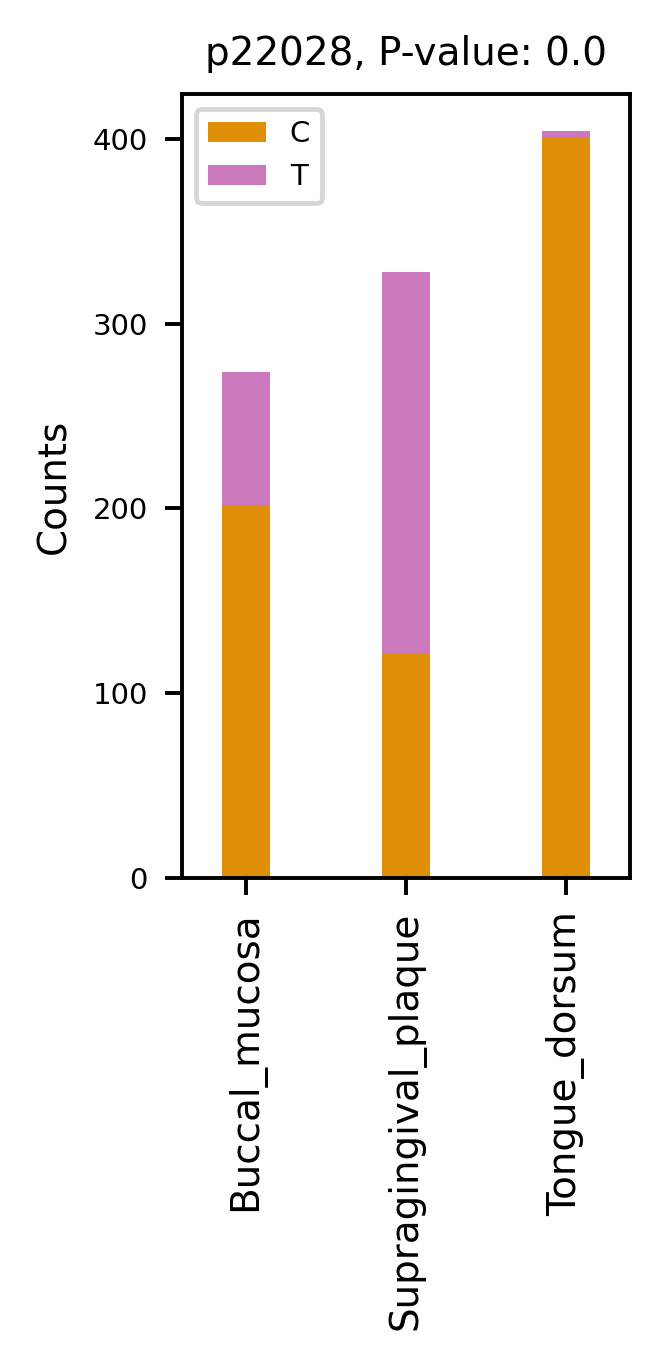

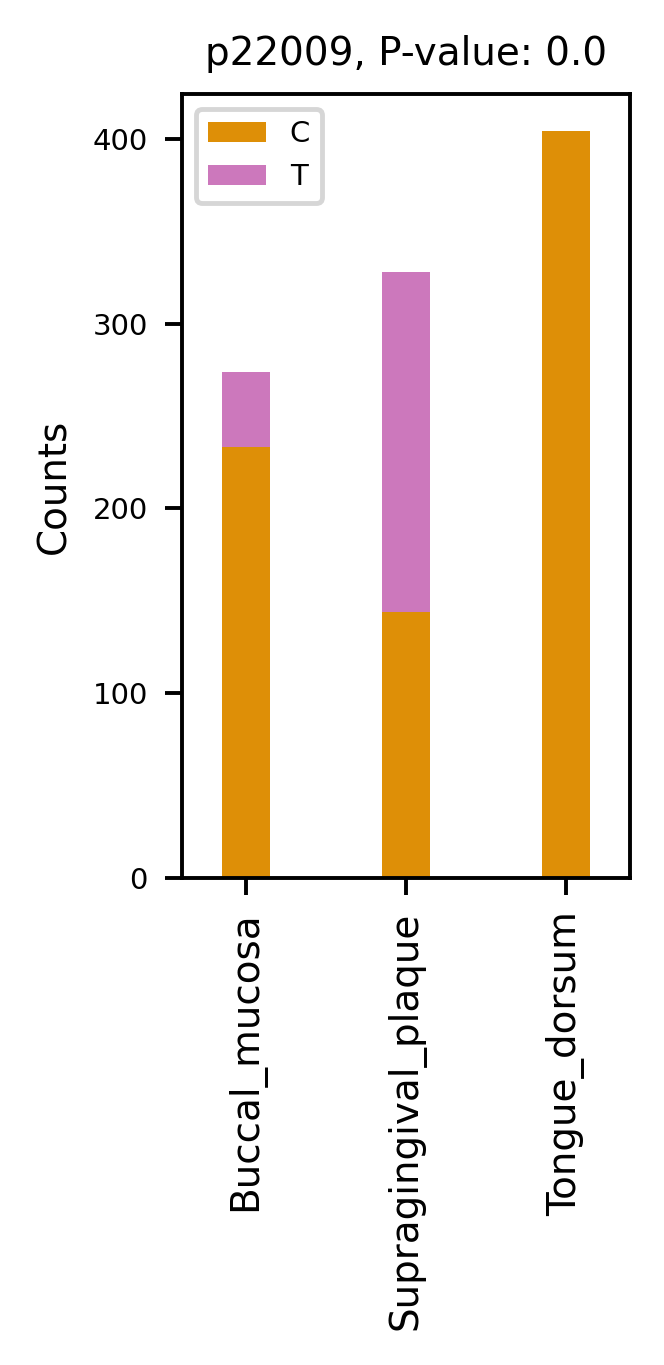

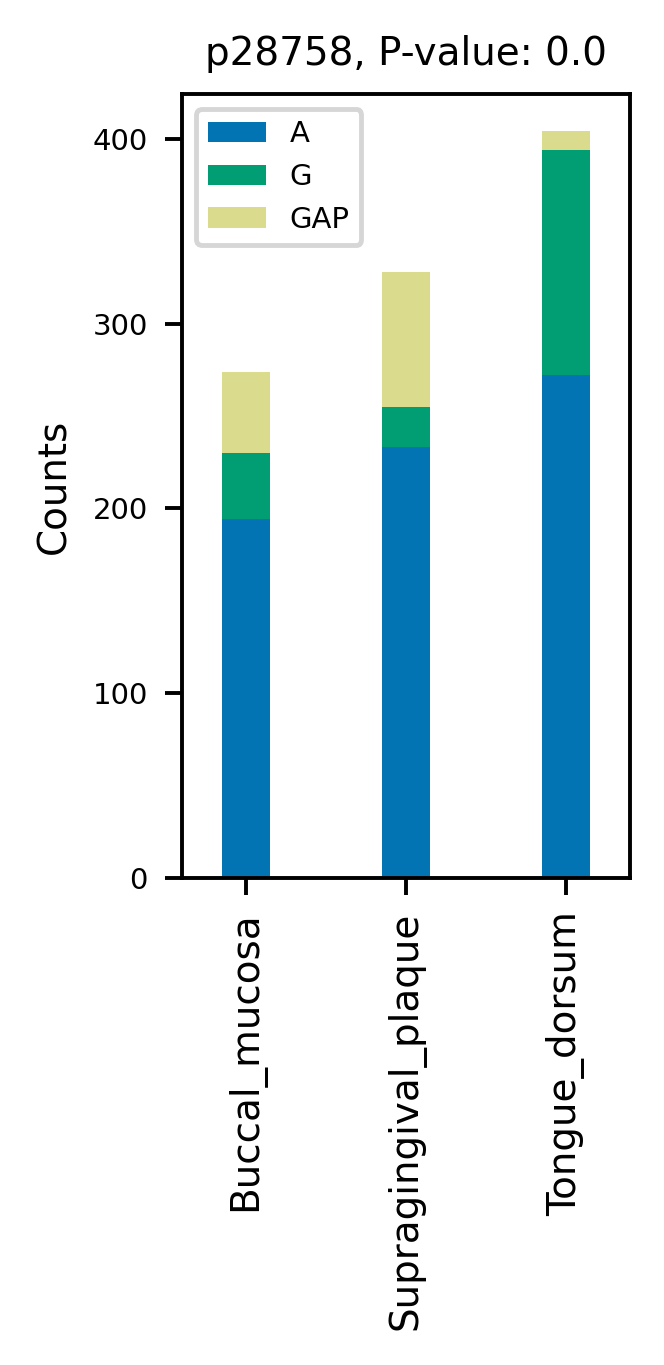

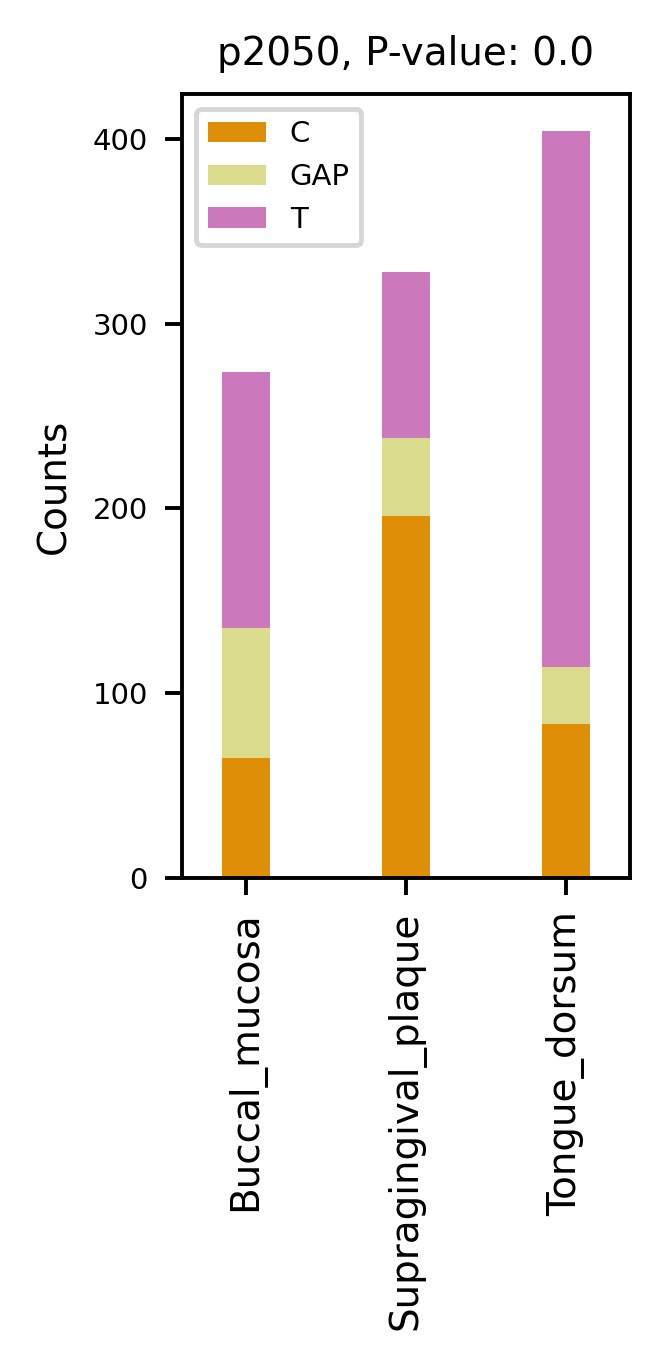

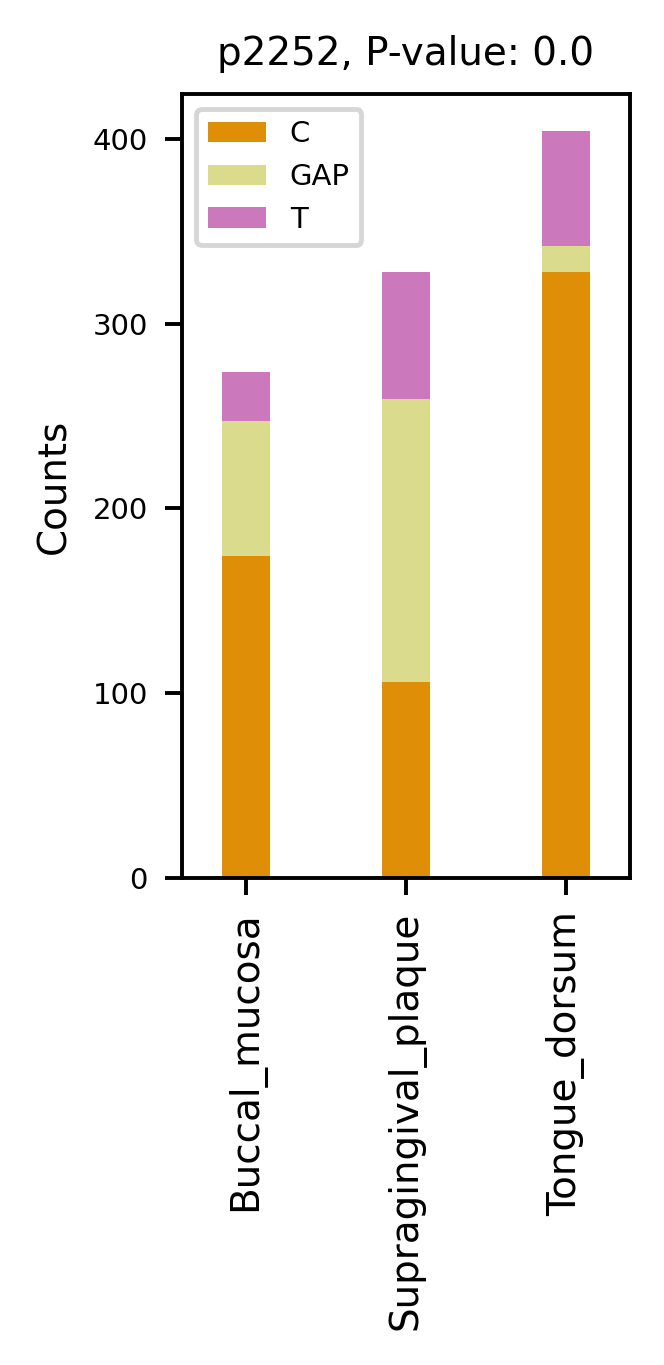

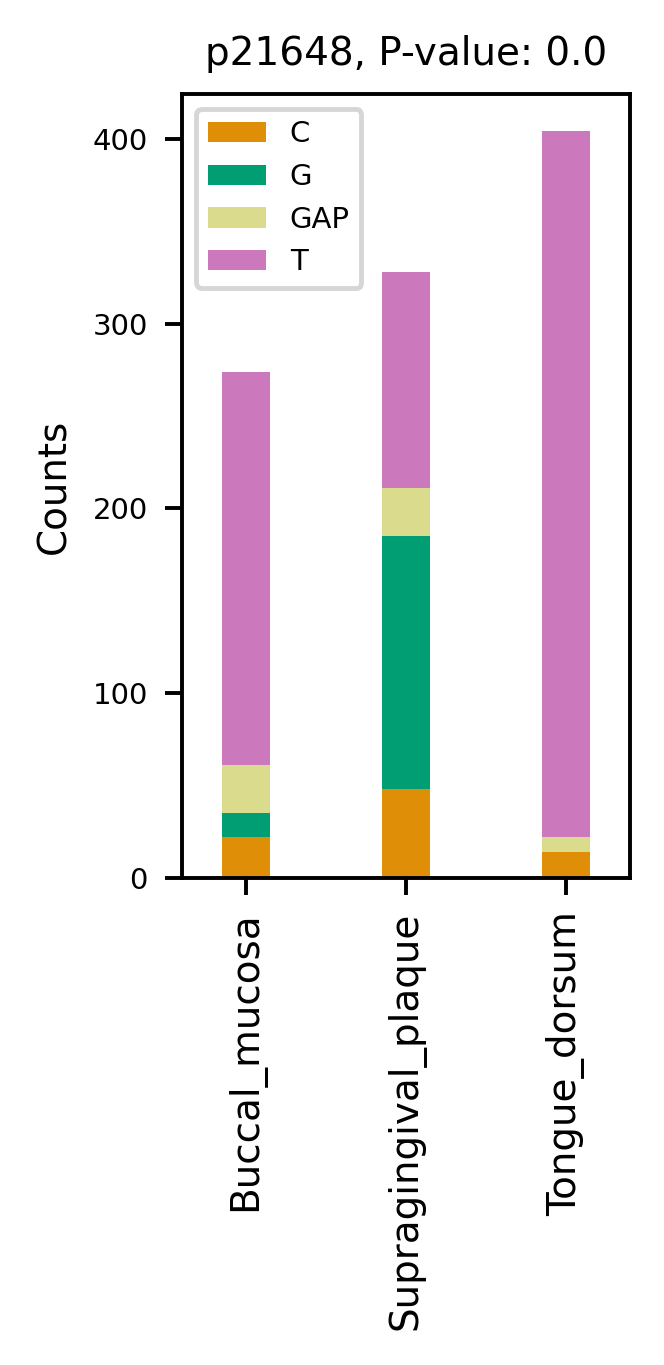

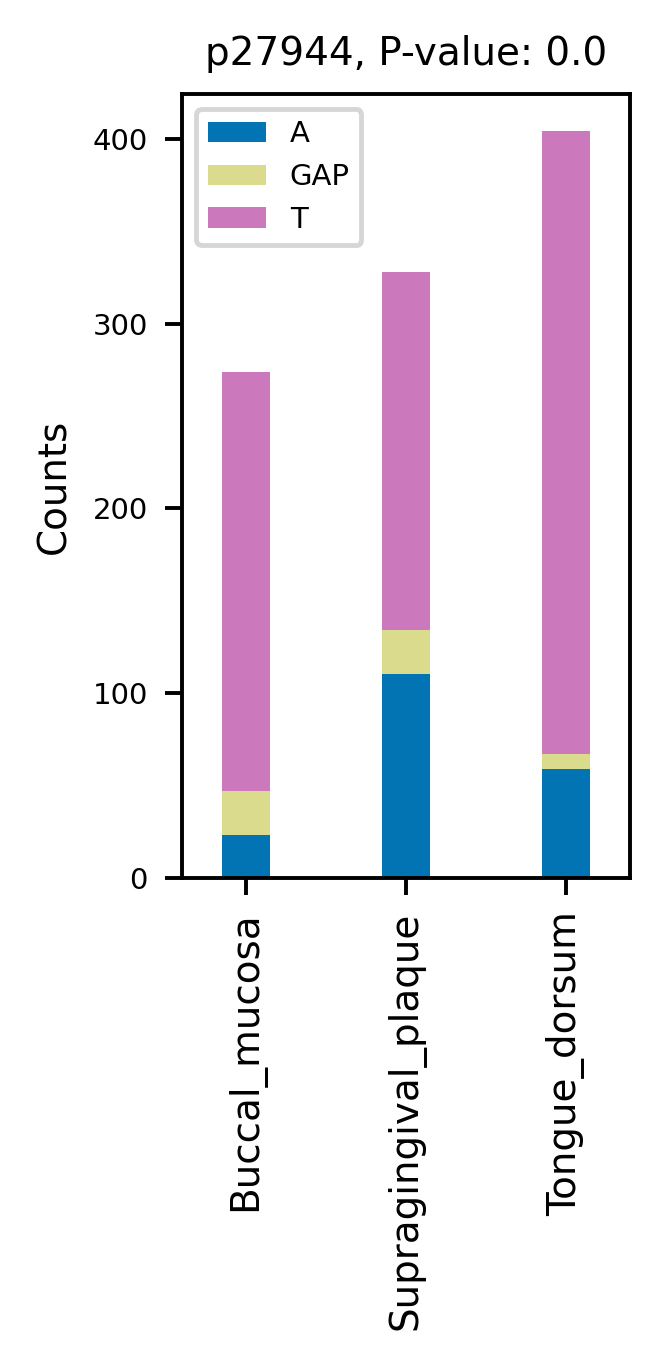

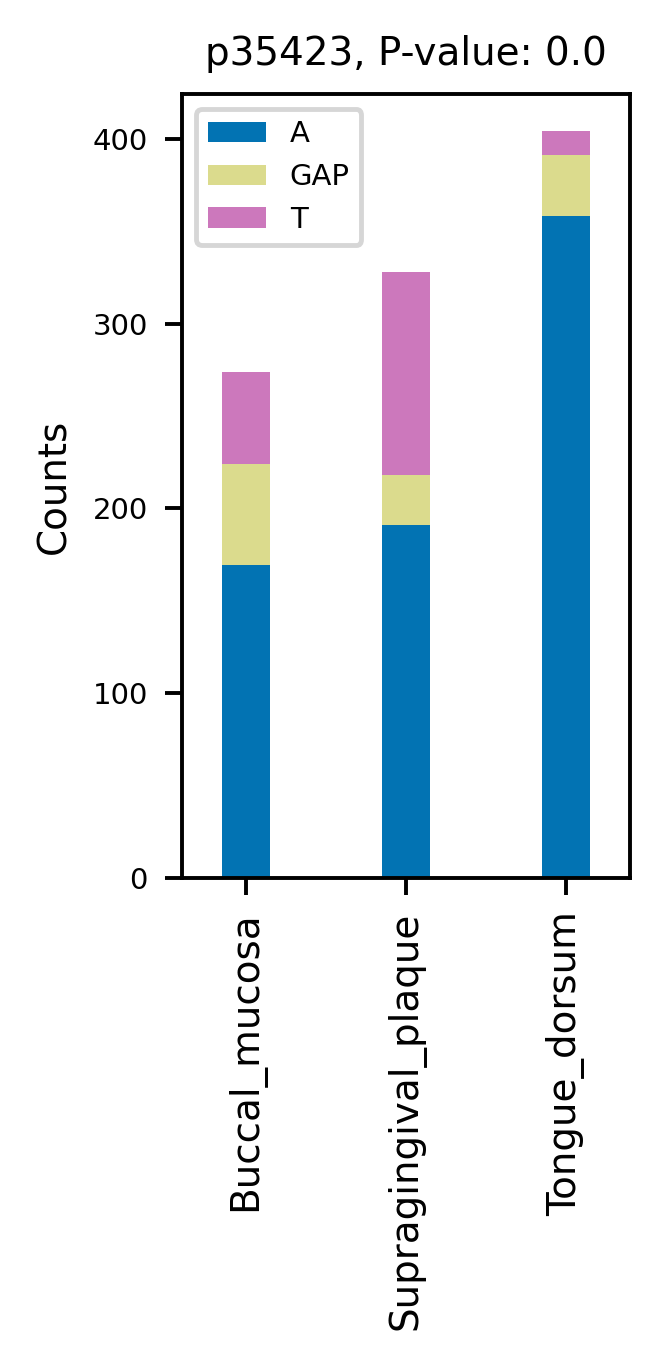

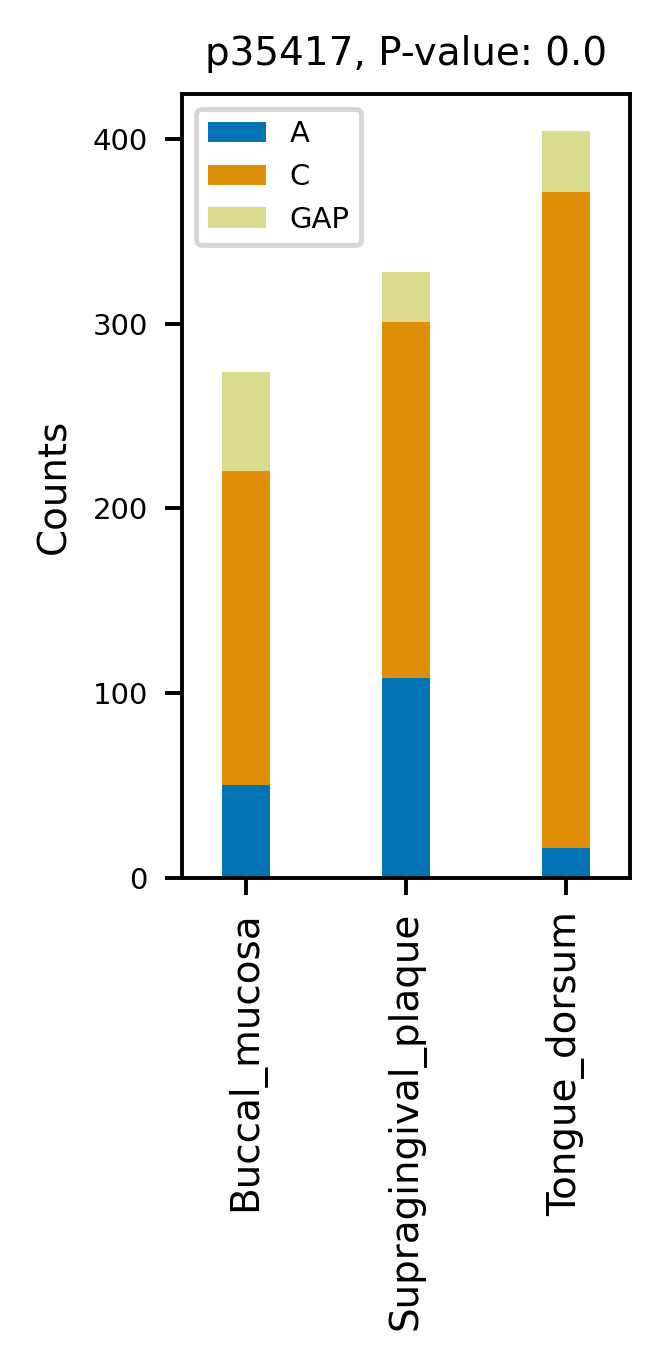

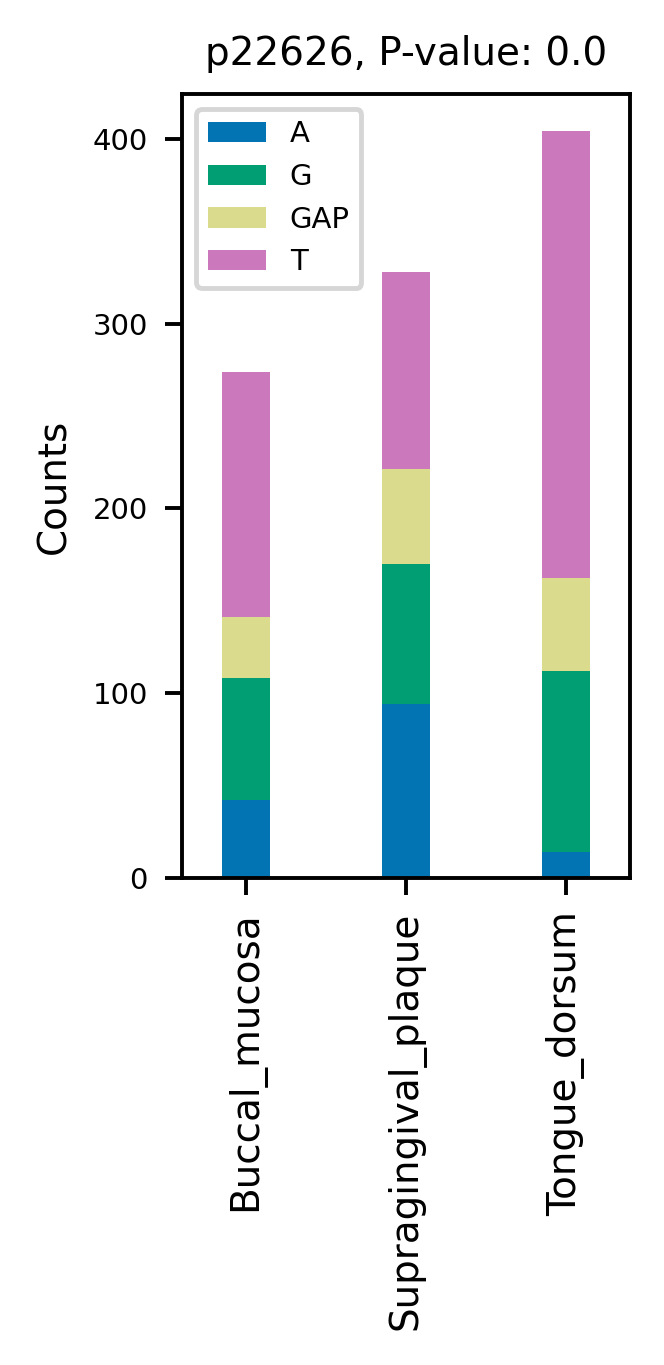

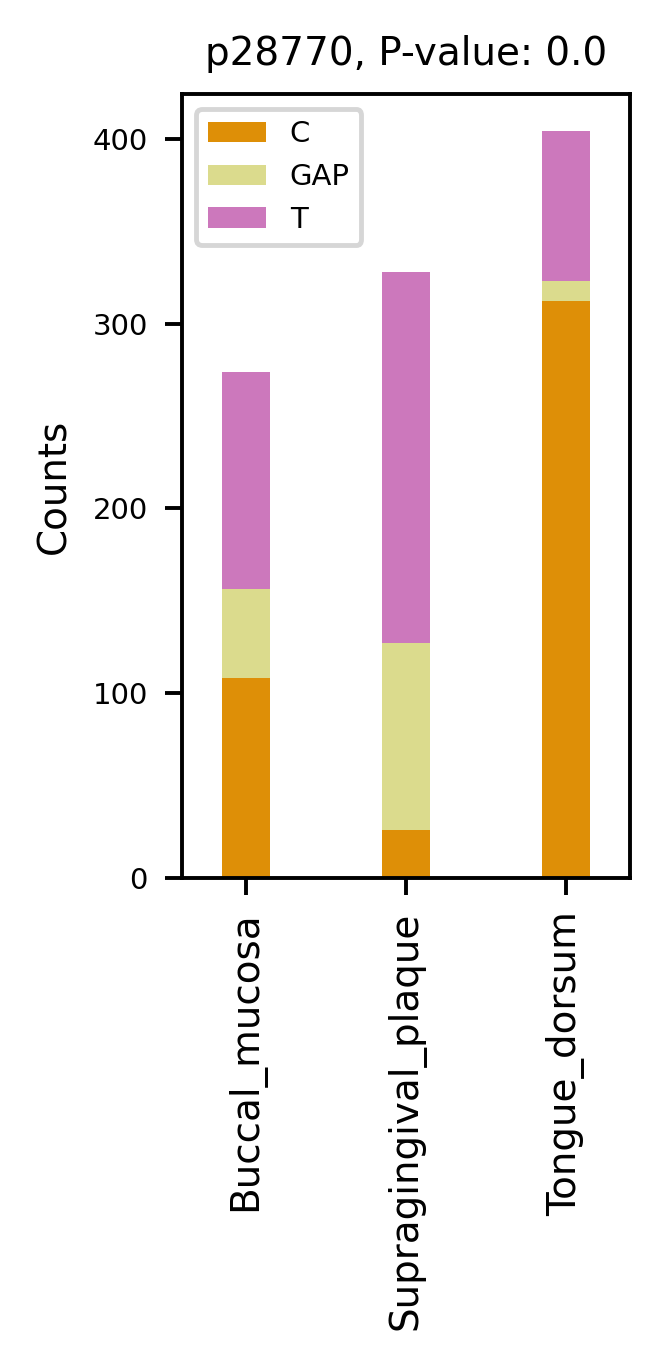

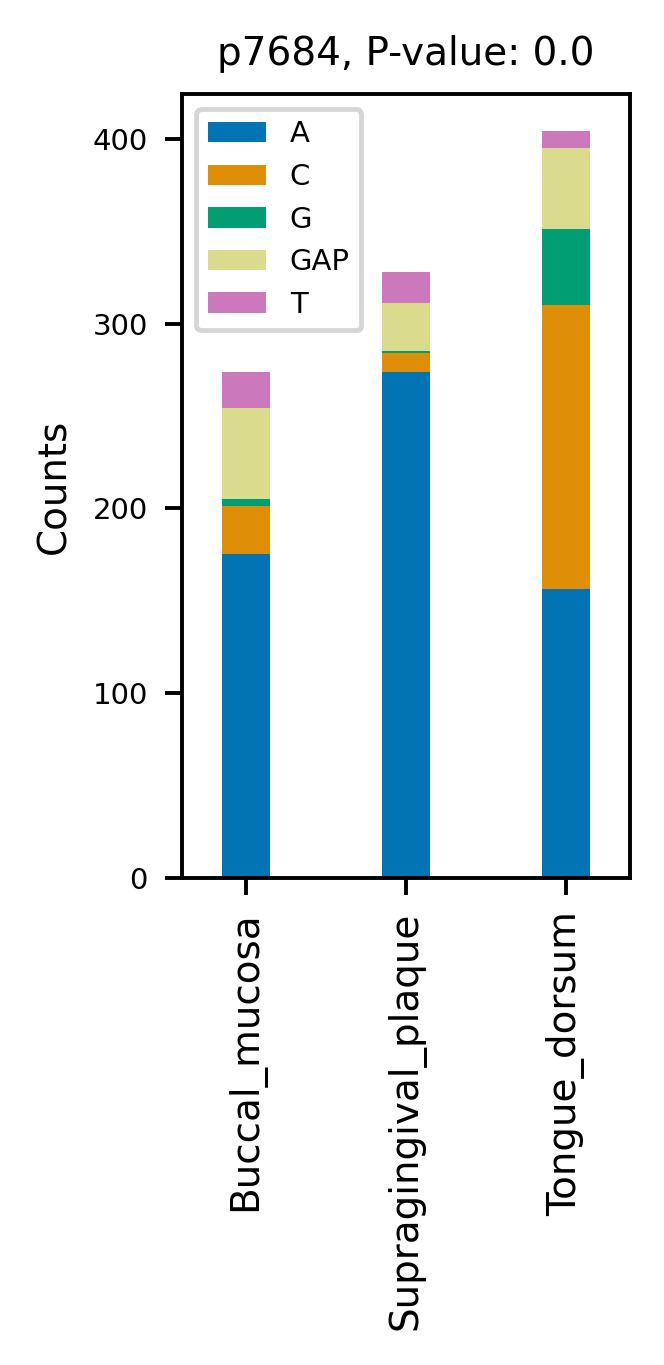

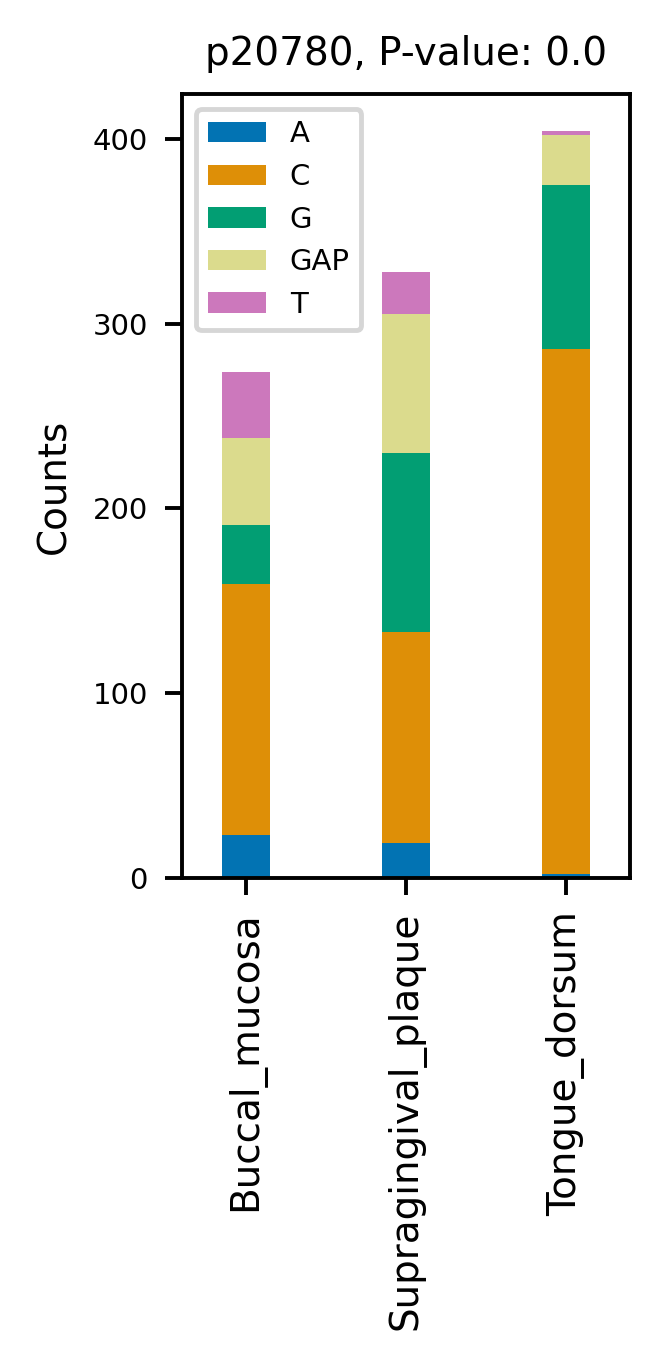

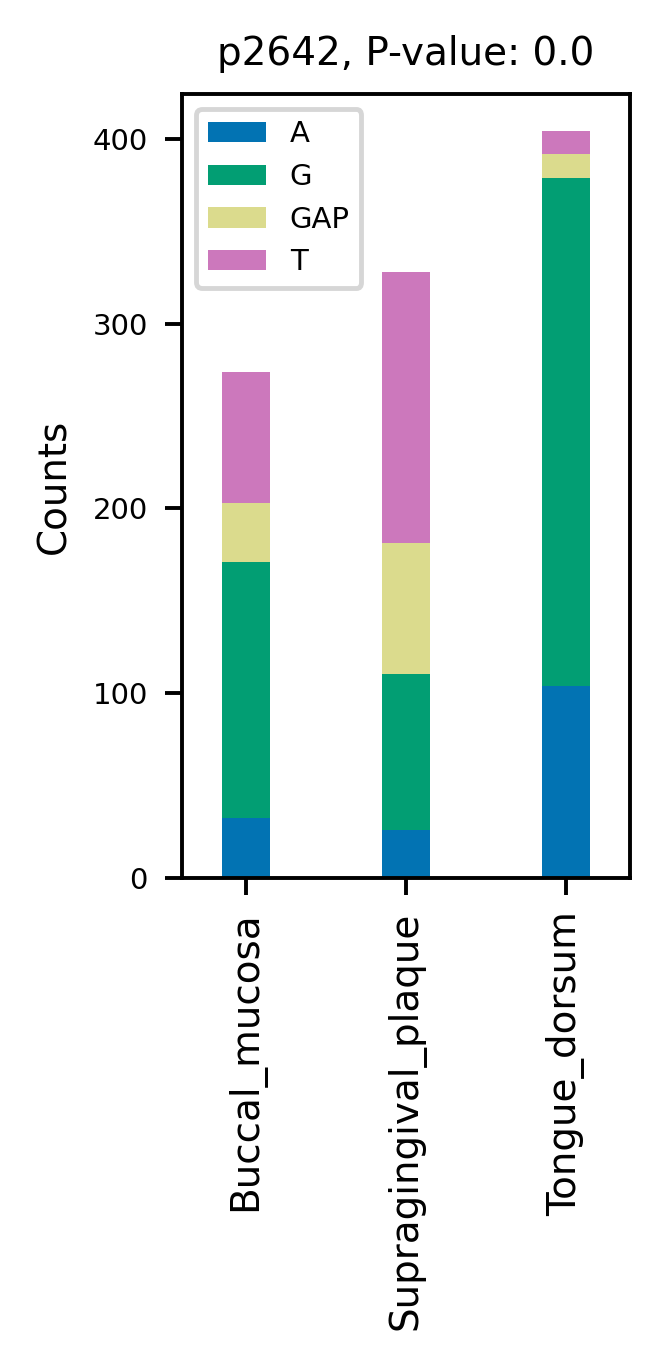

In [31]:
# visualizing top positions 

# visualizing top positions  
plots = viz.plot_imp_all(trained_models=trained_models,
                         X_train=df.loc[:, df.columns != mt],
                         y_train=df.loc[:, mt],
                         meta_var=mt,
                         model_type=anaType,
                         report_dir=report_dir,max_plots=50,
                        figsize=(2,4))